In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras import optimizers
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold

In [2]:
# import data
trainData = pd.read_csv('train.csv',header = 0)
testData = pd.read_csv('test.csv',header = 0)
pId = testData['PassengerId']

In [3]:
# Add title
def NameToTitle(name):
    title = re.search(", ([A-Za-z]+)\. ",name)
    if title:
        t = title.group(1)
        if t == "Mr":
            return 1
        elif t == "Dr":
            return 2
        elif t == "Master":
            return 3
        elif t == "Mrs":
            return 4
        elif t == "Miss":
            return 5
        elif t == "Ms":
            return 6
        else:
            return 7
    else:
        return 0


trainData["Title"] = trainData['Name'].apply(NameToTitle)
testData["Title"] =  testData['Name'].apply(NameToTitle)

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [4]:
# Deal with missing values
def nan_padding(data, columns):
    for column in columns:
        imputer=SimpleImputer()
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data

columns = ["SibSp", "Parch","Fare"]

trainData = nan_padding(trainData, columns)
testData = nan_padding(testData, columns)

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S,1


In [5]:
def DummyData(data, columns):
    for c in columns:
        data = pd.concat([data,pd.get_dummies(data[c],prefix = c)],axis = 1)
        data = data.drop(c,axis = 1)
    return data

columns = ['Pclass','Embarked']
trainData = DummyData(trainData,columns)
testData = DummyData(testData,columns)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,4,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,5,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,4,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,1,0,0,1,0,0,1


In [6]:
def ConvertSex(data):
    le = LabelEncoder()
    le.fit(['male','female'])
    data['Sex'] = le.transform(data['Sex'])
    return
ConvertSex(trainData)
ConvertSex(testData)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,4,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,5,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,4,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,1,0,0,1,0,0,1


In [7]:
# Has Cabin
trainData['HasCabin'] = trainData['Cabin'].apply(lambda x:0 if type(x) == float else 1)
testData['HasCabin'] = testData['Cabin'].apply(lambda x:0 if type(x) == float else 1)

trainData.head()
testData.head()

,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin
0,892,"Kelly, Mr. James",1,34.5,0.0,0.0,330911,7.8292,NaN,1,0,0,1,0,1,0,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1.0,0.0,363272,7.0000,NaN,4,0,0,1,0,0,1,0
2,894,"Myles, Mr. Thomas Francis",1,62.0,0.0,0.0,240276,9.6875,NaN,1,0,1,0,0,1,0,0
3,895,"Wirz, Mr. Albert",1,27.0,0.0,0.0,315154,8.6625,NaN,1,0,0,1,0,0,1,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1.0,1.0,3101298,12.2875,NaN,4,0,0,1,0,0,1,0


In [8]:
# Family size
trainData['FamilySize'] = trainData['SibSp'] + trainData['Parch'] + 1
testData['FamilySize'] = testData['SibSp'] + testData['Parch'] + 1

trainData['IsAlone'] = trainData['FamilySize'].apply(lambda x: 1 if x==1 else 0)
testData['IsAlone'] = testData['FamilySize'].apply(lambda x: 1 if x==1 else 0)


trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,1,0,0,1,0,0,1,0,2.0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,4,1,0,0,1,0,0,1,2.0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,5,0,0,1,0,0,1,0,1.0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,4,1,0,0,0,0,1,1,2.0,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,1,0,0,1,0,0,1,0,1.0,1


In [9]:
# Change age
def ConvertAge(age):
    if age <=12 :
        return 0        
    elif age<=18:
        return 1
    elif age<=60:
        return 2
    else : return 3
trainData['AgeRange'] = trainData['Age'].apply(ConvertAge)
testData['AgeRange'] = testData['Age'].apply(ConvertAge)
trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,...,0,0,1,0,0,1,0,2.0,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,...,1,0,0,1,0,0,1,2.0,0,2
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,...,0,0,1,0,0,1,0,1.0,1,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,...,1,0,0,0,0,1,1,2.0,0,2
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,...,0,0,1,0,0,1,0,1.0,1,2


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,...,0,1,0,0,1,0,2.0,0,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,...,0,0,1,0,0,1,2.0,0,2,4
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,...,0,1,0,0,1,0,1.0,1,2,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,...,0,0,0,0,1,1,2.0,0,2,4
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,...,0,1,0,0,1,0,1.0,1,2,1


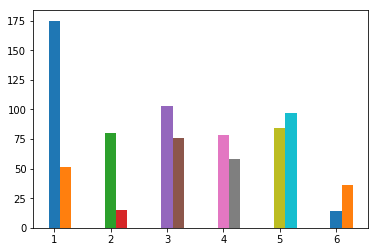

In [10]:
j = 0
k = 0
for i in [8,10,20,30,100,300]:
    k+=1
    plt.bar(k,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==0)).sum(),0.2)
    plt.bar(k+0.2,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==1)).sum(),0.2)
    j = i

# Change fare
def ConvertFare(fare):
    if fare <=8 :
        return 0    
    elif fare<=10:
        return 1
    elif fare<=20:
        return 2
    elif fare<=30:
        return 3
    elif fare<=100:
        return 4
    elif fare<=300:
        return 5
    else : return 6
trainData['FareRange'] = trainData['Fare'].apply(ConvertFare)
testData['FareRange'] = testData['Fare'].apply(ConvertFare)
trainData.head()

In [11]:
def NormalizeData(data,columns):
    scaler = MinMaxScaler()
    for c in columns:
        data[c] = scaler.fit_transform(data[c].values.reshape(-1,1))
    return data


columns = ['Fare']
#trainData = NormalizeData(trainData,columns)
#testData = NormalizeData(testData,columns)

#trainData.head()

In [12]:
# Drop useless data
def DropColumn(data, columns):    
    return data.drop(columns,axis = 1)


columns = ['PassengerId','Name',"Ticket", "Cabin","Age","Fare","SibSp","Parch"]
trainData = DropColumn(trainData,columns)
testData = DropColumn(testData,columns)

trainData.head()

,Survived,Sex,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,1,0,0,1,0,0,1,0,2.0,0,2,0
1,1,0,4,1,0,0,1,0,0,1,2.0,0,2,4
2,1,0,5,0,0,1,0,0,1,0,1.0,1,2,0
3,1,0,4,1,0,0,0,0,1,1,2.0,0,2,4
4,0,1,1,0,0,1,0,0,1,0,1.0,1,2,1


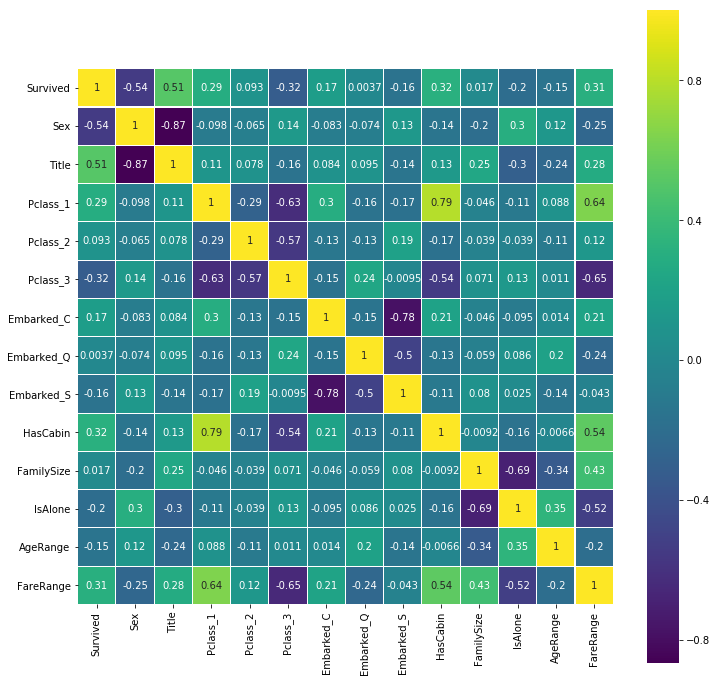

In [13]:
# Visualize co-relation
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
#plt.title("Correlation of Features")
sns.heatmap(trainData.astype(float).corr(),linewidths=0.1,vmax=1.0,square = True, cmap=colormap,linecolor='white',annot=True)

In [14]:
# train data after processing
trainData.head()

,Survived,Sex,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,1,0,0,1,0,0,1,0,2.0,0,2,0
1,1,0,4,1,0,0,1,0,0,1,2.0,0,2,4
2,1,0,5,0,0,1,0,0,1,0,1.0,1,2,0
3,1,0,4,1,0,0,0,0,1,1,2.0,0,2,4
4,0,1,1,0,0,1,0,0,1,0,1.0,1,2,1


In [15]:
# test data after processing
testData.head()

,Sex,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,1,1,0,0,1,0,1,0,0,1.0,1,2,0
1,0,4,0,0,1,0,0,1,0,2.0,0,2,0
2,1,1,0,1,0,0,1,0,0,1.0,1,3,1
3,1,1,0,0,1,0,0,1,0,1.0,1,2,1
4,0,4,0,0,1,0,0,1,0,3.0,0,2,2


In [16]:
trainX = trainData.iloc[:,1:].to_numpy()
trainY = trainData.loc[:,'Survived'].to_numpy()
testX = testData.iloc[:,:].to_numpy()

In [17]:
# Check point
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "./checkpoint.ckpt" , 
                                                 save_weights_only = True,
                                                 save_best_only = True,
                                                 peroid=5, 
                                                 verbose = 1)

In [18]:
def CreateModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 1024, 
                              activation = 'relu', 
                              input_shape=(trainX.shape[1],), 
                              kernel_regularizer = tf.keras.regularizers.l2(0.007)),                               
        tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.007)),        
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.007)), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.007)),                
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.007)),                
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model

In [19]:
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
             metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              14336     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

Train on 712 samples, validate on 179 samples
Epoch 1/2000

Epoch 00001: val_loss improved from inf to 29.18432, saving model to ./checkpoint.ckpt
712/712 - 3s - loss: 29.3719 - accuracy: 0.5281 - val_loss: 29.1843 - val_accuracy: 0.7374
Epoch 2/2000

Epoch 00002: val_loss improved from 29.18432 to 28.84537, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 29.0323 - accuracy: 0.6587 - val_loss: 28.8454 - val_accuracy: 0.7151
Epoch 3/2000

Epoch 00003: val_loss improved from 28.84537 to 28.51050, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 28.7002 - accuracy: 0.6615 - val_loss: 28.5105 - val_accuracy: 0.7151
Epoch 4/2000

Epoch 00004: val_loss improved from 28.51050 to 28.17855, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 28.3687 - accuracy: 0.6629 - val_loss: 28.1786 - val_accuracy: 0.7207
Epoch 5/2000

Epoch 00005: val_loss improved from 28.17855 to 27.85033, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 28.0423 - accuracy: 0.6826 - val_loss: 27.85

Epoch 00042: val_loss improved from 18.56013 to 18.35470, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 18.4379 - accuracy: 0.8090 - val_loss: 18.3547 - val_accuracy: 0.7821
Epoch 43/2000

Epoch 00043: val_loss improved from 18.35470 to 18.15049, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 18.2354 - accuracy: 0.8062 - val_loss: 18.1505 - val_accuracy: 0.7877
Epoch 44/2000

Epoch 00044: val_loss improved from 18.15049 to 17.95058, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 18.0267 - accuracy: 0.8104 - val_loss: 17.9506 - val_accuracy: 0.7821
Epoch 45/2000

Epoch 00045: val_loss improved from 17.95058 to 17.75476, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 17.8277 - accuracy: 0.8062 - val_loss: 17.7548 - val_accuracy: 0.7821
Epoch 46/2000

Epoch 00046: val_loss improved from 17.75476 to 17.55809, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 17.6287 - accuracy: 0.8146 - val_loss: 17.5581 - val_accuracy: 0.7821
Epoch 47/2000

Epoch 0004

712/712 - 1s - loss: 11.5775 - accuracy: 0.8048 - val_loss: 11.5471 - val_accuracy: 0.7933
Epoch 84/2000

Epoch 00084: val_loss improved from 11.54711 to 11.41298, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 11.4367 - accuracy: 0.8132 - val_loss: 11.4130 - val_accuracy: 0.7989
Epoch 85/2000

Epoch 00085: val_loss improved from 11.41298 to 11.28203, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 11.3101 - accuracy: 0.8090 - val_loss: 11.2820 - val_accuracy: 0.7989
Epoch 86/2000

Epoch 00086: val_loss improved from 11.28203 to 11.15426, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 11.1820 - accuracy: 0.8076 - val_loss: 11.1543 - val_accuracy: 0.7877
Epoch 87/2000

Epoch 00087: val_loss improved from 11.15426 to 11.02399, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 11.0522 - accuracy: 0.8202 - val_loss: 11.0240 - val_accuracy: 0.7933
Epoch 88/2000

Epoch 00088: val_loss improved from 11.02399 to 10.89822, saving model to ./checkpoint.ckpt
712/712 - 

Epoch 00125: val_loss improved from 7.14487 to 7.06036, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 7.0510 - accuracy: 0.8202 - val_loss: 7.0604 - val_accuracy: 0.7933
Epoch 126/2000

Epoch 00126: val_loss improved from 7.06036 to 6.97729, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 6.9693 - accuracy: 0.8118 - val_loss: 6.9773 - val_accuracy: 0.7877
Epoch 127/2000

Epoch 00127: val_loss improved from 6.97729 to 6.89606, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 6.8863 - accuracy: 0.8174 - val_loss: 6.8961 - val_accuracy: 0.7877
Epoch 128/2000

Epoch 00128: val_loss improved from 6.89606 to 6.81474, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 6.8027 - accuracy: 0.8090 - val_loss: 6.8147 - val_accuracy: 0.7877
Epoch 129/2000

Epoch 00129: val_loss improved from 6.81474 to 6.73542, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 6.7293 - accuracy: 0.8076 - val_loss: 6.7354 - val_accuracy: 0.7877
Epoch 130/2000

Epoch 00130: val_loss imp

712/712 - 0s - loss: 4.2788 - accuracy: 0.8188 - val_loss: 4.3122 - val_accuracy: 0.7877
Epoch 168/2000

Epoch 00168: val_loss improved from 4.31219 to 4.26085, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 4.2275 - accuracy: 0.8258 - val_loss: 4.2609 - val_accuracy: 0.7877
Epoch 169/2000

Epoch 00169: val_loss improved from 4.26085 to 4.21198, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 4.1718 - accuracy: 0.8258 - val_loss: 4.2120 - val_accuracy: 0.7877
Epoch 170/2000

Epoch 00170: val_loss improved from 4.21198 to 4.16448, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 4.1253 - accuracy: 0.8202 - val_loss: 4.1645 - val_accuracy: 0.7877
Epoch 171/2000

Epoch 00171: val_loss improved from 4.16448 to 4.11646, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 4.0871 - accuracy: 0.8188 - val_loss: 4.1165 - val_accuracy: 0.7877
Epoch 172/2000

Epoch 00172: val_loss improved from 4.11646 to 4.07017, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 4.03

Epoch 210/2000

Epoch 00210: val_loss improved from 2.72454 to 2.69698, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 2.6481 - accuracy: 0.8174 - val_loss: 2.6970 - val_accuracy: 0.7877
Epoch 211/2000

Epoch 00211: val_loss improved from 2.69698 to 2.67014, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 2.6188 - accuracy: 0.8315 - val_loss: 2.6701 - val_accuracy: 0.7877
Epoch 212/2000

Epoch 00212: val_loss improved from 2.67014 to 2.64340, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 2.5852 - accuracy: 0.8329 - val_loss: 2.6434 - val_accuracy: 0.7877
Epoch 213/2000

Epoch 00213: val_loss improved from 2.64340 to 2.61770, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 2.5619 - accuracy: 0.8244 - val_loss: 2.6177 - val_accuracy: 0.7933
Epoch 214/2000

Epoch 00214: val_loss improved from 2.61770 to 2.59245, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 2.5372 - accuracy: 0.8272 - val_loss: 2.5925 - val_accuracy: 0.7933
Epoch 215/2000

Epoch 002

712/712 - 1s - loss: 1.7981 - accuracy: 0.8301 - val_loss: 1.8727 - val_accuracy: 0.7821
Epoch 253/2000

Epoch 00253: val_loss improved from 1.87267 to 1.85963, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.7825 - accuracy: 0.8399 - val_loss: 1.8596 - val_accuracy: 0.7821
Epoch 254/2000

Epoch 00254: val_loss improved from 1.85963 to 1.84551, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.7756 - accuracy: 0.8343 - val_loss: 1.8455 - val_accuracy: 0.7877
Epoch 255/2000

Epoch 00255: val_loss improved from 1.84551 to 1.83261, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.7584 - accuracy: 0.8301 - val_loss: 1.8326 - val_accuracy: 0.7933
Epoch 256/2000

Epoch 00256: val_loss improved from 1.83261 to 1.81870, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 1.7476 - accuracy: 0.8371 - val_loss: 1.8187 - val_accuracy: 0.7821
Epoch 257/2000

Epoch 00257: val_loss improved from 1.81870 to 1.80583, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.73

Epoch 295/2000

Epoch 00295: val_loss improved from 1.45656 to 1.45006, saving model to ./checkpoint.ckpt
712/712 - 2s - loss: 1.3672 - accuracy: 0.8427 - val_loss: 1.4501 - val_accuracy: 0.7933
Epoch 296/2000

Epoch 00296: val_loss improved from 1.45006 to 1.44206, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.3555 - accuracy: 0.8413 - val_loss: 1.4421 - val_accuracy: 0.7933
Epoch 297/2000

Epoch 00297: val_loss improved from 1.44206 to 1.43579, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.3490 - accuracy: 0.8483 - val_loss: 1.4358 - val_accuracy: 0.7821
Epoch 298/2000

Epoch 00298: val_loss improved from 1.43579 to 1.42932, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.3507 - accuracy: 0.8371 - val_loss: 1.4293 - val_accuracy: 0.7765
Epoch 299/2000

Epoch 00299: val_loss improved from 1.42932 to 1.42428, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 1.3407 - accuracy: 0.8343 - val_loss: 1.4243 - val_accuracy: 0.7933
Epoch 300/2000

Epoch 003

712/712 - 1s - loss: 1.1439 - accuracy: 0.8441 - val_loss: 1.2325 - val_accuracy: 0.7989
Epoch 338/2000

Epoch 00338: val_loss improved from 1.23250 to 1.23152, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.1399 - accuracy: 0.8413 - val_loss: 1.2315 - val_accuracy: 0.7877
Epoch 339/2000

Epoch 00339: val_loss improved from 1.23152 to 1.22745, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.1428 - accuracy: 0.8371 - val_loss: 1.2274 - val_accuracy: 0.7877
Epoch 340/2000

Epoch 00340: val_loss improved from 1.22745 to 1.22491, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.1324 - accuracy: 0.8455 - val_loss: 1.2249 - val_accuracy: 0.7989
Epoch 341/2000

Epoch 00341: val_loss improved from 1.22491 to 1.22143, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.1269 - accuracy: 0.8441 - val_loss: 1.2214 - val_accuracy: 0.7877
Epoch 342/2000

Epoch 00342: val_loss improved from 1.22143 to 1.21828, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.12

Epoch 380/2000

Epoch 00380: val_loss improved from 1.10584 to 1.10409, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 1.0126 - accuracy: 0.8357 - val_loss: 1.1041 - val_accuracy: 0.7765
Epoch 381/2000

Epoch 00381: val_loss improved from 1.10409 to 1.10173, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 1.0037 - accuracy: 0.8469 - val_loss: 1.1017 - val_accuracy: 0.7933
Epoch 382/2000

Epoch 00382: val_loss improved from 1.10173 to 1.09880, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.9997 - accuracy: 0.8567 - val_loss: 1.0988 - val_accuracy: 0.7821
Epoch 383/2000

Epoch 00383: val_loss did not improve from 1.09880
712/712 - 0s - loss: 1.0044 - accuracy: 0.8427 - val_loss: 1.0990 - val_accuracy: 0.7765
Epoch 384/2000

Epoch 00384: val_loss improved from 1.09880 to 1.09477, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.9972 - accuracy: 0.8525 - val_loss: 1.0948 - val_accuracy: 0.7933
Epoch 385/2000

Epoch 00385: val_loss improved from 1.09477 to 1

712/712 - 1s - loss: 0.9147 - accuracy: 0.8427 - val_loss: 1.0146 - val_accuracy: 0.7933
Epoch 424/2000

Epoch 00424: val_loss improved from 1.01457 to 1.01398, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 0.9114 - accuracy: 0.8455 - val_loss: 1.0140 - val_accuracy: 0.7877
Epoch 425/2000

Epoch 00425: val_loss improved from 1.01398 to 1.01154, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.9166 - accuracy: 0.8427 - val_loss: 1.0115 - val_accuracy: 0.7877
Epoch 426/2000

Epoch 00426: val_loss improved from 1.01154 to 1.00838, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.9101 - accuracy: 0.8596 - val_loss: 1.0084 - val_accuracy: 0.8045
Epoch 427/2000

Epoch 00427: val_loss improved from 1.00838 to 1.00590, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.9087 - accuracy: 0.8385 - val_loss: 1.0059 - val_accuracy: 0.7933
Epoch 428/2000

Epoch 00428: val_loss improved from 1.00590 to 1.00487, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.90

Epoch 467/2000

Epoch 00467: val_loss did not improve from 0.94724
712/712 - 0s - loss: 0.8435 - accuracy: 0.8483 - val_loss: 0.9480 - val_accuracy: 0.7989
Epoch 468/2000

Epoch 00468: val_loss improved from 0.94724 to 0.94680, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.8460 - accuracy: 0.8441 - val_loss: 0.9468 - val_accuracy: 0.7877
Epoch 469/2000

Epoch 00469: val_loss improved from 0.94680 to 0.94584, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.8360 - accuracy: 0.8469 - val_loss: 0.9458 - val_accuracy: 0.7877
Epoch 470/2000

Epoch 00470: val_loss improved from 0.94584 to 0.94105, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.8388 - accuracy: 0.8371 - val_loss: 0.9411 - val_accuracy: 0.7933
Epoch 471/2000

Epoch 00471: val_loss improved from 0.94105 to 0.93953, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.8335 - accuracy: 0.8497 - val_loss: 0.9395 - val_accuracy: 0.7933
Epoch 472/2000

Epoch 00472: val_loss did not improve from 0.939

Epoch 511/2000

Epoch 00511: val_loss improved from 0.89728 to 0.89629, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 0.7914 - accuracy: 0.8497 - val_loss: 0.8963 - val_accuracy: 0.8101
Epoch 512/2000

Epoch 00512: val_loss improved from 0.89629 to 0.89280, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.7919 - accuracy: 0.8469 - val_loss: 0.8928 - val_accuracy: 0.8045
Epoch 513/2000

Epoch 00513: val_loss improved from 0.89280 to 0.89071, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.7818 - accuracy: 0.8525 - val_loss: 0.8907 - val_accuracy: 0.8045
Epoch 514/2000

Epoch 00514: val_loss improved from 0.89071 to 0.89005, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 0.7828 - accuracy: 0.8427 - val_loss: 0.8900 - val_accuracy: 0.8045
Epoch 515/2000

Epoch 00515: val_loss did not improve from 0.89005
712/712 - 0s - loss: 0.7804 - accuracy: 0.8455 - val_loss: 0.8931 - val_accuracy: 0.7933
Epoch 516/2000

Epoch 00516: val_loss did not improve from 0.890

Epoch 557/2000

Epoch 00557: val_loss improved from 0.85235 to 0.85139, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.7411 - accuracy: 0.8567 - val_loss: 0.8514 - val_accuracy: 0.8101
Epoch 558/2000

Epoch 00558: val_loss improved from 0.85139 to 0.85102, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.7486 - accuracy: 0.8455 - val_loss: 0.8510 - val_accuracy: 0.8045
Epoch 559/2000

Epoch 00559: val_loss did not improve from 0.85102
712/712 - 0s - loss: 0.7403 - accuracy: 0.8483 - val_loss: 0.8527 - val_accuracy: 0.7989
Epoch 560/2000

Epoch 00560: val_loss improved from 0.85102 to 0.85096, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 0.7343 - accuracy: 0.8553 - val_loss: 0.8510 - val_accuracy: 0.8045
Epoch 561/2000

Epoch 00561: val_loss improved from 0.85096 to 0.84803, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 0.7396 - accuracy: 0.8511 - val_loss: 0.8480 - val_accuracy: 0.8101
Epoch 562/2000

Epoch 00562: val_loss did not improve from 0.848

Epoch 603/2000

Epoch 00603: val_loss improved from 0.81998 to 0.81868, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.7040 - accuracy: 0.8525 - val_loss: 0.8187 - val_accuracy: 0.8045
Epoch 604/2000

Epoch 00604: val_loss improved from 0.81868 to 0.81787, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.7041 - accuracy: 0.8525 - val_loss: 0.8179 - val_accuracy: 0.7989
Epoch 605/2000

Epoch 00605: val_loss improved from 0.81787 to 0.81579, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.7053 - accuracy: 0.8567 - val_loss: 0.8158 - val_accuracy: 0.8101
Epoch 606/2000

Epoch 00606: val_loss did not improve from 0.81579
712/712 - 0s - loss: 0.6997 - accuracy: 0.8567 - val_loss: 0.8162 - val_accuracy: 0.8101
Epoch 607/2000

Epoch 00607: val_loss did not improve from 0.81579
712/712 - 0s - loss: 0.7082 - accuracy: 0.8610 - val_loss: 0.8218 - val_accuracy: 0.7933
Epoch 608/2000

Epoch 00608: val_loss did not improve from 0.81579
712/712 - 0s - loss: 0.7067 - accura

Epoch 00650: val_loss did not improve from 0.79169
712/712 - 0s - loss: 0.6791 - accuracy: 0.8511 - val_loss: 0.7926 - val_accuracy: 0.8045
Epoch 651/2000

Epoch 00651: val_loss improved from 0.79169 to 0.79039, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 0.6727 - accuracy: 0.8638 - val_loss: 0.7904 - val_accuracy: 0.8101
Epoch 652/2000

Epoch 00652: val_loss did not improve from 0.79039
712/712 - 0s - loss: 0.6746 - accuracy: 0.8624 - val_loss: 0.7916 - val_accuracy: 0.8101
Epoch 653/2000

Epoch 00653: val_loss improved from 0.79039 to 0.78857, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6702 - accuracy: 0.8539 - val_loss: 0.7886 - val_accuracy: 0.8045
Epoch 654/2000

Epoch 00654: val_loss did not improve from 0.78857
712/712 - 0s - loss: 0.6691 - accuracy: 0.8539 - val_loss: 0.7888 - val_accuracy: 0.8101
Epoch 655/2000

Epoch 00655: val_loss did not improve from 0.78857
712/712 - 0s - loss: 0.6721 - accuracy: 0.8567 - val_loss: 0.7891 - val_accuracy: 0.7989
Ep

Epoch 698/2000

Epoch 00698: val_loss did not improve from 0.76713
712/712 - 0s - loss: 0.6506 - accuracy: 0.8553 - val_loss: 0.7688 - val_accuracy: 0.7989
Epoch 699/2000

Epoch 00699: val_loss improved from 0.76713 to 0.76675, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6486 - accuracy: 0.8539 - val_loss: 0.7668 - val_accuracy: 0.8101
Epoch 700/2000

Epoch 00700: val_loss improved from 0.76675 to 0.76475, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6428 - accuracy: 0.8652 - val_loss: 0.7648 - val_accuracy: 0.8101
Epoch 701/2000

Epoch 00701: val_loss did not improve from 0.76475
712/712 - 0s - loss: 0.6458 - accuracy: 0.8581 - val_loss: 0.7669 - val_accuracy: 0.8101
Epoch 702/2000

Epoch 00702: val_loss did not improve from 0.76475
712/712 - 0s - loss: 0.6480 - accuracy: 0.8525 - val_loss: 0.7665 - val_accuracy: 0.8045
Epoch 703/2000

Epoch 00703: val_loss did not improve from 0.76475
712/712 - 0s - loss: 0.6435 - accuracy: 0.8596 - val_loss: 0.7656 - val_acc

Epoch 747/2000

Epoch 00747: val_loss improved from 0.74689 to 0.74588, saving model to ./checkpoint.ckpt
712/712 - 2s - loss: 0.6268 - accuracy: 0.8596 - val_loss: 0.7459 - val_accuracy: 0.8045
Epoch 748/2000

Epoch 00748: val_loss improved from 0.74588 to 0.74479, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6276 - accuracy: 0.8638 - val_loss: 0.7448 - val_accuracy: 0.8101
Epoch 749/2000

Epoch 00749: val_loss improved from 0.74479 to 0.74476, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6263 - accuracy: 0.8596 - val_loss: 0.7448 - val_accuracy: 0.8045
Epoch 750/2000

Epoch 00750: val_loss did not improve from 0.74476
712/712 - 0s - loss: 0.6245 - accuracy: 0.8638 - val_loss: 0.7448 - val_accuracy: 0.8045
Epoch 751/2000

Epoch 00751: val_loss improved from 0.74476 to 0.74348, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6285 - accuracy: 0.8497 - val_loss: 0.7435 - val_accuracy: 0.8101
Epoch 752/2000

Epoch 00752: val_loss did not improve from 0.743


Epoch 00795: val_loss did not improve from 0.73157
712/712 - 0s - loss: 0.6054 - accuracy: 0.8610 - val_loss: 0.7317 - val_accuracy: 0.8045
Epoch 796/2000

Epoch 00796: val_loss did not improve from 0.73157
712/712 - 0s - loss: 0.6010 - accuracy: 0.8483 - val_loss: 0.7321 - val_accuracy: 0.8156
Epoch 797/2000

Epoch 00797: val_loss improved from 0.73157 to 0.73149, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6071 - accuracy: 0.8581 - val_loss: 0.7315 - val_accuracy: 0.8101
Epoch 798/2000

Epoch 00798: val_loss improved from 0.73149 to 0.72911, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.6038 - accuracy: 0.8596 - val_loss: 0.7291 - val_accuracy: 0.8045
Epoch 799/2000

Epoch 00799: val_loss did not improve from 0.72911
712/712 - 0s - loss: 0.6036 - accuracy: 0.8511 - val_loss: 0.7314 - val_accuracy: 0.8045
Epoch 800/2000

Epoch 00800: val_loss did not improve from 0.72911
712/712 - 0s - loss: 0.6044 - accuracy: 0.8610 - val_loss: 0.7303 - val_accuracy: 0.8045
E

712/712 - 0s - loss: 0.5908 - accuracy: 0.8610 - val_loss: 0.7166 - val_accuracy: 0.8045
Epoch 845/2000

Epoch 00845: val_loss did not improve from 0.71659
712/712 - 0s - loss: 0.5873 - accuracy: 0.8581 - val_loss: 0.7183 - val_accuracy: 0.7989
Epoch 846/2000

Epoch 00846: val_loss did not improve from 0.71659
712/712 - 0s - loss: 0.5894 - accuracy: 0.8567 - val_loss: 0.7182 - val_accuracy: 0.8045
Epoch 847/2000

Epoch 00847: val_loss did not improve from 0.71659
712/712 - 0s - loss: 0.5924 - accuracy: 0.8539 - val_loss: 0.7175 - val_accuracy: 0.8045
Epoch 848/2000

Epoch 00848: val_loss improved from 0.71659 to 0.71577, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.5931 - accuracy: 0.8553 - val_loss: 0.7158 - val_accuracy: 0.8101
Epoch 849/2000

Epoch 00849: val_loss improved from 0.71577 to 0.71493, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.5883 - accuracy: 0.8610 - val_loss: 0.7149 - val_accuracy: 0.8045
Epoch 850/2000

Epoch 00850: val_loss did not improve

712/712 - 1s - loss: 0.5700 - accuracy: 0.8694 - val_loss: 0.7046 - val_accuracy: 0.8101
Epoch 895/2000

Epoch 00895: val_loss did not improve from 0.70464
712/712 - 0s - loss: 0.5722 - accuracy: 0.8652 - val_loss: 0.7061 - val_accuracy: 0.8045
Epoch 896/2000

Epoch 00896: val_loss did not improve from 0.70464
712/712 - 0s - loss: 0.5738 - accuracy: 0.8610 - val_loss: 0.7066 - val_accuracy: 0.8045
Epoch 897/2000

Epoch 00897: val_loss did not improve from 0.70464
712/712 - 0s - loss: 0.5772 - accuracy: 0.8497 - val_loss: 0.7065 - val_accuracy: 0.8045
Epoch 898/2000

Epoch 00898: val_loss did not improve from 0.70464
712/712 - 0s - loss: 0.5760 - accuracy: 0.8553 - val_loss: 0.7068 - val_accuracy: 0.8045
Epoch 899/2000

Epoch 00899: val_loss did not improve from 0.70464
712/712 - 0s - loss: 0.5704 - accuracy: 0.8596 - val_loss: 0.7075 - val_accuracy: 0.8045
Epoch 900/2000

Epoch 00900: val_loss improved from 0.70464 to 0.70362, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.57

Epoch 944/2000

Epoch 00944: val_loss improved from 0.69519 to 0.69477, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.5638 - accuracy: 0.8610 - val_loss: 0.6948 - val_accuracy: 0.8045
Epoch 945/2000

Epoch 00945: val_loss did not improve from 0.69477
712/712 - 0s - loss: 0.5579 - accuracy: 0.8610 - val_loss: 0.6965 - val_accuracy: 0.7989
Epoch 946/2000

Epoch 00946: val_loss improved from 0.69477 to 0.69475, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.5700 - accuracy: 0.8497 - val_loss: 0.6947 - val_accuracy: 0.8101
Epoch 947/2000

Epoch 00947: val_loss did not improve from 0.69475
712/712 - 0s - loss: 0.5629 - accuracy: 0.8581 - val_loss: 0.6949 - val_accuracy: 0.8045
Epoch 948/2000

Epoch 00948: val_loss improved from 0.69475 to 0.69318, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.5577 - accuracy: 0.8596 - val_loss: 0.6932 - val_accuracy: 0.8045
Epoch 949/2000

Epoch 00949: val_loss did not improve from 0.69318
712/712 - 0s - loss: 0.5610 - accura

712/712 - 0s - loss: 0.5501 - accuracy: 0.8666 - val_loss: 0.6857 - val_accuracy: 0.8045
Epoch 994/2000

Epoch 00994: val_loss did not improve from 0.68567
712/712 - 0s - loss: 0.5507 - accuracy: 0.8694 - val_loss: 0.6868 - val_accuracy: 0.8045
Epoch 995/2000

Epoch 00995: val_loss did not improve from 0.68567
712/712 - 0s - loss: 0.5451 - accuracy: 0.8596 - val_loss: 0.6875 - val_accuracy: 0.8045
Epoch 996/2000

Epoch 00996: val_loss did not improve from 0.68567
712/712 - 0s - loss: 0.5559 - accuracy: 0.8567 - val_loss: 0.6873 - val_accuracy: 0.8045
Epoch 997/2000

Epoch 00997: val_loss did not improve from 0.68567
712/712 - 0s - loss: 0.5477 - accuracy: 0.8624 - val_loss: 0.6879 - val_accuracy: 0.8045
Epoch 998/2000

Epoch 00998: val_loss did not improve from 0.68567
712/712 - 0s - loss: 0.5447 - accuracy: 0.8624 - val_loss: 0.6862 - val_accuracy: 0.8045
Epoch 999/2000

Epoch 00999: val_loss did not improve from 0.68567
712/712 - 0s - loss: 0.5509 - accuracy: 0.8581 - val_loss: 0.686

Epoch 1045/2000

Epoch 01045: val_loss did not improve from 0.67652
712/712 - 0s - loss: 0.5379 - accuracy: 0.8666 - val_loss: 0.6796 - val_accuracy: 0.8045
Epoch 1046/2000

Epoch 01046: val_loss did not improve from 0.67652
712/712 - 0s - loss: 0.5336 - accuracy: 0.8680 - val_loss: 0.6802 - val_accuracy: 0.7989
Epoch 1047/2000

Epoch 01047: val_loss did not improve from 0.67652
712/712 - 0s - loss: 0.5399 - accuracy: 0.8610 - val_loss: 0.6824 - val_accuracy: 0.8101
Epoch 1048/2000

Epoch 01048: val_loss did not improve from 0.67652
712/712 - 0s - loss: 0.5365 - accuracy: 0.8610 - val_loss: 0.6801 - val_accuracy: 0.8045
Epoch 1049/2000

Epoch 01049: val_loss did not improve from 0.67652
712/712 - 0s - loss: 0.5427 - accuracy: 0.8553 - val_loss: 0.6809 - val_accuracy: 0.7989
Epoch 1050/2000

Epoch 01050: val_loss did not improve from 0.67652
712/712 - 0s - loss: 0.5343 - accuracy: 0.8652 - val_loss: 0.6803 - val_accuracy: 0.8045
Epoch 1051/2000

Epoch 01051: val_loss did not improve fro

Epoch 1096/2000

Epoch 01096: val_loss did not improve from 0.67272
712/712 - 0s - loss: 0.5302 - accuracy: 0.8652 - val_loss: 0.6748 - val_accuracy: 0.7989
Epoch 1097/2000

Epoch 01097: val_loss did not improve from 0.67272
712/712 - 0s - loss: 0.5349 - accuracy: 0.8581 - val_loss: 0.6780 - val_accuracy: 0.8045
Epoch 1098/2000

Epoch 01098: val_loss did not improve from 0.67272
712/712 - 0s - loss: 0.5278 - accuracy: 0.8624 - val_loss: 0.6771 - val_accuracy: 0.8045
Epoch 1099/2000

Epoch 01099: val_loss did not improve from 0.67272
712/712 - 0s - loss: 0.5268 - accuracy: 0.8652 - val_loss: 0.6741 - val_accuracy: 0.8045
Epoch 1100/2000

Epoch 01100: val_loss did not improve from 0.67272
712/712 - 0s - loss: 0.5315 - accuracy: 0.8652 - val_loss: 0.6753 - val_accuracy: 0.7933
Epoch 1101/2000

Epoch 01101: val_loss did not improve from 0.67272
712/712 - 0s - loss: 0.5313 - accuracy: 0.8638 - val_loss: 0.6744 - val_accuracy: 0.7989
Epoch 1102/2000

Epoch 01102: val_loss did not improve fro

Epoch 1148/2000

Epoch 01148: val_loss improved from 0.66752 to 0.66521, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.5196 - accuracy: 0.8652 - val_loss: 0.6652 - val_accuracy: 0.8045
Epoch 1149/2000

Epoch 01149: val_loss did not improve from 0.66521
712/712 - 0s - loss: 0.5202 - accuracy: 0.8694 - val_loss: 0.6671 - val_accuracy: 0.8045
Epoch 1150/2000

Epoch 01150: val_loss did not improve from 0.66521
712/712 - 0s - loss: 0.5211 - accuracy: 0.8553 - val_loss: 0.6698 - val_accuracy: 0.7989
Epoch 1151/2000

Epoch 01151: val_loss did not improve from 0.66521
712/712 - 0s - loss: 0.5203 - accuracy: 0.8567 - val_loss: 0.6678 - val_accuracy: 0.8045
Epoch 1152/2000

Epoch 01152: val_loss did not improve from 0.66521
712/712 - 0s - loss: 0.5188 - accuracy: 0.8694 - val_loss: 0.6698 - val_accuracy: 0.7989
Epoch 1153/2000

Epoch 01153: val_loss did not improve from 0.66521
712/712 - 0s - loss: 0.5239 - accuracy: 0.8610 - val_loss: 0.6705 - val_accuracy: 0.8045
Epoch 1154/2000

Ep

Epoch 1200/2000

Epoch 01200: val_loss did not improve from 0.66172
712/712 - 0s - loss: 0.5155 - accuracy: 0.8567 - val_loss: 0.6633 - val_accuracy: 0.8045
Epoch 1201/2000

Epoch 01201: val_loss did not improve from 0.66172
712/712 - 0s - loss: 0.5098 - accuracy: 0.8778 - val_loss: 0.6628 - val_accuracy: 0.8212
Epoch 1202/2000

Epoch 01202: val_loss did not improve from 0.66172
712/712 - 0s - loss: 0.5083 - accuracy: 0.8708 - val_loss: 0.6636 - val_accuracy: 0.7989
Epoch 1203/2000

Epoch 01203: val_loss did not improve from 0.66172
712/712 - 0s - loss: 0.5110 - accuracy: 0.8708 - val_loss: 0.6635 - val_accuracy: 0.8156
Epoch 1204/2000

Epoch 01204: val_loss did not improve from 0.66172
712/712 - 0s - loss: 0.5155 - accuracy: 0.8610 - val_loss: 0.6642 - val_accuracy: 0.7989
Epoch 1205/2000

Epoch 01205: val_loss did not improve from 0.66172
712/712 - 0s - loss: 0.5135 - accuracy: 0.8539 - val_loss: 0.6637 - val_accuracy: 0.8045
Epoch 1206/2000

Epoch 01206: val_loss did not improve fro

Epoch 1252/2000

Epoch 01252: val_loss did not improve from 0.65822
712/712 - 0s - loss: 0.5062 - accuracy: 0.8610 - val_loss: 0.6603 - val_accuracy: 0.8045
Epoch 1253/2000

Epoch 01253: val_loss did not improve from 0.65822
712/712 - 0s - loss: 0.5008 - accuracy: 0.8680 - val_loss: 0.6605 - val_accuracy: 0.7989
Epoch 1254/2000

Epoch 01254: val_loss did not improve from 0.65822
712/712 - 0s - loss: 0.5079 - accuracy: 0.8652 - val_loss: 0.6619 - val_accuracy: 0.8045
Epoch 1255/2000

Epoch 01255: val_loss did not improve from 0.65822
712/712 - 0s - loss: 0.5066 - accuracy: 0.8652 - val_loss: 0.6585 - val_accuracy: 0.8156
Epoch 1256/2000

Epoch 01256: val_loss did not improve from 0.65822
712/712 - 0s - loss: 0.5009 - accuracy: 0.8624 - val_loss: 0.6608 - val_accuracy: 0.8101
Epoch 1257/2000

Epoch 01257: val_loss did not improve from 0.65822
712/712 - 0s - loss: 0.5019 - accuracy: 0.8666 - val_loss: 0.6603 - val_accuracy: 0.7989
Epoch 1258/2000

Epoch 01258: val_loss did not improve fro

Epoch 1303/2000

Epoch 01303: val_loss did not improve from 0.65681
712/712 - 0s - loss: 0.5016 - accuracy: 0.8736 - val_loss: 0.6637 - val_accuracy: 0.8045
Epoch 1304/2000

Epoch 01304: val_loss did not improve from 0.65681
712/712 - 0s - loss: 0.5008 - accuracy: 0.8624 - val_loss: 0.6570 - val_accuracy: 0.8045
Epoch 1305/2000

Epoch 01305: val_loss improved from 0.65681 to 0.65650, saving model to ./checkpoint.ckpt
712/712 - 1s - loss: 0.4991 - accuracy: 0.8581 - val_loss: 0.6565 - val_accuracy: 0.8101
Epoch 1306/2000

Epoch 01306: val_loss improved from 0.65650 to 0.65237, saving model to ./checkpoint.ckpt
712/712 - 0s - loss: 0.5014 - accuracy: 0.8694 - val_loss: 0.6524 - val_accuracy: 0.8156
Epoch 1307/2000

Epoch 01307: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4941 - accuracy: 0.8708 - val_loss: 0.6558 - val_accuracy: 0.8156
Epoch 1308/2000

Epoch 01308: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4942 - accuracy: 0.8638 - val_loss: 0.6550 - v

Epoch 1355/2000

Epoch 01355: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4929 - accuracy: 0.8596 - val_loss: 0.6524 - val_accuracy: 0.7989
Epoch 1356/2000

Epoch 01356: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4890 - accuracy: 0.8750 - val_loss: 0.6577 - val_accuracy: 0.8045
Epoch 1357/2000

Epoch 01357: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4974 - accuracy: 0.8638 - val_loss: 0.6586 - val_accuracy: 0.7989
Epoch 1358/2000

Epoch 01358: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4924 - accuracy: 0.8722 - val_loss: 0.6544 - val_accuracy: 0.7989
Epoch 1359/2000

Epoch 01359: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4936 - accuracy: 0.8624 - val_loss: 0.6525 - val_accuracy: 0.8045
Epoch 1360/2000

Epoch 01360: val_loss did not improve from 0.65237
712/712 - 0s - loss: 0.4877 - accuracy: 0.8610 - val_loss: 0.6586 - val_accuracy: 0.8101
Epoch 1361/2000

Epoch 01361: val_loss did not improve fro

Epoch 1407/2000

Epoch 01407: val_loss did not improve from 0.65002
712/712 - 0s - loss: 0.4880 - accuracy: 0.8680 - val_loss: 0.6509 - val_accuracy: 0.8045
Epoch 1408/2000

Epoch 01408: val_loss did not improve from 0.65002
712/712 - 0s - loss: 0.4851 - accuracy: 0.8722 - val_loss: 0.6503 - val_accuracy: 0.8045
Epoch 1409/2000

Epoch 01409: val_loss did not improve from 0.65002
712/712 - 0s - loss: 0.4860 - accuracy: 0.8666 - val_loss: 0.6512 - val_accuracy: 0.8045
Epoch 1410/2000

Epoch 01410: val_loss did not improve from 0.65002
712/712 - 0s - loss: 0.4844 - accuracy: 0.8708 - val_loss: 0.6537 - val_accuracy: 0.7989
Epoch 1411/2000

Epoch 01411: val_loss did not improve from 0.65002
712/712 - 0s - loss: 0.4806 - accuracy: 0.8666 - val_loss: 0.6548 - val_accuracy: 0.8045
Epoch 1412/2000

Epoch 01412: val_loss did not improve from 0.65002
712/712 - 0s - loss: 0.4892 - accuracy: 0.8806 - val_loss: 0.6515 - val_accuracy: 0.8101
Epoch 1413/2000

Epoch 01413: val_loss did not improve fro

Epoch 1459/2000

Epoch 01459: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4852 - accuracy: 0.8666 - val_loss: 0.6511 - val_accuracy: 0.8045
Epoch 1460/2000

Epoch 01460: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4819 - accuracy: 0.8694 - val_loss: 0.6512 - val_accuracy: 0.8045
Epoch 1461/2000

Epoch 01461: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4812 - accuracy: 0.8764 - val_loss: 0.6533 - val_accuracy: 0.8101
Epoch 1462/2000

Epoch 01462: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4724 - accuracy: 0.8694 - val_loss: 0.6520 - val_accuracy: 0.8101
Epoch 1463/2000

Epoch 01463: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4815 - accuracy: 0.8638 - val_loss: 0.6535 - val_accuracy: 0.7989
Epoch 1464/2000

Epoch 01464: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4770 - accuracy: 0.8722 - val_loss: 0.6535 - val_accuracy: 0.7989
Epoch 1465/2000

Epoch 01465: val_loss did not improve fro

Epoch 1512/2000

Epoch 01512: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4795 - accuracy: 0.8736 - val_loss: 0.6594 - val_accuracy: 0.7933
Epoch 1513/2000

Epoch 01513: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4829 - accuracy: 0.8652 - val_loss: 0.6529 - val_accuracy: 0.8101
Epoch 1514/2000

Epoch 01514: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4684 - accuracy: 0.8680 - val_loss: 0.6531 - val_accuracy: 0.8045
Epoch 1515/2000

Epoch 01515: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4720 - accuracy: 0.8708 - val_loss: 0.6553 - val_accuracy: 0.8045
Epoch 1516/2000

Epoch 01516: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4753 - accuracy: 0.8666 - val_loss: 0.6523 - val_accuracy: 0.8101
Epoch 1517/2000

Epoch 01517: val_loss did not improve from 0.64782
712/712 - 0s - loss: 0.4767 - accuracy: 0.8666 - val_loss: 0.6521 - val_accuracy: 0.7989
Epoch 1518/2000

Epoch 01518: val_loss did not improve fro

Epoch 1564/2000

Epoch 01564: val_loss did not improve from 0.64649
712/712 - 0s - loss: 0.4727 - accuracy: 0.8750 - val_loss: 0.6511 - val_accuracy: 0.8101
Epoch 1565/2000

Epoch 01565: val_loss did not improve from 0.64649
712/712 - 0s - loss: 0.4781 - accuracy: 0.8581 - val_loss: 0.6549 - val_accuracy: 0.7933
Epoch 1566/2000

Epoch 01566: val_loss did not improve from 0.64649
712/712 - 0s - loss: 0.4715 - accuracy: 0.8736 - val_loss: 0.6474 - val_accuracy: 0.7989
Epoch 1567/2000

Epoch 01567: val_loss did not improve from 0.64649
712/712 - 0s - loss: 0.4775 - accuracy: 0.8652 - val_loss: 0.6502 - val_accuracy: 0.8101
Epoch 1568/2000

Epoch 01568: val_loss did not improve from 0.64649
712/712 - 0s - loss: 0.4700 - accuracy: 0.8708 - val_loss: 0.6501 - val_accuracy: 0.7989
Epoch 1569/2000

Epoch 01569: val_loss did not improve from 0.64649
712/712 - 0s - loss: 0.4755 - accuracy: 0.8596 - val_loss: 0.6514 - val_accuracy: 0.7989
Epoch 1570/2000

Epoch 01570: val_loss improved from 0.646

Epoch 1616/2000

Epoch 01616: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4666 - accuracy: 0.8652 - val_loss: 0.6547 - val_accuracy: 0.8045
Epoch 1617/2000

Epoch 01617: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4635 - accuracy: 0.8750 - val_loss: 0.6535 - val_accuracy: 0.8101
Epoch 1618/2000

Epoch 01618: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4634 - accuracy: 0.8736 - val_loss: 0.6529 - val_accuracy: 0.7989
Epoch 1619/2000

Epoch 01619: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4684 - accuracy: 0.8722 - val_loss: 0.6519 - val_accuracy: 0.7989
Epoch 1620/2000

Epoch 01620: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4632 - accuracy: 0.8708 - val_loss: 0.6502 - val_accuracy: 0.7989
Epoch 1621/2000

Epoch 01621: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4637 - accuracy: 0.8778 - val_loss: 0.6519 - val_accuracy: 0.7989
Epoch 1622/2000

Epoch 01622: val_loss did not improve fro

Epoch 1669/2000

Epoch 01669: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4612 - accuracy: 0.8778 - val_loss: 0.6502 - val_accuracy: 0.8045
Epoch 1670/2000

Epoch 01670: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4577 - accuracy: 0.8778 - val_loss: 0.6493 - val_accuracy: 0.7989
Epoch 1671/2000

Epoch 01671: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4614 - accuracy: 0.8764 - val_loss: 0.6492 - val_accuracy: 0.7989
Epoch 1672/2000

Epoch 01672: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4579 - accuracy: 0.8666 - val_loss: 0.6483 - val_accuracy: 0.8045
Epoch 1673/2000

Epoch 01673: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4576 - accuracy: 0.8722 - val_loss: 0.6495 - val_accuracy: 0.7989
Epoch 1674/2000

Epoch 01674: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4593 - accuracy: 0.8722 - val_loss: 0.6494 - val_accuracy: 0.8045
Epoch 1675/2000

Epoch 01675: val_loss did not improve fro

Epoch 1722/2000

Epoch 01722: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4577 - accuracy: 0.8680 - val_loss: 0.6481 - val_accuracy: 0.7989
Epoch 1723/2000

Epoch 01723: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4572 - accuracy: 0.8736 - val_loss: 0.6472 - val_accuracy: 0.7989
Epoch 1724/2000

Epoch 01724: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4506 - accuracy: 0.8792 - val_loss: 0.6494 - val_accuracy: 0.7989
Epoch 1725/2000

Epoch 01725: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4509 - accuracy: 0.8820 - val_loss: 0.6533 - val_accuracy: 0.7989
Epoch 1726/2000

Epoch 01726: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4539 - accuracy: 0.8680 - val_loss: 0.6489 - val_accuracy: 0.8045
Epoch 1727/2000

Epoch 01727: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4578 - accuracy: 0.8708 - val_loss: 0.6473 - val_accuracy: 0.8156
Epoch 1728/2000

Epoch 01728: val_loss did not improve fro

Epoch 1775/2000

Epoch 01775: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4554 - accuracy: 0.8722 - val_loss: 0.6484 - val_accuracy: 0.7989
Epoch 1776/2000

Epoch 01776: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4583 - accuracy: 0.8750 - val_loss: 0.6496 - val_accuracy: 0.8045
Epoch 1777/2000

Epoch 01777: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4568 - accuracy: 0.8736 - val_loss: 0.6481 - val_accuracy: 0.8045
Epoch 1778/2000

Epoch 01778: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4453 - accuracy: 0.8722 - val_loss: 0.6487 - val_accuracy: 0.7989
Epoch 1779/2000

Epoch 01779: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4524 - accuracy: 0.8764 - val_loss: 0.6509 - val_accuracy: 0.7989
Epoch 1780/2000

Epoch 01780: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4554 - accuracy: 0.8750 - val_loss: 0.6501 - val_accuracy: 0.7989
Epoch 1781/2000

Epoch 01781: val_loss did not improve fro

Epoch 1828/2000

Epoch 01828: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4449 - accuracy: 0.8694 - val_loss: 0.6474 - val_accuracy: 0.7989
Epoch 1829/2000

Epoch 01829: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4459 - accuracy: 0.8750 - val_loss: 0.6490 - val_accuracy: 0.7989
Epoch 1830/2000

Epoch 01830: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4499 - accuracy: 0.8764 - val_loss: 0.6500 - val_accuracy: 0.8045
Epoch 1831/2000

Epoch 01831: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4490 - accuracy: 0.8778 - val_loss: 0.6518 - val_accuracy: 0.7989
Epoch 1832/2000

Epoch 01832: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4434 - accuracy: 0.8708 - val_loss: 0.6507 - val_accuracy: 0.7989
Epoch 1833/2000

Epoch 01833: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4486 - accuracy: 0.8694 - val_loss: 0.6496 - val_accuracy: 0.8045
Epoch 1834/2000

Epoch 01834: val_loss did not improve fro

Epoch 1881/2000

Epoch 01881: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4449 - accuracy: 0.8834 - val_loss: 0.6572 - val_accuracy: 0.8101
Epoch 1882/2000

Epoch 01882: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4589 - accuracy: 0.8722 - val_loss: 0.6513 - val_accuracy: 0.8156
Epoch 1883/2000

Epoch 01883: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4501 - accuracy: 0.8624 - val_loss: 0.6556 - val_accuracy: 0.7933
Epoch 1884/2000

Epoch 01884: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4408 - accuracy: 0.8806 - val_loss: 0.6517 - val_accuracy: 0.7989
Epoch 1885/2000

Epoch 01885: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4431 - accuracy: 0.8834 - val_loss: 0.6506 - val_accuracy: 0.7989
Epoch 1886/2000

Epoch 01886: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4415 - accuracy: 0.8834 - val_loss: 0.6516 - val_accuracy: 0.7989
Epoch 1887/2000

Epoch 01887: val_loss did not improve fro

Epoch 1934/2000

Epoch 01934: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4402 - accuracy: 0.8764 - val_loss: 0.6514 - val_accuracy: 0.8101
Epoch 1935/2000

Epoch 01935: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4430 - accuracy: 0.8834 - val_loss: 0.6520 - val_accuracy: 0.7989
Epoch 1936/2000

Epoch 01936: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4385 - accuracy: 0.8820 - val_loss: 0.6517 - val_accuracy: 0.7989
Epoch 1937/2000

Epoch 01937: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4396 - accuracy: 0.8778 - val_loss: 0.6517 - val_accuracy: 0.8045
Epoch 1938/2000

Epoch 01938: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4431 - accuracy: 0.8778 - val_loss: 0.6534 - val_accuracy: 0.8045
Epoch 1939/2000

Epoch 01939: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4383 - accuracy: 0.8876 - val_loss: 0.6511 - val_accuracy: 0.7989
Epoch 1940/2000

Epoch 01940: val_loss did not improve fro

Epoch 1987/2000

Epoch 01987: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4382 - accuracy: 0.8792 - val_loss: 0.6493 - val_accuracy: 0.7989
Epoch 1988/2000

Epoch 01988: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4406 - accuracy: 0.8792 - val_loss: 0.6537 - val_accuracy: 0.8156
Epoch 1989/2000

Epoch 01989: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4400 - accuracy: 0.8778 - val_loss: 0.6521 - val_accuracy: 0.8045
Epoch 1990/2000

Epoch 01990: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4375 - accuracy: 0.8834 - val_loss: 0.6539 - val_accuracy: 0.7989
Epoch 1991/2000

Epoch 01991: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4367 - accuracy: 0.8862 - val_loss: 0.6529 - val_accuracy: 0.7989
Epoch 1992/2000

Epoch 01992: val_loss did not improve from 0.64497
712/712 - 0s - loss: 0.4325 - accuracy: 0.8876 - val_loss: 0.6515 - val_accuracy: 0.7989
Epoch 1993/2000

Epoch 01993: val_loss did not improve fro

Epoch 39/2000

Epoch 00039: val_loss did not improve from 0.64497
713/713 - 0s - loss: 19.0680 - accuracy: 0.8093 - val_loss: 18.9814 - val_accuracy: 0.7753
Epoch 40/2000

Epoch 00040: val_loss did not improve from 0.64497
713/713 - 0s - loss: 18.8517 - accuracy: 0.8079 - val_loss: 18.7707 - val_accuracy: 0.7809
Epoch 41/2000

Epoch 00041: val_loss did not improve from 0.64497
713/713 - 0s - loss: 18.6485 - accuracy: 0.7980 - val_loss: 18.5615 - val_accuracy: 0.7753
Epoch 42/2000

Epoch 00042: val_loss did not improve from 0.64497
713/713 - 0s - loss: 18.4378 - accuracy: 0.7952 - val_loss: 18.3556 - val_accuracy: 0.7809
Epoch 43/2000

Epoch 00043: val_loss did not improve from 0.64497
713/713 - 0s - loss: 18.2263 - accuracy: 0.8036 - val_loss: 18.1525 - val_accuracy: 0.7809
Epoch 44/2000

Epoch 00044: val_loss did not improve from 0.64497
713/713 - 0s - loss: 18.0324 - accuracy: 0.7980 - val_loss: 17.9520 - val_accuracy: 0.7809
Epoch 45/2000

Epoch 00045: val_loss did not improve from 

Epoch 92/2000

Epoch 00092: val_loss did not improve from 0.64497
713/713 - 0s - loss: 10.4251 - accuracy: 0.8093 - val_loss: 10.3882 - val_accuracy: 0.7753
Epoch 93/2000

Epoch 00093: val_loss did not improve from 0.64497
713/713 - 0s - loss: 10.2994 - accuracy: 0.8121 - val_loss: 10.2680 - val_accuracy: 0.7809
Epoch 94/2000

Epoch 00094: val_loss did not improve from 0.64497
713/713 - 0s - loss: 10.1778 - accuracy: 0.8121 - val_loss: 10.1485 - val_accuracy: 0.7753
Epoch 95/2000

Epoch 00095: val_loss did not improve from 0.64497
713/713 - 0s - loss: 10.0643 - accuracy: 0.8036 - val_loss: 10.0319 - val_accuracy: 0.7809
Epoch 96/2000

Epoch 00096: val_loss did not improve from 0.64497
713/713 - 0s - loss: 9.9471 - accuracy: 0.7994 - val_loss: 9.9149 - val_accuracy: 0.7809
Epoch 97/2000

Epoch 00097: val_loss did not improve from 0.64497
713/713 - 0s - loss: 9.8304 - accuracy: 0.8008 - val_loss: 9.7996 - val_accuracy: 0.7809
Epoch 98/2000

Epoch 00098: val_loss did not improve from 0.64

Epoch 145/2000

Epoch 00145: val_loss did not improve from 0.64497
713/713 - 0s - loss: 5.5480 - accuracy: 0.8233 - val_loss: 5.5493 - val_accuracy: 0.7640
Epoch 146/2000

Epoch 00146: val_loss did not improve from 0.64497
713/713 - 0s - loss: 5.4882 - accuracy: 0.8163 - val_loss: 5.4829 - val_accuracy: 0.7809
Epoch 147/2000

Epoch 00147: val_loss did not improve from 0.64497
713/713 - 0s - loss: 5.4203 - accuracy: 0.8149 - val_loss: 5.4181 - val_accuracy: 0.7753
Epoch 148/2000

Epoch 00148: val_loss did not improve from 0.64497
713/713 - 0s - loss: 5.3577 - accuracy: 0.8135 - val_loss: 5.3546 - val_accuracy: 0.7809
Epoch 149/2000

Epoch 00149: val_loss did not improve from 0.64497
713/713 - 0s - loss: 5.2886 - accuracy: 0.8149 - val_loss: 5.2911 - val_accuracy: 0.7753
Epoch 150/2000

Epoch 00150: val_loss did not improve from 0.64497
713/713 - 0s - loss: 5.2295 - accuracy: 0.8107 - val_loss: 5.2289 - val_accuracy: 0.7753
Epoch 151/2000

Epoch 00151: val_loss did not improve from 0.644

Epoch 198/2000

Epoch 00198: val_loss did not improve from 0.64497
713/713 - 0s - loss: 2.9952 - accuracy: 0.8233 - val_loss: 3.0129 - val_accuracy: 0.7753
Epoch 199/2000

Epoch 00199: val_loss did not improve from 0.64497
713/713 - 0s - loss: 2.9667 - accuracy: 0.8261 - val_loss: 2.9804 - val_accuracy: 0.7753
Epoch 200/2000

Epoch 00200: val_loss did not improve from 0.64497
713/713 - 0s - loss: 2.9345 - accuracy: 0.8149 - val_loss: 2.9496 - val_accuracy: 0.7809
Epoch 201/2000

Epoch 00201: val_loss did not improve from 0.64497
713/713 - 0s - loss: 2.8993 - accuracy: 0.8191 - val_loss: 2.9173 - val_accuracy: 0.7809
Epoch 202/2000

Epoch 00202: val_loss did not improve from 0.64497
713/713 - 0s - loss: 2.8708 - accuracy: 0.8121 - val_loss: 2.8860 - val_accuracy: 0.7753
Epoch 203/2000

Epoch 00203: val_loss did not improve from 0.64497
713/713 - 0s - loss: 2.8353 - accuracy: 0.8275 - val_loss: 2.8552 - val_accuracy: 0.7753
Epoch 204/2000

Epoch 00204: val_loss did not improve from 0.644

Epoch 251/2000

Epoch 00251: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.7936 - accuracy: 0.8177 - val_loss: 1.8240 - val_accuracy: 0.7640
Epoch 252/2000

Epoch 00252: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.7873 - accuracy: 0.8219 - val_loss: 1.8095 - val_accuracy: 0.7921
Epoch 253/2000

Epoch 00253: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.7650 - accuracy: 0.8289 - val_loss: 1.7955 - val_accuracy: 0.7809
Epoch 254/2000

Epoch 00254: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.7587 - accuracy: 0.8205 - val_loss: 1.7821 - val_accuracy: 0.7921
Epoch 255/2000

Epoch 00255: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.7375 - accuracy: 0.8373 - val_loss: 1.7694 - val_accuracy: 0.7640
Epoch 256/2000

Epoch 00256: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.7246 - accuracy: 0.8247 - val_loss: 1.7567 - val_accuracy: 0.7809
Epoch 257/2000

Epoch 00257: val_loss did not improve from 0.644

Epoch 304/2000

Epoch 00304: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.2915 - accuracy: 0.8303 - val_loss: 1.3201 - val_accuracy: 0.7865
Epoch 305/2000

Epoch 00305: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.2811 - accuracy: 0.8191 - val_loss: 1.3144 - val_accuracy: 0.8090
Epoch 306/2000

Epoch 00306: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.2774 - accuracy: 0.8191 - val_loss: 1.3078 - val_accuracy: 0.7809
Epoch 307/2000

Epoch 00307: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.2711 - accuracy: 0.8205 - val_loss: 1.3029 - val_accuracy: 0.8090
Epoch 308/2000

Epoch 00308: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.2635 - accuracy: 0.8331 - val_loss: 1.2960 - val_accuracy: 0.7865
Epoch 309/2000

Epoch 00309: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.2589 - accuracy: 0.8359 - val_loss: 1.2901 - val_accuracy: 0.7865
Epoch 310/2000

Epoch 00310: val_loss did not improve from 0.644

Epoch 357/2000

Epoch 00357: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.0483 - accuracy: 0.8345 - val_loss: 1.0854 - val_accuracy: 0.7978
Epoch 358/2000

Epoch 00358: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.0516 - accuracy: 0.8177 - val_loss: 1.0829 - val_accuracy: 0.8090
Epoch 359/2000

Epoch 00359: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.0437 - accuracy: 0.8261 - val_loss: 1.0794 - val_accuracy: 0.8090
Epoch 360/2000

Epoch 00360: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.0385 - accuracy: 0.8317 - val_loss: 1.0757 - val_accuracy: 0.7921
Epoch 361/2000

Epoch 00361: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.0344 - accuracy: 0.8345 - val_loss: 1.0726 - val_accuracy: 0.7921
Epoch 362/2000

Epoch 00362: val_loss did not improve from 0.64497
713/713 - 0s - loss: 1.0340 - accuracy: 0.8275 - val_loss: 1.0696 - val_accuracy: 0.7921
Epoch 363/2000

Epoch 00363: val_loss did not improve from 0.644

Epoch 410/2000

Epoch 00410: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.9147 - accuracy: 0.8289 - val_loss: 0.9487 - val_accuracy: 0.7978
Epoch 411/2000

Epoch 00411: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.9124 - accuracy: 0.8191 - val_loss: 0.9471 - val_accuracy: 0.8202
Epoch 412/2000

Epoch 00412: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.9087 - accuracy: 0.8345 - val_loss: 0.9446 - val_accuracy: 0.7978
Epoch 413/2000

Epoch 00413: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.9118 - accuracy: 0.8359 - val_loss: 0.9422 - val_accuracy: 0.7978
Epoch 414/2000

Epoch 00414: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.9064 - accuracy: 0.8233 - val_loss: 0.9402 - val_accuracy: 0.8146
Epoch 415/2000

Epoch 00415: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.9048 - accuracy: 0.8359 - val_loss: 0.9391 - val_accuracy: 0.8090
Epoch 416/2000

Epoch 00416: val_loss did not improve from 0.644

Epoch 463/2000

Epoch 00463: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.8199 - accuracy: 0.8443 - val_loss: 0.8566 - val_accuracy: 0.7921
Epoch 464/2000

Epoch 00464: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.8220 - accuracy: 0.8275 - val_loss: 0.8552 - val_accuracy: 0.7978
Epoch 465/2000

Epoch 00465: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.8085 - accuracy: 0.8457 - val_loss: 0.8545 - val_accuracy: 0.7978
Epoch 466/2000

Epoch 00466: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.8207 - accuracy: 0.8275 - val_loss: 0.8530 - val_accuracy: 0.8034
Epoch 467/2000

Epoch 00467: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.8133 - accuracy: 0.8331 - val_loss: 0.8512 - val_accuracy: 0.7978
Epoch 468/2000

Epoch 00468: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.8189 - accuracy: 0.8359 - val_loss: 0.8496 - val_accuracy: 0.7921
Epoch 469/2000

Epoch 00469: val_loss did not improve from 0.644

Epoch 516/2000

Epoch 00516: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7582 - accuracy: 0.8373 - val_loss: 0.7906 - val_accuracy: 0.7978
Epoch 517/2000

Epoch 00517: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7570 - accuracy: 0.8429 - val_loss: 0.7902 - val_accuracy: 0.8034
Epoch 518/2000

Epoch 00518: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7527 - accuracy: 0.8373 - val_loss: 0.7890 - val_accuracy: 0.7978
Epoch 519/2000

Epoch 00519: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7469 - accuracy: 0.8359 - val_loss: 0.7884 - val_accuracy: 0.8258
Epoch 520/2000

Epoch 00520: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7528 - accuracy: 0.8303 - val_loss: 0.7866 - val_accuracy: 0.7978
Epoch 521/2000

Epoch 00521: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7535 - accuracy: 0.8401 - val_loss: 0.7859 - val_accuracy: 0.7978
Epoch 522/2000

Epoch 00522: val_loss did not improve from 0.644

Epoch 569/2000

Epoch 00569: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7131 - accuracy: 0.8345 - val_loss: 0.7429 - val_accuracy: 0.8146
Epoch 570/2000

Epoch 00570: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7072 - accuracy: 0.8373 - val_loss: 0.7424 - val_accuracy: 0.8202
Epoch 571/2000

Epoch 00571: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7031 - accuracy: 0.8401 - val_loss: 0.7412 - val_accuracy: 0.8034
Epoch 572/2000

Epoch 00572: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7087 - accuracy: 0.8387 - val_loss: 0.7411 - val_accuracy: 0.7978
Epoch 573/2000

Epoch 00573: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7035 - accuracy: 0.8415 - val_loss: 0.7394 - val_accuracy: 0.8034
Epoch 574/2000

Epoch 00574: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.7023 - accuracy: 0.8261 - val_loss: 0.7392 - val_accuracy: 0.8034
Epoch 575/2000

Epoch 00575: val_loss did not improve from 0.644

Epoch 622/2000

Epoch 00622: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6704 - accuracy: 0.8387 - val_loss: 0.7066 - val_accuracy: 0.8034
Epoch 623/2000

Epoch 00623: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6696 - accuracy: 0.8429 - val_loss: 0.7070 - val_accuracy: 0.8258
Epoch 624/2000

Epoch 00624: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6655 - accuracy: 0.8401 - val_loss: 0.7052 - val_accuracy: 0.8034
Epoch 625/2000

Epoch 00625: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6690 - accuracy: 0.8387 - val_loss: 0.7045 - val_accuracy: 0.8258
Epoch 626/2000

Epoch 00626: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6648 - accuracy: 0.8429 - val_loss: 0.7033 - val_accuracy: 0.7978
Epoch 627/2000

Epoch 00627: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6701 - accuracy: 0.8331 - val_loss: 0.7026 - val_accuracy: 0.8146
Epoch 628/2000

Epoch 00628: val_loss did not improve from 0.644

Epoch 675/2000

Epoch 00675: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6373 - accuracy: 0.8443 - val_loss: 0.6765 - val_accuracy: 0.8034
Epoch 676/2000

Epoch 00676: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6381 - accuracy: 0.8429 - val_loss: 0.6759 - val_accuracy: 0.8258
Epoch 677/2000

Epoch 00677: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6396 - accuracy: 0.8373 - val_loss: 0.6765 - val_accuracy: 0.8202
Epoch 678/2000

Epoch 00678: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6352 - accuracy: 0.8471 - val_loss: 0.6752 - val_accuracy: 0.8258
Epoch 679/2000

Epoch 00679: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6386 - accuracy: 0.8415 - val_loss: 0.6750 - val_accuracy: 0.8090
Epoch 680/2000

Epoch 00680: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6402 - accuracy: 0.8373 - val_loss: 0.6746 - val_accuracy: 0.8258
Epoch 681/2000

Epoch 00681: val_loss did not improve from 0.644

Epoch 728/2000

Epoch 00728: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6150 - accuracy: 0.8443 - val_loss: 0.6519 - val_accuracy: 0.8258
Epoch 729/2000

Epoch 00729: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6169 - accuracy: 0.8373 - val_loss: 0.6521 - val_accuracy: 0.8090
Epoch 730/2000

Epoch 00730: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6096 - accuracy: 0.8471 - val_loss: 0.6515 - val_accuracy: 0.8258
Epoch 731/2000

Epoch 00731: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6096 - accuracy: 0.8457 - val_loss: 0.6509 - val_accuracy: 0.8034
Epoch 732/2000

Epoch 00732: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6118 - accuracy: 0.8387 - val_loss: 0.6506 - val_accuracy: 0.8258
Epoch 733/2000

Epoch 00733: val_loss did not improve from 0.64497
713/713 - 0s - loss: 0.6157 - accuracy: 0.8401 - val_loss: 0.6500 - val_accuracy: 0.8258
Epoch 734/2000

Epoch 00734: val_loss did not improve from 0.644

Epoch 777/2000

Epoch 00777: val_loss improved from 0.63439 to 0.63384, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5962 - accuracy: 0.8429 - val_loss: 0.6338 - val_accuracy: 0.8034
Epoch 778/2000

Epoch 00778: val_loss did not improve from 0.63384
713/713 - 0s - loss: 0.5921 - accuracy: 0.8401 - val_loss: 0.6349 - val_accuracy: 0.8146
Epoch 779/2000

Epoch 00779: val_loss improved from 0.63384 to 0.63369, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5964 - accuracy: 0.8359 - val_loss: 0.6337 - val_accuracy: 0.8034
Epoch 780/2000

Epoch 00780: val_loss improved from 0.63369 to 0.63340, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5989 - accuracy: 0.8359 - val_loss: 0.6334 - val_accuracy: 0.8090
Epoch 781/2000

Epoch 00781: val_loss improved from 0.63340 to 0.63272, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5980 - accuracy: 0.8485 - val_loss: 0.6327 - val_accuracy: 0.8034
Epoch 782/2000

Epoch 00782: val_loss improved from 0.63272 to 0

713/713 - 1s - loss: 0.5823 - accuracy: 0.8485 - val_loss: 0.6191 - val_accuracy: 0.8090
Epoch 823/2000

Epoch 00823: val_loss improved from 0.61906 to 0.61896, saving model to ./checkpoint.ckpt
713/713 - 0s - loss: 0.5827 - accuracy: 0.8415 - val_loss: 0.6190 - val_accuracy: 0.8202
Epoch 824/2000

Epoch 00824: val_loss did not improve from 0.61896
713/713 - 0s - loss: 0.5835 - accuracy: 0.8513 - val_loss: 0.6192 - val_accuracy: 0.8315
Epoch 825/2000

Epoch 00825: val_loss did not improve from 0.61896
713/713 - 0s - loss: 0.5806 - accuracy: 0.8527 - val_loss: 0.6193 - val_accuracy: 0.8258
Epoch 826/2000

Epoch 00826: val_loss improved from 0.61896 to 0.61802, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5818 - accuracy: 0.8429 - val_loss: 0.6180 - val_accuracy: 0.8202
Epoch 827/2000

Epoch 00827: val_loss improved from 0.61802 to 0.61776, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5814 - accuracy: 0.8359 - val_loss: 0.6178 - val_accuracy: 0.8090
Epoch 828/2000

713/713 - 1s - loss: 0.5659 - accuracy: 0.8485 - val_loss: 0.6076 - val_accuracy: 0.8315
Epoch 869/2000

Epoch 00869: val_loss improved from 0.60759 to 0.60753, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5690 - accuracy: 0.8471 - val_loss: 0.6075 - val_accuracy: 0.8202
Epoch 870/2000

Epoch 00870: val_loss improved from 0.60753 to 0.60688, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5690 - accuracy: 0.8373 - val_loss: 0.6069 - val_accuracy: 0.8202
Epoch 871/2000

Epoch 00871: val_loss improved from 0.60688 to 0.60686, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5647 - accuracy: 0.8443 - val_loss: 0.6069 - val_accuracy: 0.8371
Epoch 872/2000

Epoch 00872: val_loss did not improve from 0.60686
713/713 - 0s - loss: 0.5674 - accuracy: 0.8387 - val_loss: 0.6071 - val_accuracy: 0.8258
Epoch 873/2000

Epoch 00873: val_loss improved from 0.60686 to 0.60643, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5652 - accuracy: 0.8457 - val_loss: 0.606

Epoch 915/2000

Epoch 00915: val_loss improved from 0.59638 to 0.59608, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5610 - accuracy: 0.8401 - val_loss: 0.5961 - val_accuracy: 0.8258
Epoch 916/2000

Epoch 00916: val_loss did not improve from 0.59608
713/713 - 0s - loss: 0.5579 - accuracy: 0.8513 - val_loss: 0.5963 - val_accuracy: 0.8258
Epoch 917/2000

Epoch 00917: val_loss improved from 0.59608 to 0.59581, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5590 - accuracy: 0.8471 - val_loss: 0.5958 - val_accuracy: 0.8202
Epoch 918/2000

Epoch 00918: val_loss improved from 0.59581 to 0.59549, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5562 - accuracy: 0.8401 - val_loss: 0.5955 - val_accuracy: 0.8315
Epoch 919/2000

Epoch 00919: val_loss improved from 0.59549 to 0.59504, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5517 - accuracy: 0.8471 - val_loss: 0.5950 - val_accuracy: 0.8146
Epoch 920/2000

Epoch 00920: val_loss improved from 0.59504 to 0

Epoch 964/2000

Epoch 00964: val_loss improved from 0.58657 to 0.58604, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5450 - accuracy: 0.8443 - val_loss: 0.5860 - val_accuracy: 0.8202
Epoch 965/2000

Epoch 00965: val_loss did not improve from 0.58604
713/713 - 0s - loss: 0.5430 - accuracy: 0.8471 - val_loss: 0.5860 - val_accuracy: 0.8258
Epoch 966/2000

Epoch 00966: val_loss improved from 0.58604 to 0.58553, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5464 - accuracy: 0.8471 - val_loss: 0.5855 - val_accuracy: 0.8258
Epoch 967/2000

Epoch 00967: val_loss did not improve from 0.58553
713/713 - 0s - loss: 0.5466 - accuracy: 0.8527 - val_loss: 0.5864 - val_accuracy: 0.8258
Epoch 968/2000

Epoch 00968: val_loss improved from 0.58553 to 0.58452, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5462 - accuracy: 0.8415 - val_loss: 0.5845 - val_accuracy: 0.8315
Epoch 969/2000

Epoch 00969: val_loss did not improve from 0.58452
713/713 - 0s - loss: 0.5434 - accura

Epoch 1011/2000

Epoch 01011: val_loss improved from 0.57690 to 0.57681, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5440 - accuracy: 0.8429 - val_loss: 0.5768 - val_accuracy: 0.8258
Epoch 1012/2000

Epoch 01012: val_loss improved from 0.57681 to 0.57642, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5390 - accuracy: 0.8471 - val_loss: 0.5764 - val_accuracy: 0.8202
Epoch 1013/2000

Epoch 01013: val_loss improved from 0.57642 to 0.57629, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5377 - accuracy: 0.8387 - val_loss: 0.5763 - val_accuracy: 0.8315
Epoch 1014/2000

Epoch 01014: val_loss did not improve from 0.57629
713/713 - 0s - loss: 0.5412 - accuracy: 0.8317 - val_loss: 0.5768 - val_accuracy: 0.8371
Epoch 1015/2000

Epoch 01015: val_loss improved from 0.57629 to 0.57614, saving model to ./checkpoint.ckpt
713/713 - 0s - loss: 0.5394 - accuracy: 0.8415 - val_loss: 0.5761 - val_accuracy: 0.8202
Epoch 1016/2000

Epoch 01016: val_loss did not improve from

Epoch 1058/2000

Epoch 01058: val_loss improved from 0.56948 to 0.56935, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5296 - accuracy: 0.8415 - val_loss: 0.5694 - val_accuracy: 0.8315
Epoch 1059/2000

Epoch 01059: val_loss did not improve from 0.56935
713/713 - 0s - loss: 0.5297 - accuracy: 0.8597 - val_loss: 0.5698 - val_accuracy: 0.8315
Epoch 1060/2000

Epoch 01060: val_loss improved from 0.56935 to 0.56904, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5253 - accuracy: 0.8485 - val_loss: 0.5690 - val_accuracy: 0.8202
Epoch 1061/2000

Epoch 01061: val_loss did not improve from 0.56904
713/713 - 0s - loss: 0.5355 - accuracy: 0.8401 - val_loss: 0.5698 - val_accuracy: 0.8258
Epoch 1062/2000

Epoch 01062: val_loss improved from 0.56904 to 0.56878, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5305 - accuracy: 0.8513 - val_loss: 0.5688 - val_accuracy: 0.8315
Epoch 1063/2000

Epoch 01063: val_loss improved from 0.56878 to 0.56773, saving model to ./checkpo

Epoch 1106/2000

Epoch 01106: val_loss did not improve from 0.56225
713/713 - 0s - loss: 0.5230 - accuracy: 0.8527 - val_loss: 0.5631 - val_accuracy: 0.8258
Epoch 1107/2000

Epoch 01107: val_loss improved from 0.56225 to 0.56195, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5204 - accuracy: 0.8499 - val_loss: 0.5619 - val_accuracy: 0.8202
Epoch 1108/2000

Epoch 01108: val_loss improved from 0.56195 to 0.56143, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5267 - accuracy: 0.8401 - val_loss: 0.5614 - val_accuracy: 0.8371
Epoch 1109/2000

Epoch 01109: val_loss improved from 0.56143 to 0.56128, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5190 - accuracy: 0.8457 - val_loss: 0.5613 - val_accuracy: 0.8371
Epoch 1110/2000

Epoch 01110: val_loss did not improve from 0.56128
713/713 - 0s - loss: 0.5229 - accuracy: 0.8541 - val_loss: 0.5619 - val_accuracy: 0.8371
Epoch 1111/2000

Epoch 01111: val_loss did not improve from 0.56128
713/713 - 0s - loss: 0.5229 - 

Epoch 1153/2000

Epoch 01153: val_loss did not improve from 0.55653
713/713 - 0s - loss: 0.5213 - accuracy: 0.8401 - val_loss: 0.5571 - val_accuracy: 0.8315
Epoch 1154/2000

Epoch 01154: val_loss did not improve from 0.55653
713/713 - 0s - loss: 0.5195 - accuracy: 0.8429 - val_loss: 0.5567 - val_accuracy: 0.8258
Epoch 1155/2000

Epoch 01155: val_loss did not improve from 0.55653
713/713 - 0s - loss: 0.5173 - accuracy: 0.8513 - val_loss: 0.5568 - val_accuracy: 0.8258
Epoch 1156/2000

Epoch 01156: val_loss did not improve from 0.55653
713/713 - 0s - loss: 0.5151 - accuracy: 0.8513 - val_loss: 0.5574 - val_accuracy: 0.8371
Epoch 1157/2000

Epoch 01157: val_loss did not improve from 0.55653
713/713 - 0s - loss: 0.5183 - accuracy: 0.8485 - val_loss: 0.5602 - val_accuracy: 0.8202
Epoch 1158/2000

Epoch 01158: val_loss improved from 0.55653 to 0.55607, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5164 - accuracy: 0.8429 - val_loss: 0.5561 - val_accuracy: 0.8315
Epoch 1159/2000

Ep

Epoch 1201/2000

Epoch 01201: val_loss improved from 0.55077 to 0.55032, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5089 - accuracy: 0.8513 - val_loss: 0.5503 - val_accuracy: 0.8202
Epoch 1202/2000

Epoch 01202: val_loss did not improve from 0.55032
713/713 - 0s - loss: 0.5091 - accuracy: 0.8471 - val_loss: 0.5514 - val_accuracy: 0.8315
Epoch 1203/2000

Epoch 01203: val_loss did not improve from 0.55032
713/713 - 0s - loss: 0.5101 - accuracy: 0.8485 - val_loss: 0.5511 - val_accuracy: 0.8315
Epoch 1204/2000

Epoch 01204: val_loss improved from 0.55032 to 0.54986, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5087 - accuracy: 0.8541 - val_loss: 0.5499 - val_accuracy: 0.8371
Epoch 1205/2000

Epoch 01205: val_loss did not improve from 0.54986
713/713 - 0s - loss: 0.5095 - accuracy: 0.8485 - val_loss: 0.5501 - val_accuracy: 0.8315
Epoch 1206/2000

Epoch 01206: val_loss did not improve from 0.54986
713/713 - 0s - loss: 0.5109 - accuracy: 0.8443 - val_loss: 0.5503 - v

713/713 - 0s - loss: 0.5047 - accuracy: 0.8443 - val_loss: 0.5449 - val_accuracy: 0.8371
Epoch 1249/2000

Epoch 01249: val_loss did not improve from 0.54490
713/713 - 0s - loss: 0.5023 - accuracy: 0.8457 - val_loss: 0.5467 - val_accuracy: 0.8258
Epoch 1250/2000

Epoch 01250: val_loss did not improve from 0.54490
713/713 - 0s - loss: 0.5036 - accuracy: 0.8485 - val_loss: 0.5460 - val_accuracy: 0.8371
Epoch 1251/2000

Epoch 01251: val_loss did not improve from 0.54490
713/713 - 0s - loss: 0.5022 - accuracy: 0.8499 - val_loss: 0.5458 - val_accuracy: 0.8258
Epoch 1252/2000

Epoch 01252: val_loss did not improve from 0.54490
713/713 - 0s - loss: 0.5043 - accuracy: 0.8485 - val_loss: 0.5456 - val_accuracy: 0.8371
Epoch 1253/2000

Epoch 01253: val_loss did not improve from 0.54490
713/713 - 0s - loss: 0.5062 - accuracy: 0.8527 - val_loss: 0.5462 - val_accuracy: 0.8258
Epoch 1254/2000

Epoch 01254: val_loss did not improve from 0.54490
713/713 - 0s - loss: 0.5025 - accuracy: 0.8527 - val_loss:

Epoch 1298/2000

Epoch 01298: val_loss improved from 0.54058 to 0.54010, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4992 - accuracy: 0.8569 - val_loss: 0.5401 - val_accuracy: 0.8371
Epoch 1299/2000

Epoch 01299: val_loss did not improve from 0.54010
713/713 - 0s - loss: 0.4990 - accuracy: 0.8499 - val_loss: 0.5405 - val_accuracy: 0.8427
Epoch 1300/2000

Epoch 01300: val_loss did not improve from 0.54010
713/713 - 0s - loss: 0.5026 - accuracy: 0.8443 - val_loss: 0.5414 - val_accuracy: 0.8315
Epoch 1301/2000

Epoch 01301: val_loss did not improve from 0.54010
713/713 - 0s - loss: 0.4954 - accuracy: 0.8527 - val_loss: 0.5406 - val_accuracy: 0.8427
Epoch 1302/2000

Epoch 01302: val_loss did not improve from 0.54010
713/713 - 0s - loss: 0.4979 - accuracy: 0.8541 - val_loss: 0.5408 - val_accuracy: 0.8371
Epoch 1303/2000

Epoch 01303: val_loss did not improve from 0.54010
713/713 - 0s - loss: 0.5012 - accuracy: 0.8457 - val_loss: 0.5417 - val_accuracy: 0.8371
Epoch 1304/2000

Ep

Epoch 1347/2000

Epoch 01347: val_loss improved from 0.53598 to 0.53541, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4973 - accuracy: 0.8471 - val_loss: 0.5354 - val_accuracy: 0.8202
Epoch 1348/2000

Epoch 01348: val_loss did not improve from 0.53541
713/713 - 0s - loss: 0.4956 - accuracy: 0.8485 - val_loss: 0.5357 - val_accuracy: 0.8371
Epoch 1349/2000

Epoch 01349: val_loss did not improve from 0.53541
713/713 - 0s - loss: 0.4960 - accuracy: 0.8443 - val_loss: 0.5356 - val_accuracy: 0.8371
Epoch 1350/2000

Epoch 01350: val_loss did not improve from 0.53541
713/713 - 0s - loss: 0.4898 - accuracy: 0.8513 - val_loss: 0.5357 - val_accuracy: 0.8427
Epoch 1351/2000

Epoch 01351: val_loss did not improve from 0.53541
713/713 - 0s - loss: 0.4962 - accuracy: 0.8471 - val_loss: 0.5378 - val_accuracy: 0.8371
Epoch 1352/2000

Epoch 01352: val_loss did not improve from 0.53541
713/713 - 0s - loss: 0.4963 - accuracy: 0.8555 - val_loss: 0.5358 - val_accuracy: 0.8315
Epoch 1353/2000

Ep

Epoch 1396/2000

Epoch 01396: val_loss did not improve from 0.53124
713/713 - 0s - loss: 0.4925 - accuracy: 0.8555 - val_loss: 0.5313 - val_accuracy: 0.8315
Epoch 1397/2000

Epoch 01397: val_loss did not improve from 0.53124
713/713 - 0s - loss: 0.4913 - accuracy: 0.8471 - val_loss: 0.5320 - val_accuracy: 0.8371
Epoch 1398/2000

Epoch 01398: val_loss improved from 0.53124 to 0.53112, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4897 - accuracy: 0.8541 - val_loss: 0.5311 - val_accuracy: 0.8371
Epoch 1399/2000

Epoch 01399: val_loss improved from 0.53112 to 0.53025, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4881 - accuracy: 0.8612 - val_loss: 0.5302 - val_accuracy: 0.8371
Epoch 1400/2000

Epoch 01400: val_loss did not improve from 0.53025
713/713 - 0s - loss: 0.4849 - accuracy: 0.8597 - val_loss: 0.5315 - val_accuracy: 0.8315
Epoch 1401/2000

Epoch 01401: val_loss did not improve from 0.53025
713/713 - 0s - loss: 0.4864 - accuracy: 0.8527 - val_loss: 0.5311 - v

Epoch 1447/2000

Epoch 01447: val_loss did not improve from 0.52779
713/713 - 0s - loss: 0.4893 - accuracy: 0.8541 - val_loss: 0.5282 - val_accuracy: 0.8427
Epoch 1448/2000

Epoch 01448: val_loss did not improve from 0.52779
713/713 - 0s - loss: 0.4838 - accuracy: 0.8471 - val_loss: 0.5279 - val_accuracy: 0.8427
Epoch 1449/2000

Epoch 01449: val_loss improved from 0.52779 to 0.52747, saving model to ./checkpoint.ckpt
713/713 - 0s - loss: 0.4833 - accuracy: 0.8555 - val_loss: 0.5275 - val_accuracy: 0.8427
Epoch 1450/2000

Epoch 01450: val_loss did not improve from 0.52747
713/713 - 0s - loss: 0.4853 - accuracy: 0.8527 - val_loss: 0.5276 - val_accuracy: 0.8427
Epoch 1451/2000

Epoch 01451: val_loss did not improve from 0.52747
713/713 - 0s - loss: 0.4805 - accuracy: 0.8541 - val_loss: 0.5276 - val_accuracy: 0.8258
Epoch 1452/2000

Epoch 01452: val_loss did not improve from 0.52747
713/713 - 0s - loss: 0.4852 - accuracy: 0.8555 - val_loss: 0.5282 - val_accuracy: 0.8371
Epoch 1453/2000

Ep

Epoch 1497/2000

Epoch 01497: val_loss did not improve from 0.52440
713/713 - 0s - loss: 0.4774 - accuracy: 0.8597 - val_loss: 0.5247 - val_accuracy: 0.8371
Epoch 1498/2000

Epoch 01498: val_loss did not improve from 0.52440
713/713 - 0s - loss: 0.4812 - accuracy: 0.8527 - val_loss: 0.5259 - val_accuracy: 0.8258
Epoch 1499/2000

Epoch 01499: val_loss did not improve from 0.52440
713/713 - 0s - loss: 0.4832 - accuracy: 0.8527 - val_loss: 0.5245 - val_accuracy: 0.8371
Epoch 1500/2000

Epoch 01500: val_loss improved from 0.52440 to 0.52398, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4801 - accuracy: 0.8597 - val_loss: 0.5240 - val_accuracy: 0.8427
Epoch 1501/2000

Epoch 01501: val_loss improved from 0.52398 to 0.52395, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4784 - accuracy: 0.8626 - val_loss: 0.5240 - val_accuracy: 0.8371
Epoch 1502/2000

Epoch 01502: val_loss improved from 0.52395 to 0.52378, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4793 - 

Epoch 1547/2000

Epoch 01547: val_loss did not improve from 0.52151
713/713 - 0s - loss: 0.4827 - accuracy: 0.8415 - val_loss: 0.5219 - val_accuracy: 0.8371
Epoch 1548/2000

Epoch 01548: val_loss did not improve from 0.52151
713/713 - 0s - loss: 0.4774 - accuracy: 0.8513 - val_loss: 0.5238 - val_accuracy: 0.8202
Epoch 1549/2000

Epoch 01549: val_loss did not improve from 0.52151
713/713 - 0s - loss: 0.4795 - accuracy: 0.8499 - val_loss: 0.5217 - val_accuracy: 0.8427
Epoch 1550/2000

Epoch 01550: val_loss did not improve from 0.52151
713/713 - 0s - loss: 0.4766 - accuracy: 0.8527 - val_loss: 0.5215 - val_accuracy: 0.8483
Epoch 1551/2000

Epoch 01551: val_loss did not improve from 0.52151
713/713 - 0s - loss: 0.4794 - accuracy: 0.8597 - val_loss: 0.5220 - val_accuracy: 0.8315
Epoch 1552/2000

Epoch 01552: val_loss improved from 0.52151 to 0.52069, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4781 - accuracy: 0.8513 - val_loss: 0.5207 - val_accuracy: 0.8427
Epoch 1553/2000

Ep

Epoch 1596/2000

Epoch 01596: val_loss did not improve from 0.51829
713/713 - 0s - loss: 0.4823 - accuracy: 0.8485 - val_loss: 0.5213 - val_accuracy: 0.8371
Epoch 1597/2000

Epoch 01597: val_loss did not improve from 0.51829
713/713 - 0s - loss: 0.4714 - accuracy: 0.8499 - val_loss: 0.5214 - val_accuracy: 0.8258
Epoch 1598/2000

Epoch 01598: val_loss did not improve from 0.51829
713/713 - 0s - loss: 0.4742 - accuracy: 0.8583 - val_loss: 0.5185 - val_accuracy: 0.8483
Epoch 1599/2000

Epoch 01599: val_loss did not improve from 0.51829
713/713 - 0s - loss: 0.4719 - accuracy: 0.8569 - val_loss: 0.5183 - val_accuracy: 0.8427
Epoch 1600/2000

Epoch 01600: val_loss did not improve from 0.51829
713/713 - 0s - loss: 0.4727 - accuracy: 0.8569 - val_loss: 0.5192 - val_accuracy: 0.8371
Epoch 1601/2000

Epoch 01601: val_loss improved from 0.51829 to 0.51793, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4706 - accuracy: 0.8569 - val_loss: 0.5179 - val_accuracy: 0.8483
Epoch 1602/2000

Ep

Epoch 1646/2000

Epoch 01646: val_loss did not improve from 0.51504
713/713 - 0s - loss: 0.4702 - accuracy: 0.8499 - val_loss: 0.5157 - val_accuracy: 0.8427
Epoch 1647/2000

Epoch 01647: val_loss did not improve from 0.51504
713/713 - 0s - loss: 0.4692 - accuracy: 0.8597 - val_loss: 0.5156 - val_accuracy: 0.8427
Epoch 1648/2000

Epoch 01648: val_loss did not improve from 0.51504
713/713 - 0s - loss: 0.4760 - accuracy: 0.8527 - val_loss: 0.5187 - val_accuracy: 0.8371
Epoch 1649/2000

Epoch 01649: val_loss did not improve from 0.51504
713/713 - 0s - loss: 0.4724 - accuracy: 0.8513 - val_loss: 0.5228 - val_accuracy: 0.8258
Epoch 1650/2000

Epoch 01650: val_loss did not improve from 0.51504
713/713 - 0s - loss: 0.4687 - accuracy: 0.8569 - val_loss: 0.5166 - val_accuracy: 0.8371
Epoch 1651/2000

Epoch 01651: val_loss did not improve from 0.51504
713/713 - 0s - loss: 0.4698 - accuracy: 0.8485 - val_loss: 0.5156 - val_accuracy: 0.8483
Epoch 1652/2000

Epoch 01652: val_loss did not improve fro

Epoch 1696/2000

Epoch 01696: val_loss did not improve from 0.51294
713/713 - 0s - loss: 0.4663 - accuracy: 0.8640 - val_loss: 0.5133 - val_accuracy: 0.8427
Epoch 1697/2000

Epoch 01697: val_loss improved from 0.51294 to 0.51286, saving model to ./checkpoint.ckpt
713/713 - 0s - loss: 0.4688 - accuracy: 0.8583 - val_loss: 0.5129 - val_accuracy: 0.8202
Epoch 1698/2000

Epoch 01698: val_loss did not improve from 0.51286
713/713 - 0s - loss: 0.4695 - accuracy: 0.8541 - val_loss: 0.5143 - val_accuracy: 0.8371
Epoch 1699/2000

Epoch 01699: val_loss improved from 0.51286 to 0.51211, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4687 - accuracy: 0.8597 - val_loss: 0.5121 - val_accuracy: 0.8427
Epoch 1700/2000

Epoch 01700: val_loss did not improve from 0.51211
713/713 - 0s - loss: 0.4674 - accuracy: 0.8513 - val_loss: 0.5123 - val_accuracy: 0.8427
Epoch 1701/2000

Epoch 01701: val_loss did not improve from 0.51211
713/713 - 0s - loss: 0.4677 - accuracy: 0.8527 - val_loss: 0.5139 - v

Epoch 1747/2000

Epoch 01747: val_loss did not improve from 0.51047
713/713 - 0s - loss: 0.4626 - accuracy: 0.8597 - val_loss: 0.5117 - val_accuracy: 0.8258
Epoch 1748/2000

Epoch 01748: val_loss did not improve from 0.51047
713/713 - 0s - loss: 0.4620 - accuracy: 0.8597 - val_loss: 0.5109 - val_accuracy: 0.8427
Epoch 1749/2000

Epoch 01749: val_loss did not improve from 0.51047
713/713 - 0s - loss: 0.4655 - accuracy: 0.8583 - val_loss: 0.5110 - val_accuracy: 0.8371
Epoch 1750/2000

Epoch 01750: val_loss did not improve from 0.51047
713/713 - 0s - loss: 0.4645 - accuracy: 0.8527 - val_loss: 0.5113 - val_accuracy: 0.8483
Epoch 1751/2000

Epoch 01751: val_loss did not improve from 0.51047
713/713 - 0s - loss: 0.4625 - accuracy: 0.8597 - val_loss: 0.5105 - val_accuracy: 0.8427
Epoch 1752/2000

Epoch 01752: val_loss did not improve from 0.51047
713/713 - 0s - loss: 0.4660 - accuracy: 0.8569 - val_loss: 0.5115 - val_accuracy: 0.8371
Epoch 1753/2000

Epoch 01753: val_loss did not improve fro

Epoch 1797/2000

Epoch 01797: val_loss did not improve from 0.50779
713/713 - 0s - loss: 0.4591 - accuracy: 0.8654 - val_loss: 0.5095 - val_accuracy: 0.8427
Epoch 1798/2000

Epoch 01798: val_loss did not improve from 0.50779
713/713 - 0s - loss: 0.4608 - accuracy: 0.8654 - val_loss: 0.5088 - val_accuracy: 0.8427
Epoch 1799/2000

Epoch 01799: val_loss did not improve from 0.50779
713/713 - 0s - loss: 0.4620 - accuracy: 0.8640 - val_loss: 0.5085 - val_accuracy: 0.8427
Epoch 1800/2000

Epoch 01800: val_loss did not improve from 0.50779
713/713 - 0s - loss: 0.4602 - accuracy: 0.8541 - val_loss: 0.5085 - val_accuracy: 0.8427
Epoch 1801/2000

Epoch 01801: val_loss did not improve from 0.50779
713/713 - 0s - loss: 0.4605 - accuracy: 0.8569 - val_loss: 0.5084 - val_accuracy: 0.8483
Epoch 1802/2000

Epoch 01802: val_loss did not improve from 0.50779
713/713 - 0s - loss: 0.4631 - accuracy: 0.8569 - val_loss: 0.5091 - val_accuracy: 0.8483
Epoch 1803/2000

Epoch 01803: val_loss did not improve fro

Epoch 1849/2000

Epoch 01849: val_loss did not improve from 0.50658
713/713 - 0s - loss: 0.4562 - accuracy: 0.8626 - val_loss: 0.5071 - val_accuracy: 0.8483
Epoch 1850/2000

Epoch 01850: val_loss did not improve from 0.50658
713/713 - 0s - loss: 0.4587 - accuracy: 0.8513 - val_loss: 0.5076 - val_accuracy: 0.8427
Epoch 1851/2000

Epoch 01851: val_loss did not improve from 0.50658
713/713 - 0s - loss: 0.4592 - accuracy: 0.8597 - val_loss: 0.5085 - val_accuracy: 0.8371
Epoch 1852/2000

Epoch 01852: val_loss did not improve from 0.50658
713/713 - 0s - loss: 0.4613 - accuracy: 0.8569 - val_loss: 0.5073 - val_accuracy: 0.8371
Epoch 1853/2000

Epoch 01853: val_loss did not improve from 0.50658
713/713 - 0s - loss: 0.4582 - accuracy: 0.8612 - val_loss: 0.5078 - val_accuracy: 0.8483
Epoch 1854/2000

Epoch 01854: val_loss did not improve from 0.50658
713/713 - 0s - loss: 0.4603 - accuracy: 0.8583 - val_loss: 0.5081 - val_accuracy: 0.8483
Epoch 1855/2000

Epoch 01855: val_loss did not improve fro

Epoch 1900/2000

Epoch 01900: val_loss did not improve from 0.50502
713/713 - 0s - loss: 0.4587 - accuracy: 0.8527 - val_loss: 0.5057 - val_accuracy: 0.8483
Epoch 1901/2000

Epoch 01901: val_loss did not improve from 0.50502
713/713 - 0s - loss: 0.4570 - accuracy: 0.8626 - val_loss: 0.5054 - val_accuracy: 0.8427
Epoch 1902/2000

Epoch 01902: val_loss did not improve from 0.50502
713/713 - 0s - loss: 0.4566 - accuracy: 0.8626 - val_loss: 0.5064 - val_accuracy: 0.8258
Epoch 1903/2000

Epoch 01903: val_loss did not improve from 0.50502
713/713 - 0s - loss: 0.4594 - accuracy: 0.8597 - val_loss: 0.5061 - val_accuracy: 0.8427
Epoch 1904/2000

Epoch 01904: val_loss improved from 0.50502 to 0.50434, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4579 - accuracy: 0.8569 - val_loss: 0.5043 - val_accuracy: 0.8483
Epoch 1905/2000

Epoch 01905: val_loss improved from 0.50434 to 0.50425, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4543 - accuracy: 0.8612 - val_loss: 0.5043 - v

Epoch 1952/2000

Epoch 01952: val_loss did not improve from 0.50332
713/713 - 0s - loss: 0.4541 - accuracy: 0.8612 - val_loss: 0.5038 - val_accuracy: 0.8483
Epoch 1953/2000

Epoch 01953: val_loss improved from 0.50332 to 0.50326, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4567 - accuracy: 0.8626 - val_loss: 0.5033 - val_accuracy: 0.8483
Epoch 1954/2000

Epoch 01954: val_loss improved from 0.50326 to 0.50312, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4561 - accuracy: 0.8513 - val_loss: 0.5031 - val_accuracy: 0.8427
Epoch 1955/2000

Epoch 01955: val_loss improved from 0.50312 to 0.50273, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4537 - accuracy: 0.8682 - val_loss: 0.5027 - val_accuracy: 0.8427
Epoch 1956/2000

Epoch 01956: val_loss improved from 0.50273 to 0.50253, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.4522 - accuracy: 0.8612 - val_loss: 0.5025 - val_accuracy: 0.8539
Epoch 1957/2000

Epoch 01957: val_loss did not improve from

Epoch 3/2000

Epoch 00003: val_loss did not improve from 0.50240
713/713 - 0s - loss: 28.7179 - accuracy: 0.6802 - val_loss: 28.5330 - val_accuracy: 0.6573
Epoch 4/2000

Epoch 00004: val_loss did not improve from 0.50240
713/713 - 0s - loss: 28.3849 - accuracy: 0.7055 - val_loss: 28.2003 - val_accuracy: 0.7191
Epoch 5/2000

Epoch 00005: val_loss did not improve from 0.50240
713/713 - 0s - loss: 28.0548 - accuracy: 0.7195 - val_loss: 27.8694 - val_accuracy: 0.7247
Epoch 6/2000

Epoch 00006: val_loss did not improve from 0.50240
713/713 - 0s - loss: 27.7286 - accuracy: 0.7041 - val_loss: 27.5417 - val_accuracy: 0.7303
Epoch 7/2000

Epoch 00007: val_loss did not improve from 0.50240
713/713 - 0s - loss: 27.4024 - accuracy: 0.7504 - val_loss: 27.2164 - val_accuracy: 0.7360
Epoch 8/2000

Epoch 00008: val_loss did not improve from 0.50240
713/713 - 0s - loss: 27.0818 - accuracy: 0.7546 - val_loss: 26.8938 - val_accuracy: 0.7697
Epoch 9/2000

Epoch 00009: val_loss did not improve from 0.50240

Epoch 56/2000

Epoch 00056: val_loss did not improve from 0.50240
713/713 - 0s - loss: 15.7661 - accuracy: 0.8177 - val_loss: 15.7175 - val_accuracy: 0.7753
Epoch 57/2000

Epoch 00057: val_loss did not improve from 0.50240
713/713 - 0s - loss: 15.5966 - accuracy: 0.8107 - val_loss: 15.5408 - val_accuracy: 0.7865
Epoch 58/2000

Epoch 00058: val_loss did not improve from 0.50240
713/713 - 0s - loss: 15.4137 - accuracy: 0.8219 - val_loss: 15.3687 - val_accuracy: 0.7697
Epoch 59/2000

Epoch 00059: val_loss did not improve from 0.50240
713/713 - 0s - loss: 15.2384 - accuracy: 0.8261 - val_loss: 15.1979 - val_accuracy: 0.7697
Epoch 60/2000

Epoch 00060: val_loss did not improve from 0.50240
713/713 - 0s - loss: 15.0734 - accuracy: 0.8149 - val_loss: 15.0274 - val_accuracy: 0.7809
Epoch 61/2000

Epoch 00061: val_loss did not improve from 0.50240
713/713 - 0s - loss: 14.8985 - accuracy: 0.8205 - val_loss: 14.8599 - val_accuracy: 0.7753
Epoch 62/2000

Epoch 00062: val_loss did not improve from 

Epoch 109/2000

Epoch 00109: val_loss did not improve from 0.50240
713/713 - 0s - loss: 8.5654 - accuracy: 0.8177 - val_loss: 8.5628 - val_accuracy: 0.7809
Epoch 110/2000

Epoch 00110: val_loss did not improve from 0.50240
713/713 - 0s - loss: 8.4604 - accuracy: 0.8205 - val_loss: 8.4635 - val_accuracy: 0.7809
Epoch 111/2000

Epoch 00111: val_loss did not improve from 0.50240
713/713 - 0s - loss: 8.3599 - accuracy: 0.8247 - val_loss: 8.3666 - val_accuracy: 0.7697
Epoch 112/2000

Epoch 00112: val_loss did not improve from 0.50240
713/713 - 0s - loss: 8.2625 - accuracy: 0.8219 - val_loss: 8.2678 - val_accuracy: 0.7809
Epoch 113/2000

Epoch 00113: val_loss did not improve from 0.50240
713/713 - 0s - loss: 8.1743 - accuracy: 0.8205 - val_loss: 8.1734 - val_accuracy: 0.7809
Epoch 114/2000

Epoch 00114: val_loss did not improve from 0.50240
713/713 - 0s - loss: 8.0749 - accuracy: 0.8233 - val_loss: 8.0780 - val_accuracy: 0.7753
Epoch 115/2000

Epoch 00115: val_loss did not improve from 0.502

Epoch 162/2000

Epoch 00162: val_loss did not improve from 0.50240
713/713 - 0s - loss: 4.5691 - accuracy: 0.8303 - val_loss: 4.6113 - val_accuracy: 0.7865
Epoch 163/2000

Epoch 00163: val_loss did not improve from 0.50240
713/713 - 0s - loss: 4.5136 - accuracy: 0.8247 - val_loss: 4.5577 - val_accuracy: 0.7697
Epoch 164/2000

Epoch 00164: val_loss did not improve from 0.50240
713/713 - 0s - loss: 4.4639 - accuracy: 0.8345 - val_loss: 4.5043 - val_accuracy: 0.7921
Epoch 165/2000

Epoch 00165: val_loss did not improve from 0.50240
713/713 - 0s - loss: 4.4123 - accuracy: 0.8247 - val_loss: 4.4538 - val_accuracy: 0.7865
Epoch 166/2000

Epoch 00166: val_loss did not improve from 0.50240
713/713 - 0s - loss: 4.3649 - accuracy: 0.8233 - val_loss: 4.4036 - val_accuracy: 0.7753
Epoch 167/2000

Epoch 00167: val_loss did not improve from 0.50240
713/713 - 0s - loss: 4.3116 - accuracy: 0.8247 - val_loss: 4.3529 - val_accuracy: 0.7865
Epoch 168/2000

Epoch 00168: val_loss did not improve from 0.502

Epoch 215/2000

Epoch 00215: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.5421 - accuracy: 0.8373 - val_loss: 2.6045 - val_accuracy: 0.7809
Epoch 216/2000

Epoch 00216: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.5181 - accuracy: 0.8275 - val_loss: 2.5807 - val_accuracy: 0.7753
Epoch 217/2000

Epoch 00217: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.4895 - accuracy: 0.8345 - val_loss: 2.5569 - val_accuracy: 0.7753
Epoch 218/2000

Epoch 00218: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.4766 - accuracy: 0.8233 - val_loss: 2.5324 - val_accuracy: 0.7697
Epoch 219/2000

Epoch 00219: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.4387 - accuracy: 0.8415 - val_loss: 2.5089 - val_accuracy: 0.7753
Epoch 220/2000

Epoch 00220: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.4238 - accuracy: 0.8415 - val_loss: 2.4900 - val_accuracy: 0.7753
Epoch 221/2000

Epoch 00221: val_loss did not improve from 0.502

Epoch 268/2000

Epoch 00268: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.6302 - accuracy: 0.8303 - val_loss: 1.7096 - val_accuracy: 0.7809
Epoch 269/2000

Epoch 00269: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.6156 - accuracy: 0.8415 - val_loss: 1.6978 - val_accuracy: 0.7809
Epoch 270/2000

Epoch 00270: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.6092 - accuracy: 0.8373 - val_loss: 1.6906 - val_accuracy: 0.7753
Epoch 271/2000

Epoch 00271: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.5962 - accuracy: 0.8359 - val_loss: 1.6783 - val_accuracy: 0.7809
Epoch 272/2000

Epoch 00272: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.5834 - accuracy: 0.8457 - val_loss: 1.6658 - val_accuracy: 0.7865
Epoch 273/2000

Epoch 00273: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.5806 - accuracy: 0.8345 - val_loss: 1.6573 - val_accuracy: 0.7865
Epoch 274/2000

Epoch 00274: val_loss did not improve from 0.502

Epoch 321/2000

Epoch 00321: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.2386 - accuracy: 0.8457 - val_loss: 1.3233 - val_accuracy: 0.7921
Epoch 322/2000

Epoch 00322: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.2344 - accuracy: 0.8471 - val_loss: 1.3176 - val_accuracy: 0.7921
Epoch 323/2000

Epoch 00323: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.2297 - accuracy: 0.8415 - val_loss: 1.3142 - val_accuracy: 0.7809
Epoch 324/2000

Epoch 00324: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.2251 - accuracy: 0.8457 - val_loss: 1.3107 - val_accuracy: 0.7809
Epoch 325/2000

Epoch 00325: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.2263 - accuracy: 0.8429 - val_loss: 1.3053 - val_accuracy: 0.7865
Epoch 326/2000

Epoch 00326: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.2159 - accuracy: 0.8401 - val_loss: 1.2991 - val_accuracy: 0.7978
Epoch 327/2000

Epoch 00327: val_loss did not improve from 0.502

Epoch 374/2000

Epoch 00374: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0492 - accuracy: 0.8429 - val_loss: 1.1313 - val_accuracy: 0.7921
Epoch 375/2000

Epoch 00375: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0391 - accuracy: 0.8485 - val_loss: 1.1291 - val_accuracy: 0.7921
Epoch 376/2000

Epoch 00376: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0437 - accuracy: 0.8471 - val_loss: 1.1304 - val_accuracy: 0.7809
Epoch 377/2000

Epoch 00377: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0422 - accuracy: 0.8471 - val_loss: 1.1237 - val_accuracy: 0.7978
Epoch 378/2000

Epoch 00378: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0332 - accuracy: 0.8569 - val_loss: 1.1217 - val_accuracy: 0.7921
Epoch 379/2000

Epoch 00379: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0338 - accuracy: 0.8387 - val_loss: 1.1191 - val_accuracy: 0.7921
Epoch 380/2000

Epoch 00380: val_loss did not improve from 0.502

Epoch 427/2000

Epoch 00427: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9191 - accuracy: 0.8471 - val_loss: 1.0125 - val_accuracy: 0.7978
Epoch 428/2000

Epoch 00428: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9244 - accuracy: 0.8415 - val_loss: 1.0113 - val_accuracy: 0.7921
Epoch 429/2000

Epoch 00429: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9194 - accuracy: 0.8485 - val_loss: 1.0090 - val_accuracy: 0.7978
Epoch 430/2000

Epoch 00430: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9151 - accuracy: 0.8485 - val_loss: 1.0084 - val_accuracy: 0.8034
Epoch 431/2000

Epoch 00431: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9165 - accuracy: 0.8485 - val_loss: 1.0068 - val_accuracy: 0.7921
Epoch 432/2000

Epoch 00432: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9184 - accuracy: 0.8485 - val_loss: 1.0034 - val_accuracy: 0.7978
Epoch 433/2000

Epoch 00433: val_loss did not improve from 0.502

Epoch 480/2000

Epoch 00480: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8360 - accuracy: 0.8443 - val_loss: 0.9306 - val_accuracy: 0.7978
Epoch 481/2000

Epoch 00481: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8379 - accuracy: 0.8527 - val_loss: 0.9328 - val_accuracy: 0.7921
Epoch 482/2000

Epoch 00482: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8290 - accuracy: 0.8555 - val_loss: 0.9279 - val_accuracy: 0.7978
Epoch 483/2000

Epoch 00483: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8284 - accuracy: 0.8668 - val_loss: 0.9271 - val_accuracy: 0.7978
Epoch 484/2000

Epoch 00484: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8286 - accuracy: 0.8541 - val_loss: 0.9272 - val_accuracy: 0.7921
Epoch 485/2000

Epoch 00485: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8372 - accuracy: 0.8457 - val_loss: 0.9245 - val_accuracy: 0.7978
Epoch 486/2000

Epoch 00486: val_loss did not improve from 0.502

Epoch 533/2000

Epoch 00533: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7741 - accuracy: 0.8471 - val_loss: 0.8704 - val_accuracy: 0.7978
Epoch 534/2000

Epoch 00534: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7715 - accuracy: 0.8541 - val_loss: 0.8698 - val_accuracy: 0.7978
Epoch 535/2000

Epoch 00535: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7693 - accuracy: 0.8499 - val_loss: 0.8698 - val_accuracy: 0.7978
Epoch 536/2000

Epoch 00536: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7717 - accuracy: 0.8569 - val_loss: 0.8683 - val_accuracy: 0.7978
Epoch 537/2000

Epoch 00537: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7698 - accuracy: 0.8443 - val_loss: 0.8665 - val_accuracy: 0.7978
Epoch 538/2000

Epoch 00538: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7666 - accuracy: 0.8527 - val_loss: 0.8690 - val_accuracy: 0.7865
Epoch 539/2000

Epoch 00539: val_loss did not improve from 0.502

Epoch 586/2000

Epoch 00586: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7237 - accuracy: 0.8485 - val_loss: 0.8264 - val_accuracy: 0.7978
Epoch 587/2000

Epoch 00587: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7180 - accuracy: 0.8555 - val_loss: 0.8290 - val_accuracy: 0.7809
Epoch 588/2000

Epoch 00588: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7198 - accuracy: 0.8527 - val_loss: 0.8240 - val_accuracy: 0.8034
Epoch 589/2000

Epoch 00589: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7236 - accuracy: 0.8485 - val_loss: 0.8274 - val_accuracy: 0.7809
Epoch 590/2000

Epoch 00590: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7177 - accuracy: 0.8569 - val_loss: 0.8219 - val_accuracy: 0.7978
Epoch 591/2000

Epoch 00591: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7215 - accuracy: 0.8443 - val_loss: 0.8259 - val_accuracy: 0.7809
Epoch 592/2000

Epoch 00592: val_loss did not improve from 0.502

Epoch 639/2000

Epoch 00639: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6814 - accuracy: 0.8555 - val_loss: 0.7925 - val_accuracy: 0.7865
Epoch 640/2000

Epoch 00640: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6836 - accuracy: 0.8457 - val_loss: 0.7901 - val_accuracy: 0.8034
Epoch 641/2000

Epoch 00641: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6855 - accuracy: 0.8612 - val_loss: 0.7905 - val_accuracy: 0.7978
Epoch 642/2000

Epoch 00642: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6797 - accuracy: 0.8569 - val_loss: 0.7906 - val_accuracy: 0.7978
Epoch 643/2000

Epoch 00643: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6847 - accuracy: 0.8527 - val_loss: 0.7882 - val_accuracy: 0.8034
Epoch 644/2000

Epoch 00644: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6857 - accuracy: 0.8555 - val_loss: 0.7900 - val_accuracy: 0.7865
Epoch 645/2000

Epoch 00645: val_loss did not improve from 0.502

Epoch 692/2000

Epoch 00692: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6612 - accuracy: 0.8499 - val_loss: 0.7621 - val_accuracy: 0.7978
Epoch 693/2000

Epoch 00693: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6607 - accuracy: 0.8569 - val_loss: 0.7620 - val_accuracy: 0.7978
Epoch 694/2000

Epoch 00694: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6527 - accuracy: 0.8612 - val_loss: 0.7603 - val_accuracy: 0.8034
Epoch 695/2000

Epoch 00695: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6547 - accuracy: 0.8583 - val_loss: 0.7611 - val_accuracy: 0.8034
Epoch 696/2000

Epoch 00696: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6505 - accuracy: 0.8612 - val_loss: 0.7607 - val_accuracy: 0.8034
Epoch 697/2000

Epoch 00697: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6548 - accuracy: 0.8541 - val_loss: 0.7603 - val_accuracy: 0.8034
Epoch 698/2000

Epoch 00698: val_loss did not improve from 0.502

Epoch 745/2000

Epoch 00745: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6301 - accuracy: 0.8555 - val_loss: 0.7423 - val_accuracy: 0.7865
Epoch 746/2000

Epoch 00746: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6310 - accuracy: 0.8555 - val_loss: 0.7411 - val_accuracy: 0.7921
Epoch 747/2000

Epoch 00747: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6331 - accuracy: 0.8541 - val_loss: 0.7365 - val_accuracy: 0.8034
Epoch 748/2000

Epoch 00748: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6318 - accuracy: 0.8583 - val_loss: 0.7373 - val_accuracy: 0.8034
Epoch 749/2000

Epoch 00749: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6290 - accuracy: 0.8555 - val_loss: 0.7372 - val_accuracy: 0.8034
Epoch 750/2000

Epoch 00750: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6297 - accuracy: 0.8499 - val_loss: 0.7380 - val_accuracy: 0.7978
Epoch 751/2000

Epoch 00751: val_loss did not improve from 0.502

Epoch 798/2000

Epoch 00798: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6064 - accuracy: 0.8626 - val_loss: 0.7205 - val_accuracy: 0.8034
Epoch 799/2000

Epoch 00799: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6103 - accuracy: 0.8513 - val_loss: 0.7245 - val_accuracy: 0.7809
Epoch 800/2000

Epoch 00800: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6041 - accuracy: 0.8597 - val_loss: 0.7179 - val_accuracy: 0.7921
Epoch 801/2000

Epoch 00801: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6072 - accuracy: 0.8583 - val_loss: 0.7240 - val_accuracy: 0.7809
Epoch 802/2000

Epoch 00802: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6090 - accuracy: 0.8612 - val_loss: 0.7220 - val_accuracy: 0.7809
Epoch 803/2000

Epoch 00803: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6079 - accuracy: 0.8499 - val_loss: 0.7208 - val_accuracy: 0.7978
Epoch 804/2000

Epoch 00804: val_loss did not improve from 0.502

Epoch 851/2000

Epoch 00851: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5887 - accuracy: 0.8654 - val_loss: 0.7049 - val_accuracy: 0.7978
Epoch 852/2000

Epoch 00852: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5901 - accuracy: 0.8583 - val_loss: 0.7037 - val_accuracy: 0.8034
Epoch 853/2000

Epoch 00853: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5908 - accuracy: 0.8654 - val_loss: 0.7057 - val_accuracy: 0.7921
Epoch 854/2000

Epoch 00854: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5880 - accuracy: 0.8626 - val_loss: 0.7070 - val_accuracy: 0.7921
Epoch 855/2000

Epoch 00855: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5851 - accuracy: 0.8626 - val_loss: 0.7041 - val_accuracy: 0.8034
Epoch 856/2000

Epoch 00856: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5849 - accuracy: 0.8612 - val_loss: 0.7031 - val_accuracy: 0.7978
Epoch 857/2000

Epoch 00857: val_loss did not improve from 0.502

Epoch 904/2000

Epoch 00904: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5748 - accuracy: 0.8541 - val_loss: 0.6914 - val_accuracy: 0.8034
Epoch 905/2000

Epoch 00905: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5728 - accuracy: 0.8640 - val_loss: 0.6923 - val_accuracy: 0.7978
Epoch 906/2000

Epoch 00906: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5744 - accuracy: 0.8597 - val_loss: 0.6918 - val_accuracy: 0.8034
Epoch 907/2000

Epoch 00907: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5731 - accuracy: 0.8682 - val_loss: 0.6932 - val_accuracy: 0.7978
Epoch 908/2000

Epoch 00908: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5676 - accuracy: 0.8626 - val_loss: 0.6910 - val_accuracy: 0.7978
Epoch 909/2000

Epoch 00909: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5724 - accuracy: 0.8654 - val_loss: 0.6986 - val_accuracy: 0.7809
Epoch 910/2000

Epoch 00910: val_loss did not improve from 0.502

Epoch 957/2000

Epoch 00957: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5585 - accuracy: 0.8597 - val_loss: 0.6793 - val_accuracy: 0.7978
Epoch 958/2000

Epoch 00958: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5601 - accuracy: 0.8654 - val_loss: 0.6804 - val_accuracy: 0.8034
Epoch 959/2000

Epoch 00959: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5601 - accuracy: 0.8527 - val_loss: 0.6807 - val_accuracy: 0.8034
Epoch 960/2000

Epoch 00960: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5601 - accuracy: 0.8710 - val_loss: 0.6841 - val_accuracy: 0.7865
Epoch 961/2000

Epoch 00961: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5587 - accuracy: 0.8626 - val_loss: 0.6792 - val_accuracy: 0.7978
Epoch 962/2000

Epoch 00962: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5611 - accuracy: 0.8696 - val_loss: 0.6839 - val_accuracy: 0.7921
Epoch 963/2000

Epoch 00963: val_loss did not improve from 0.502

Epoch 1010/2000

Epoch 01010: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5487 - accuracy: 0.8668 - val_loss: 0.6733 - val_accuracy: 0.7921
Epoch 1011/2000

Epoch 01011: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5480 - accuracy: 0.8668 - val_loss: 0.6707 - val_accuracy: 0.8034
Epoch 1012/2000

Epoch 01012: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5453 - accuracy: 0.8738 - val_loss: 0.6706 - val_accuracy: 0.8034
Epoch 1013/2000

Epoch 01013: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5461 - accuracy: 0.8640 - val_loss: 0.6704 - val_accuracy: 0.8034
Epoch 1014/2000

Epoch 01014: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5441 - accuracy: 0.8724 - val_loss: 0.6699 - val_accuracy: 0.7978
Epoch 1015/2000

Epoch 01015: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5421 - accuracy: 0.8668 - val_loss: 0.6716 - val_accuracy: 0.8034
Epoch 1016/2000

Epoch 01016: val_loss did not improve fro

Epoch 1063/2000

Epoch 01063: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5326 - accuracy: 0.8696 - val_loss: 0.6653 - val_accuracy: 0.7978
Epoch 1064/2000

Epoch 01064: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5339 - accuracy: 0.8710 - val_loss: 0.6684 - val_accuracy: 0.7809
Epoch 1065/2000

Epoch 01065: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5356 - accuracy: 0.8696 - val_loss: 0.6600 - val_accuracy: 0.7978
Epoch 1066/2000

Epoch 01066: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5354 - accuracy: 0.8724 - val_loss: 0.6636 - val_accuracy: 0.7978
Epoch 1067/2000

Epoch 01067: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5333 - accuracy: 0.8724 - val_loss: 0.6598 - val_accuracy: 0.7978
Epoch 1068/2000

Epoch 01068: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5360 - accuracy: 0.8696 - val_loss: 0.6599 - val_accuracy: 0.7978
Epoch 1069/2000

Epoch 01069: val_loss did not improve fro

Epoch 1116/2000

Epoch 01116: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5255 - accuracy: 0.8626 - val_loss: 0.6571 - val_accuracy: 0.7978
Epoch 1117/2000

Epoch 01117: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5268 - accuracy: 0.8682 - val_loss: 0.6625 - val_accuracy: 0.7809
Epoch 1118/2000

Epoch 01118: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5220 - accuracy: 0.8696 - val_loss: 0.6553 - val_accuracy: 0.7978
Epoch 1119/2000

Epoch 01119: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5216 - accuracy: 0.8682 - val_loss: 0.6593 - val_accuracy: 0.7865
Epoch 1120/2000

Epoch 01120: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5230 - accuracy: 0.8654 - val_loss: 0.6567 - val_accuracy: 0.7978
Epoch 1121/2000

Epoch 01121: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5286 - accuracy: 0.8668 - val_loss: 0.6556 - val_accuracy: 0.7978
Epoch 1122/2000

Epoch 01122: val_loss did not improve fro

Epoch 1169/2000

Epoch 01169: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5177 - accuracy: 0.8696 - val_loss: 0.6501 - val_accuracy: 0.8034
Epoch 1170/2000

Epoch 01170: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5187 - accuracy: 0.8724 - val_loss: 0.6498 - val_accuracy: 0.7978
Epoch 1171/2000

Epoch 01171: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5166 - accuracy: 0.8654 - val_loss: 0.6482 - val_accuracy: 0.7978
Epoch 1172/2000

Epoch 01172: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5139 - accuracy: 0.8696 - val_loss: 0.6527 - val_accuracy: 0.7865
Epoch 1173/2000

Epoch 01173: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5180 - accuracy: 0.8738 - val_loss: 0.6454 - val_accuracy: 0.7978
Epoch 1174/2000

Epoch 01174: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5134 - accuracy: 0.8780 - val_loss: 0.6494 - val_accuracy: 0.8034
Epoch 1175/2000

Epoch 01175: val_loss did not improve fro

Epoch 1222/2000

Epoch 01222: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5108 - accuracy: 0.8640 - val_loss: 0.6465 - val_accuracy: 0.7921
Epoch 1223/2000

Epoch 01223: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5120 - accuracy: 0.8626 - val_loss: 0.6439 - val_accuracy: 0.7978
Epoch 1224/2000

Epoch 01224: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5086 - accuracy: 0.8640 - val_loss: 0.6426 - val_accuracy: 0.7978
Epoch 1225/2000

Epoch 01225: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5105 - accuracy: 0.8640 - val_loss: 0.6433 - val_accuracy: 0.7978
Epoch 1226/2000

Epoch 01226: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5068 - accuracy: 0.8724 - val_loss: 0.6434 - val_accuracy: 0.7978
Epoch 1227/2000

Epoch 01227: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5097 - accuracy: 0.8724 - val_loss: 0.6467 - val_accuracy: 0.7809
Epoch 1228/2000

Epoch 01228: val_loss did not improve fro

Epoch 1275/2000

Epoch 01275: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5024 - accuracy: 0.8794 - val_loss: 0.6403 - val_accuracy: 0.7921
Epoch 1276/2000

Epoch 01276: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5015 - accuracy: 0.8626 - val_loss: 0.6400 - val_accuracy: 0.7921
Epoch 1277/2000

Epoch 01277: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4995 - accuracy: 0.8752 - val_loss: 0.6377 - val_accuracy: 0.7978
Epoch 1278/2000

Epoch 01278: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5027 - accuracy: 0.8738 - val_loss: 0.6382 - val_accuracy: 0.7978
Epoch 1279/2000

Epoch 01279: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5036 - accuracy: 0.8710 - val_loss: 0.6385 - val_accuracy: 0.7921
Epoch 1280/2000

Epoch 01280: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4972 - accuracy: 0.8752 - val_loss: 0.6346 - val_accuracy: 0.7978
Epoch 1281/2000

Epoch 01281: val_loss did not improve fro

Epoch 1328/2000

Epoch 01328: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4939 - accuracy: 0.8696 - val_loss: 0.6343 - val_accuracy: 0.7978
Epoch 1329/2000

Epoch 01329: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4956 - accuracy: 0.8682 - val_loss: 0.6330 - val_accuracy: 0.7978
Epoch 1330/2000

Epoch 01330: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4902 - accuracy: 0.8766 - val_loss: 0.6377 - val_accuracy: 0.7921
Epoch 1331/2000

Epoch 01331: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4913 - accuracy: 0.8710 - val_loss: 0.6349 - val_accuracy: 0.8090
Epoch 1332/2000

Epoch 01332: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5020 - accuracy: 0.8668 - val_loss: 0.6423 - val_accuracy: 0.7809
Epoch 1333/2000

Epoch 01333: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4900 - accuracy: 0.8766 - val_loss: 0.6336 - val_accuracy: 0.7978
Epoch 1334/2000

Epoch 01334: val_loss did not improve fro

Epoch 1381/2000

Epoch 01381: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4871 - accuracy: 0.8780 - val_loss: 0.6305 - val_accuracy: 0.7921
Epoch 1382/2000

Epoch 01382: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4896 - accuracy: 0.8766 - val_loss: 0.6327 - val_accuracy: 0.7978
Epoch 1383/2000

Epoch 01383: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4890 - accuracy: 0.8836 - val_loss: 0.6299 - val_accuracy: 0.8090
Epoch 1384/2000

Epoch 01384: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4913 - accuracy: 0.8668 - val_loss: 0.6404 - val_accuracy: 0.7809
Epoch 1385/2000

Epoch 01385: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4858 - accuracy: 0.8822 - val_loss: 0.6304 - val_accuracy: 0.7978
Epoch 1386/2000

Epoch 01386: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4873 - accuracy: 0.8668 - val_loss: 0.6329 - val_accuracy: 0.7921
Epoch 1387/2000

Epoch 01387: val_loss did not improve fro

Epoch 1434/2000

Epoch 01434: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4809 - accuracy: 0.8822 - val_loss: 0.6296 - val_accuracy: 0.7978
Epoch 1435/2000

Epoch 01435: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4798 - accuracy: 0.8780 - val_loss: 0.6316 - val_accuracy: 0.7921
Epoch 1436/2000

Epoch 01436: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4820 - accuracy: 0.8668 - val_loss: 0.6332 - val_accuracy: 0.7865
Epoch 1437/2000

Epoch 01437: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4884 - accuracy: 0.8696 - val_loss: 0.6296 - val_accuracy: 0.7865
Epoch 1438/2000

Epoch 01438: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4822 - accuracy: 0.8766 - val_loss: 0.6302 - val_accuracy: 0.7978
Epoch 1439/2000

Epoch 01439: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4841 - accuracy: 0.8682 - val_loss: 0.6275 - val_accuracy: 0.7978
Epoch 1440/2000

Epoch 01440: val_loss did not improve fro

Epoch 1487/2000

Epoch 01487: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4803 - accuracy: 0.8682 - val_loss: 0.6293 - val_accuracy: 0.7865
Epoch 1488/2000

Epoch 01488: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4768 - accuracy: 0.8794 - val_loss: 0.6247 - val_accuracy: 0.7921
Epoch 1489/2000

Epoch 01489: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4757 - accuracy: 0.8738 - val_loss: 0.6282 - val_accuracy: 0.7809
Epoch 1490/2000

Epoch 01490: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4767 - accuracy: 0.8780 - val_loss: 0.6241 - val_accuracy: 0.7865
Epoch 1491/2000

Epoch 01491: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4723 - accuracy: 0.8822 - val_loss: 0.6231 - val_accuracy: 0.7978
Epoch 1492/2000

Epoch 01492: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4776 - accuracy: 0.8724 - val_loss: 0.6220 - val_accuracy: 0.7921
Epoch 1493/2000

Epoch 01493: val_loss did not improve fro

Epoch 1540/2000

Epoch 01540: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4713 - accuracy: 0.8710 - val_loss: 0.6219 - val_accuracy: 0.7978
Epoch 1541/2000

Epoch 01541: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4717 - accuracy: 0.8752 - val_loss: 0.6308 - val_accuracy: 0.7865
Epoch 1542/2000

Epoch 01542: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4691 - accuracy: 0.8752 - val_loss: 0.6223 - val_accuracy: 0.8090
Epoch 1543/2000

Epoch 01543: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4716 - accuracy: 0.8780 - val_loss: 0.6294 - val_accuracy: 0.7865
Epoch 1544/2000

Epoch 01544: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4730 - accuracy: 0.8710 - val_loss: 0.6224 - val_accuracy: 0.8090
Epoch 1545/2000

Epoch 01545: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4719 - accuracy: 0.8780 - val_loss: 0.6252 - val_accuracy: 0.7921
Epoch 1546/2000

Epoch 01546: val_loss did not improve fro

Epoch 1593/2000

Epoch 01593: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4722 - accuracy: 0.8780 - val_loss: 0.6260 - val_accuracy: 0.7921
Epoch 1594/2000

Epoch 01594: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4655 - accuracy: 0.8794 - val_loss: 0.6210 - val_accuracy: 0.8034
Epoch 1595/2000

Epoch 01595: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4686 - accuracy: 0.8780 - val_loss: 0.6223 - val_accuracy: 0.7978
Epoch 1596/2000

Epoch 01596: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4636 - accuracy: 0.8808 - val_loss: 0.6195 - val_accuracy: 0.8034
Epoch 1597/2000

Epoch 01597: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4685 - accuracy: 0.8822 - val_loss: 0.6288 - val_accuracy: 0.7809
Epoch 1598/2000

Epoch 01598: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4705 - accuracy: 0.8836 - val_loss: 0.6203 - val_accuracy: 0.8146
Epoch 1599/2000

Epoch 01599: val_loss did not improve fro

Epoch 1646/2000

Epoch 01646: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4614 - accuracy: 0.8836 - val_loss: 0.6239 - val_accuracy: 0.7921
Epoch 1647/2000

Epoch 01647: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4627 - accuracy: 0.8780 - val_loss: 0.6186 - val_accuracy: 0.7978
Epoch 1648/2000

Epoch 01648: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4617 - accuracy: 0.8808 - val_loss: 0.6202 - val_accuracy: 0.8034
Epoch 1649/2000

Epoch 01649: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4627 - accuracy: 0.8808 - val_loss: 0.6168 - val_accuracy: 0.7921
Epoch 1650/2000

Epoch 01650: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4637 - accuracy: 0.8766 - val_loss: 0.6182 - val_accuracy: 0.8034
Epoch 1651/2000

Epoch 01651: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4638 - accuracy: 0.8864 - val_loss: 0.6229 - val_accuracy: 0.7921
Epoch 1652/2000

Epoch 01652: val_loss did not improve fro

Epoch 1699/2000

Epoch 01699: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4563 - accuracy: 0.8836 - val_loss: 0.6160 - val_accuracy: 0.8034
Epoch 1700/2000

Epoch 01700: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4584 - accuracy: 0.8752 - val_loss: 0.6200 - val_accuracy: 0.8034
Epoch 1701/2000

Epoch 01701: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4587 - accuracy: 0.8836 - val_loss: 0.6155 - val_accuracy: 0.8034
Epoch 1702/2000

Epoch 01702: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4588 - accuracy: 0.8850 - val_loss: 0.6152 - val_accuracy: 0.7978
Epoch 1703/2000

Epoch 01703: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4573 - accuracy: 0.8822 - val_loss: 0.6165 - val_accuracy: 0.8034
Epoch 1704/2000

Epoch 01704: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4545 - accuracy: 0.8920 - val_loss: 0.6235 - val_accuracy: 0.7809
Epoch 1705/2000

Epoch 01705: val_loss did not improve fro

Epoch 1752/2000

Epoch 01752: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4564 - accuracy: 0.8794 - val_loss: 0.6215 - val_accuracy: 0.7921
Epoch 1753/2000

Epoch 01753: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4586 - accuracy: 0.8738 - val_loss: 0.6150 - val_accuracy: 0.8034
Epoch 1754/2000

Epoch 01754: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4559 - accuracy: 0.8906 - val_loss: 0.6144 - val_accuracy: 0.8034
Epoch 1755/2000

Epoch 01755: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4542 - accuracy: 0.8850 - val_loss: 0.6198 - val_accuracy: 0.7921
Epoch 1756/2000

Epoch 01756: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4580 - accuracy: 0.8766 - val_loss: 0.6181 - val_accuracy: 0.7978
Epoch 1757/2000

Epoch 01757: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4610 - accuracy: 0.8808 - val_loss: 0.6179 - val_accuracy: 0.8034
Epoch 1758/2000

Epoch 01758: val_loss did not improve fro

Epoch 1805/2000

Epoch 01805: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4572 - accuracy: 0.8850 - val_loss: 0.6240 - val_accuracy: 0.7921
Epoch 1806/2000

Epoch 01806: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4506 - accuracy: 0.8878 - val_loss: 0.6212 - val_accuracy: 0.8034
Epoch 1807/2000

Epoch 01807: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4539 - accuracy: 0.8864 - val_loss: 0.6152 - val_accuracy: 0.7978
Epoch 1808/2000

Epoch 01808: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4505 - accuracy: 0.8864 - val_loss: 0.6234 - val_accuracy: 0.7865
Epoch 1809/2000

Epoch 01809: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4537 - accuracy: 0.8794 - val_loss: 0.6213 - val_accuracy: 0.7978
Epoch 1810/2000

Epoch 01810: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4512 - accuracy: 0.8808 - val_loss: 0.6166 - val_accuracy: 0.7978
Epoch 1811/2000

Epoch 01811: val_loss did not improve fro

Epoch 1858/2000

Epoch 01858: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4551 - accuracy: 0.8780 - val_loss: 0.6221 - val_accuracy: 0.7978
Epoch 1859/2000

Epoch 01859: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4462 - accuracy: 0.8892 - val_loss: 0.6153 - val_accuracy: 0.7978
Epoch 1860/2000

Epoch 01860: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4487 - accuracy: 0.8892 - val_loss: 0.6147 - val_accuracy: 0.8034
Epoch 1861/2000

Epoch 01861: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4470 - accuracy: 0.8878 - val_loss: 0.6143 - val_accuracy: 0.7921
Epoch 1862/2000

Epoch 01862: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4501 - accuracy: 0.8850 - val_loss: 0.6133 - val_accuracy: 0.7921
Epoch 1863/2000

Epoch 01863: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4461 - accuracy: 0.8948 - val_loss: 0.6150 - val_accuracy: 0.7978
Epoch 1864/2000

Epoch 01864: val_loss did not improve fro

Epoch 1911/2000

Epoch 01911: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4475 - accuracy: 0.8878 - val_loss: 0.6193 - val_accuracy: 0.7921
Epoch 1912/2000

Epoch 01912: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4453 - accuracy: 0.8808 - val_loss: 0.6133 - val_accuracy: 0.7978
Epoch 1913/2000

Epoch 01913: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4433 - accuracy: 0.8864 - val_loss: 0.6155 - val_accuracy: 0.7978
Epoch 1914/2000

Epoch 01914: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4448 - accuracy: 0.8906 - val_loss: 0.6175 - val_accuracy: 0.8034
Epoch 1915/2000

Epoch 01915: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4445 - accuracy: 0.8836 - val_loss: 0.6116 - val_accuracy: 0.7978
Epoch 1916/2000

Epoch 01916: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4440 - accuracy: 0.8794 - val_loss: 0.6263 - val_accuracy: 0.7753
Epoch 1917/2000

Epoch 01917: val_loss did not improve fro

Epoch 1964/2000

Epoch 01964: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4412 - accuracy: 0.8878 - val_loss: 0.6140 - val_accuracy: 0.7978
Epoch 1965/2000

Epoch 01965: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4412 - accuracy: 0.8892 - val_loss: 0.6125 - val_accuracy: 0.7978
Epoch 1966/2000

Epoch 01966: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4401 - accuracy: 0.8864 - val_loss: 0.6201 - val_accuracy: 0.7978
Epoch 1967/2000

Epoch 01967: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4406 - accuracy: 0.8850 - val_loss: 0.6136 - val_accuracy: 0.7978
Epoch 1968/2000

Epoch 01968: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4440 - accuracy: 0.8836 - val_loss: 0.6127 - val_accuracy: 0.8034
Epoch 1969/2000

Epoch 01969: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.4402 - accuracy: 0.8906 - val_loss: 0.6147 - val_accuracy: 0.7978
Epoch 1970/2000

Epoch 01970: val_loss did not improve fro

Epoch 16/2000

Epoch 00016: val_loss did not improve from 0.50240
713/713 - 0s - loss: 24.6962 - accuracy: 0.7854 - val_loss: 24.4762 - val_accuracy: 0.8371
Epoch 17/2000

Epoch 00017: val_loss did not improve from 0.50240
713/713 - 0s - loss: 24.4177 - accuracy: 0.7924 - val_loss: 24.1940 - val_accuracy: 0.8483
Epoch 18/2000

Epoch 00018: val_loss did not improve from 0.50240
713/713 - 0s - loss: 24.1476 - accuracy: 0.7924 - val_loss: 23.9245 - val_accuracy: 0.8427
Epoch 19/2000

Epoch 00019: val_loss did not improve from 0.50240
713/713 - 0s - loss: 23.8776 - accuracy: 0.7966 - val_loss: 23.6617 - val_accuracy: 0.8427
Epoch 20/2000

Epoch 00020: val_loss did not improve from 0.50240
713/713 - 0s - loss: 23.6099 - accuracy: 0.7812 - val_loss: 23.3956 - val_accuracy: 0.8427
Epoch 21/2000

Epoch 00021: val_loss did not improve from 0.50240
713/713 - 0s - loss: 23.3444 - accuracy: 0.7910 - val_loss: 23.1310 - val_accuracy: 0.8483
Epoch 22/2000

Epoch 00022: val_loss did not improve from 

Epoch 69/2000

Epoch 00069: val_loss did not improve from 0.50240
713/713 - 0s - loss: 13.6642 - accuracy: 0.7784 - val_loss: 13.4933 - val_accuracy: 0.8596
Epoch 70/2000

Epoch 00070: val_loss did not improve from 0.50240
713/713 - 0s - loss: 13.5001 - accuracy: 0.7966 - val_loss: 13.3455 - val_accuracy: 0.8539
Epoch 71/2000

Epoch 00071: val_loss did not improve from 0.50240
713/713 - 0s - loss: 13.3464 - accuracy: 0.7882 - val_loss: 13.1894 - val_accuracy: 0.8596
Epoch 72/2000

Epoch 00072: val_loss did not improve from 0.50240
713/713 - 0s - loss: 13.1995 - accuracy: 0.7840 - val_loss: 13.0399 - val_accuracy: 0.8539
Epoch 73/2000

Epoch 00073: val_loss did not improve from 0.50240
713/713 - 0s - loss: 13.0496 - accuracy: 0.7966 - val_loss: 12.8892 - val_accuracy: 0.8539
Epoch 74/2000

Epoch 00074: val_loss did not improve from 0.50240
713/713 - 0s - loss: 12.9021 - accuracy: 0.7868 - val_loss: 12.7411 - val_accuracy: 0.8596
Epoch 75/2000

Epoch 00075: val_loss did not improve from 

Epoch 122/2000

Epoch 00122: val_loss did not improve from 0.50240
713/713 - 0s - loss: 7.3570 - accuracy: 0.7770 - val_loss: 7.2262 - val_accuracy: 0.8596
Epoch 123/2000

Epoch 00123: val_loss did not improve from 0.50240
713/713 - 0s - loss: 7.2657 - accuracy: 0.7896 - val_loss: 7.1396 - val_accuracy: 0.8427
Epoch 124/2000

Epoch 00124: val_loss did not improve from 0.50240
713/713 - 0s - loss: 7.1741 - accuracy: 0.7854 - val_loss: 7.0545 - val_accuracy: 0.8427
Epoch 125/2000

Epoch 00125: val_loss did not improve from 0.50240
713/713 - 0s - loss: 7.0910 - accuracy: 0.7854 - val_loss: 6.9696 - val_accuracy: 0.8427
Epoch 126/2000

Epoch 00126: val_loss did not improve from 0.50240
713/713 - 0s - loss: 7.0057 - accuracy: 0.7938 - val_loss: 6.8886 - val_accuracy: 0.8596
Epoch 127/2000

Epoch 00127: val_loss did not improve from 0.50240
713/713 - 0s - loss: 6.9243 - accuracy: 0.7896 - val_loss: 6.7977 - val_accuracy: 0.8483
Epoch 128/2000

Epoch 00128: val_loss did not improve from 0.502

Epoch 175/2000

Epoch 00175: val_loss did not improve from 0.50240
713/713 - 0s - loss: 3.9174 - accuracy: 0.7840 - val_loss: 3.8090 - val_accuracy: 0.8539
Epoch 176/2000

Epoch 00176: val_loss did not improve from 0.50240
713/713 - 0s - loss: 3.8620 - accuracy: 0.8036 - val_loss: 3.7645 - val_accuracy: 0.8596
Epoch 177/2000

Epoch 00177: val_loss did not improve from 0.50240
713/713 - 0s - loss: 3.8187 - accuracy: 0.7924 - val_loss: 3.7211 - val_accuracy: 0.8652
Epoch 178/2000

Epoch 00178: val_loss did not improve from 0.50240
713/713 - 0s - loss: 3.7729 - accuracy: 0.8022 - val_loss: 3.6775 - val_accuracy: 0.8596
Epoch 179/2000

Epoch 00179: val_loss did not improve from 0.50240
713/713 - 0s - loss: 3.7298 - accuracy: 0.7938 - val_loss: 3.6316 - val_accuracy: 0.8596
Epoch 180/2000

Epoch 00180: val_loss did not improve from 0.50240
713/713 - 0s - loss: 3.6879 - accuracy: 0.7994 - val_loss: 3.5904 - val_accuracy: 0.8596
Epoch 181/2000

Epoch 00181: val_loss did not improve from 0.502

Epoch 228/2000

Epoch 00228: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.2211 - accuracy: 0.8022 - val_loss: 2.1420 - val_accuracy: 0.8539
Epoch 229/2000

Epoch 00229: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.1930 - accuracy: 0.8065 - val_loss: 2.1178 - val_accuracy: 0.8708
Epoch 230/2000

Epoch 00230: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.1794 - accuracy: 0.8107 - val_loss: 2.0965 - val_accuracy: 0.8708
Epoch 231/2000

Epoch 00231: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.1632 - accuracy: 0.7924 - val_loss: 2.0754 - val_accuracy: 0.8652
Epoch 232/2000

Epoch 00232: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.1419 - accuracy: 0.8050 - val_loss: 2.0609 - val_accuracy: 0.8596
Epoch 233/2000

Epoch 00233: val_loss did not improve from 0.50240
713/713 - 0s - loss: 2.1268 - accuracy: 0.8022 - val_loss: 2.0387 - val_accuracy: 0.8708
Epoch 234/2000

Epoch 00234: val_loss did not improve from 0.502

Epoch 281/2000

Epoch 00281: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.4933 - accuracy: 0.8093 - val_loss: 1.4139 - val_accuracy: 0.8652
Epoch 282/2000

Epoch 00282: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.4789 - accuracy: 0.8177 - val_loss: 1.4027 - val_accuracy: 0.8708
Epoch 283/2000

Epoch 00283: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.4713 - accuracy: 0.8163 - val_loss: 1.3947 - val_accuracy: 0.8596
Epoch 284/2000

Epoch 00284: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.4632 - accuracy: 0.8121 - val_loss: 1.3853 - val_accuracy: 0.8708
Epoch 285/2000

Epoch 00285: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.4571 - accuracy: 0.8093 - val_loss: 1.3827 - val_accuracy: 0.8596
Epoch 286/2000

Epoch 00286: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.4432 - accuracy: 0.8107 - val_loss: 1.3726 - val_accuracy: 0.8483
Epoch 287/2000

Epoch 00287: val_loss did not improve from 0.502

Epoch 334/2000

Epoch 00334: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.1733 - accuracy: 0.8205 - val_loss: 1.1018 - val_accuracy: 0.8596
Epoch 335/2000

Epoch 00335: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.1666 - accuracy: 0.8177 - val_loss: 1.0937 - val_accuracy: 0.8820
Epoch 336/2000

Epoch 00336: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.1640 - accuracy: 0.8205 - val_loss: 1.0933 - val_accuracy: 0.8539
Epoch 337/2000

Epoch 00337: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.1631 - accuracy: 0.8163 - val_loss: 1.0877 - val_accuracy: 0.8652
Epoch 338/2000

Epoch 00338: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.1525 - accuracy: 0.8247 - val_loss: 1.0869 - val_accuracy: 0.8652
Epoch 339/2000

Epoch 00339: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.1542 - accuracy: 0.8050 - val_loss: 1.0825 - val_accuracy: 0.8652
Epoch 340/2000

Epoch 00340: val_loss did not improve from 0.502

Epoch 387/2000

Epoch 00387: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9961 - accuracy: 0.8275 - val_loss: 0.9336 - val_accuracy: 0.8764
Epoch 388/2000

Epoch 00388: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9998 - accuracy: 0.8261 - val_loss: 0.9327 - val_accuracy: 0.8652
Epoch 389/2000

Epoch 00389: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0077 - accuracy: 0.8135 - val_loss: 0.9344 - val_accuracy: 0.8539
Epoch 390/2000

Epoch 00390: val_loss did not improve from 0.50240
713/713 - 0s - loss: 1.0012 - accuracy: 0.8191 - val_loss: 0.9307 - val_accuracy: 0.8539
Epoch 391/2000

Epoch 00391: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9937 - accuracy: 0.8331 - val_loss: 0.9251 - val_accuracy: 0.8708
Epoch 392/2000

Epoch 00392: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.9909 - accuracy: 0.8359 - val_loss: 0.9252 - val_accuracy: 0.8539
Epoch 393/2000

Epoch 00393: val_loss did not improve from 0.502

Epoch 440/2000

Epoch 00440: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8983 - accuracy: 0.8233 - val_loss: 0.8294 - val_accuracy: 0.8764
Epoch 441/2000

Epoch 00441: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8931 - accuracy: 0.8359 - val_loss: 0.8304 - val_accuracy: 0.8539
Epoch 442/2000

Epoch 00442: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8890 - accuracy: 0.8359 - val_loss: 0.8290 - val_accuracy: 0.8652
Epoch 443/2000

Epoch 00443: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8904 - accuracy: 0.8205 - val_loss: 0.8257 - val_accuracy: 0.8708
Epoch 444/2000

Epoch 00444: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8869 - accuracy: 0.8331 - val_loss: 0.8288 - val_accuracy: 0.8652
Epoch 445/2000

Epoch 00445: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8895 - accuracy: 0.8289 - val_loss: 0.8295 - val_accuracy: 0.8652
Epoch 446/2000

Epoch 00446: val_loss did not improve from 0.502

Epoch 493/2000

Epoch 00493: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8211 - accuracy: 0.8275 - val_loss: 0.7604 - val_accuracy: 0.8764
Epoch 494/2000

Epoch 00494: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8214 - accuracy: 0.8359 - val_loss: 0.7571 - val_accuracy: 0.8708
Epoch 495/2000

Epoch 00495: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8254 - accuracy: 0.8345 - val_loss: 0.7559 - val_accuracy: 0.8764
Epoch 496/2000

Epoch 00496: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8186 - accuracy: 0.8247 - val_loss: 0.7580 - val_accuracy: 0.8764
Epoch 497/2000

Epoch 00497: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8171 - accuracy: 0.8247 - val_loss: 0.7563 - val_accuracy: 0.8764
Epoch 498/2000

Epoch 00498: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.8236 - accuracy: 0.8373 - val_loss: 0.7543 - val_accuracy: 0.8708
Epoch 499/2000

Epoch 00499: val_loss did not improve from 0.502

Epoch 546/2000

Epoch 00546: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7706 - accuracy: 0.8261 - val_loss: 0.7086 - val_accuracy: 0.8764
Epoch 547/2000

Epoch 00547: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7690 - accuracy: 0.8289 - val_loss: 0.7077 - val_accuracy: 0.8708
Epoch 548/2000

Epoch 00548: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7681 - accuracy: 0.8387 - val_loss: 0.7104 - val_accuracy: 0.8539
Epoch 549/2000

Epoch 00549: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7688 - accuracy: 0.8373 - val_loss: 0.7069 - val_accuracy: 0.8708
Epoch 550/2000

Epoch 00550: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7660 - accuracy: 0.8345 - val_loss: 0.7020 - val_accuracy: 0.8708
Epoch 551/2000

Epoch 00551: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7610 - accuracy: 0.8247 - val_loss: 0.7075 - val_accuracy: 0.8539
Epoch 552/2000

Epoch 00552: val_loss did not improve from 0.502

Epoch 599/2000

Epoch 00599: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7248 - accuracy: 0.8485 - val_loss: 0.6693 - val_accuracy: 0.8539
Epoch 600/2000

Epoch 00600: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7323 - accuracy: 0.8373 - val_loss: 0.6708 - val_accuracy: 0.8652
Epoch 601/2000

Epoch 00601: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7212 - accuracy: 0.8415 - val_loss: 0.6658 - val_accuracy: 0.8652
Epoch 602/2000

Epoch 00602: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7292 - accuracy: 0.8331 - val_loss: 0.6640 - val_accuracy: 0.8708
Epoch 603/2000

Epoch 00603: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7297 - accuracy: 0.8331 - val_loss: 0.6612 - val_accuracy: 0.8764
Epoch 604/2000

Epoch 00604: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.7266 - accuracy: 0.8373 - val_loss: 0.6739 - val_accuracy: 0.8652
Epoch 605/2000

Epoch 00605: val_loss did not improve from 0.502

Epoch 652/2000

Epoch 00652: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6922 - accuracy: 0.8373 - val_loss: 0.6303 - val_accuracy: 0.8708
Epoch 653/2000

Epoch 00653: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6855 - accuracy: 0.8401 - val_loss: 0.6413 - val_accuracy: 0.8652
Epoch 654/2000

Epoch 00654: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6926 - accuracy: 0.8345 - val_loss: 0.6353 - val_accuracy: 0.8652
Epoch 655/2000

Epoch 00655: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6922 - accuracy: 0.8373 - val_loss: 0.6326 - val_accuracy: 0.8708
Epoch 656/2000

Epoch 00656: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6913 - accuracy: 0.8457 - val_loss: 0.6318 - val_accuracy: 0.8764
Epoch 657/2000

Epoch 00657: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6898 - accuracy: 0.8303 - val_loss: 0.6307 - val_accuracy: 0.8652
Epoch 658/2000

Epoch 00658: val_loss did not improve from 0.502

Epoch 705/2000

Epoch 00705: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6635 - accuracy: 0.8345 - val_loss: 0.6060 - val_accuracy: 0.8708
Epoch 706/2000

Epoch 00706: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6613 - accuracy: 0.8485 - val_loss: 0.6114 - val_accuracy: 0.8652
Epoch 707/2000

Epoch 00707: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6668 - accuracy: 0.8471 - val_loss: 0.6134 - val_accuracy: 0.8764
Epoch 708/2000

Epoch 00708: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6618 - accuracy: 0.8415 - val_loss: 0.6085 - val_accuracy: 0.8652
Epoch 709/2000

Epoch 00709: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6639 - accuracy: 0.8387 - val_loss: 0.6078 - val_accuracy: 0.8652
Epoch 710/2000

Epoch 00710: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6585 - accuracy: 0.8471 - val_loss: 0.6040 - val_accuracy: 0.8652
Epoch 711/2000

Epoch 00711: val_loss did not improve from 0.502

Epoch 758/2000

Epoch 00758: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6410 - accuracy: 0.8303 - val_loss: 0.5938 - val_accuracy: 0.8596
Epoch 759/2000

Epoch 00759: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6494 - accuracy: 0.8289 - val_loss: 0.5881 - val_accuracy: 0.8652
Epoch 760/2000

Epoch 00760: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6449 - accuracy: 0.8317 - val_loss: 0.5859 - val_accuracy: 0.8652
Epoch 761/2000

Epoch 00761: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6426 - accuracy: 0.8387 - val_loss: 0.5885 - val_accuracy: 0.8652
Epoch 762/2000

Epoch 00762: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6360 - accuracy: 0.8471 - val_loss: 0.5882 - val_accuracy: 0.8652
Epoch 763/2000

Epoch 00763: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6402 - accuracy: 0.8387 - val_loss: 0.5868 - val_accuracy: 0.8708
Epoch 764/2000

Epoch 00764: val_loss did not improve from 0.502

Epoch 811/2000

Epoch 00811: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6202 - accuracy: 0.8443 - val_loss: 0.5677 - val_accuracy: 0.8708
Epoch 812/2000

Epoch 00812: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6209 - accuracy: 0.8415 - val_loss: 0.5739 - val_accuracy: 0.8764
Epoch 813/2000

Epoch 00813: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6207 - accuracy: 0.8331 - val_loss: 0.5687 - val_accuracy: 0.8652
Epoch 814/2000

Epoch 00814: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6266 - accuracy: 0.8471 - val_loss: 0.5655 - val_accuracy: 0.8652
Epoch 815/2000

Epoch 00815: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6190 - accuracy: 0.8513 - val_loss: 0.5702 - val_accuracy: 0.8652
Epoch 816/2000

Epoch 00816: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6213 - accuracy: 0.8429 - val_loss: 0.5709 - val_accuracy: 0.8652
Epoch 817/2000

Epoch 00817: val_loss did not improve from 0.502

Epoch 864/2000

Epoch 00864: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6129 - accuracy: 0.8345 - val_loss: 0.5580 - val_accuracy: 0.8539
Epoch 865/2000

Epoch 00865: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6094 - accuracy: 0.8401 - val_loss: 0.5572 - val_accuracy: 0.8652
Epoch 866/2000

Epoch 00866: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6085 - accuracy: 0.8359 - val_loss: 0.5648 - val_accuracy: 0.8708
Epoch 867/2000

Epoch 00867: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6046 - accuracy: 0.8443 - val_loss: 0.5538 - val_accuracy: 0.8708
Epoch 868/2000

Epoch 00868: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6066 - accuracy: 0.8429 - val_loss: 0.5577 - val_accuracy: 0.8764
Epoch 869/2000

Epoch 00869: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.6050 - accuracy: 0.8429 - val_loss: 0.5572 - val_accuracy: 0.8652
Epoch 870/2000

Epoch 00870: val_loss did not improve from 0.502

Epoch 917/2000

Epoch 00917: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5954 - accuracy: 0.8443 - val_loss: 0.5494 - val_accuracy: 0.8876
Epoch 918/2000

Epoch 00918: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5933 - accuracy: 0.8443 - val_loss: 0.5390 - val_accuracy: 0.8652
Epoch 919/2000

Epoch 00919: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5927 - accuracy: 0.8373 - val_loss: 0.5445 - val_accuracy: 0.8652
Epoch 920/2000

Epoch 00920: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5911 - accuracy: 0.8527 - val_loss: 0.5416 - val_accuracy: 0.8652
Epoch 921/2000

Epoch 00921: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5889 - accuracy: 0.8415 - val_loss: 0.5392 - val_accuracy: 0.8652
Epoch 922/2000

Epoch 00922: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5932 - accuracy: 0.8289 - val_loss: 0.5419 - val_accuracy: 0.8764
Epoch 923/2000

Epoch 00923: val_loss did not improve from 0.502

Epoch 970/2000

Epoch 00970: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5730 - accuracy: 0.8499 - val_loss: 0.5331 - val_accuracy: 0.8652
Epoch 971/2000

Epoch 00971: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5775 - accuracy: 0.8471 - val_loss: 0.5345 - val_accuracy: 0.8708
Epoch 972/2000

Epoch 00972: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5760 - accuracy: 0.8415 - val_loss: 0.5354 - val_accuracy: 0.8652
Epoch 973/2000

Epoch 00973: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5783 - accuracy: 0.8401 - val_loss: 0.5307 - val_accuracy: 0.8708
Epoch 974/2000

Epoch 00974: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5830 - accuracy: 0.8359 - val_loss: 0.5282 - val_accuracy: 0.8652
Epoch 975/2000

Epoch 00975: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5748 - accuracy: 0.8527 - val_loss: 0.5297 - val_accuracy: 0.8652
Epoch 976/2000

Epoch 00976: val_loss did not improve from 0.502

Epoch 1023/2000

Epoch 01023: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5684 - accuracy: 0.8429 - val_loss: 0.5221 - val_accuracy: 0.8652
Epoch 1024/2000

Epoch 01024: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5682 - accuracy: 0.8457 - val_loss: 0.5236 - val_accuracy: 0.8652
Epoch 1025/2000

Epoch 01025: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5676 - accuracy: 0.8485 - val_loss: 0.5263 - val_accuracy: 0.8708
Epoch 1026/2000

Epoch 01026: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5678 - accuracy: 0.8457 - val_loss: 0.5227 - val_accuracy: 0.8708
Epoch 1027/2000

Epoch 01027: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5654 - accuracy: 0.8471 - val_loss: 0.5248 - val_accuracy: 0.8596
Epoch 1028/2000

Epoch 01028: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5624 - accuracy: 0.8513 - val_loss: 0.5221 - val_accuracy: 0.8652
Epoch 1029/2000

Epoch 01029: val_loss did not improve fro

Epoch 1076/2000

Epoch 01076: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5601 - accuracy: 0.8457 - val_loss: 0.5238 - val_accuracy: 0.8539
Epoch 1077/2000

Epoch 01077: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5574 - accuracy: 0.8443 - val_loss: 0.5135 - val_accuracy: 0.8652
Epoch 1078/2000

Epoch 01078: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5590 - accuracy: 0.8415 - val_loss: 0.5124 - val_accuracy: 0.8652
Epoch 1079/2000

Epoch 01079: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5631 - accuracy: 0.8401 - val_loss: 0.5135 - val_accuracy: 0.8652
Epoch 1080/2000

Epoch 01080: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5573 - accuracy: 0.8471 - val_loss: 0.5154 - val_accuracy: 0.8708
Epoch 1081/2000

Epoch 01081: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5632 - accuracy: 0.8429 - val_loss: 0.5109 - val_accuracy: 0.8708
Epoch 1082/2000

Epoch 01082: val_loss did not improve fro

Epoch 1129/2000

Epoch 01129: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5514 - accuracy: 0.8429 - val_loss: 0.5102 - val_accuracy: 0.8652
Epoch 1130/2000

Epoch 01130: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5546 - accuracy: 0.8443 - val_loss: 0.5122 - val_accuracy: 0.8820
Epoch 1131/2000

Epoch 01131: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5496 - accuracy: 0.8485 - val_loss: 0.5067 - val_accuracy: 0.8652
Epoch 1132/2000

Epoch 01132: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5458 - accuracy: 0.8485 - val_loss: 0.5050 - val_accuracy: 0.8652
Epoch 1133/2000

Epoch 01133: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5423 - accuracy: 0.8471 - val_loss: 0.5035 - val_accuracy: 0.8652
Epoch 1134/2000

Epoch 01134: val_loss did not improve from 0.50240
713/713 - 0s - loss: 0.5440 - accuracy: 0.8485 - val_loss: 0.5089 - val_accuracy: 0.8764
Epoch 1135/2000

Epoch 01135: val_loss did not improve fro

713/713 - 1s - loss: 0.5405 - accuracy: 0.8499 - val_loss: 0.4973 - val_accuracy: 0.8652
Epoch 1181/2000

Epoch 01181: val_loss did not improve from 0.49735
713/713 - 0s - loss: 0.5379 - accuracy: 0.8597 - val_loss: 0.4993 - val_accuracy: 0.8652
Epoch 1182/2000

Epoch 01182: val_loss did not improve from 0.49735
713/713 - 0s - loss: 0.5367 - accuracy: 0.8415 - val_loss: 0.5055 - val_accuracy: 0.8764
Epoch 1183/2000

Epoch 01183: val_loss did not improve from 0.49735
713/713 - 0s - loss: 0.5420 - accuracy: 0.8429 - val_loss: 0.5007 - val_accuracy: 0.8652
Epoch 1184/2000

Epoch 01184: val_loss did not improve from 0.49735
713/713 - 0s - loss: 0.5370 - accuracy: 0.8583 - val_loss: 0.5004 - val_accuracy: 0.8652
Epoch 1185/2000

Epoch 01185: val_loss improved from 0.49735 to 0.49725, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5386 - accuracy: 0.8541 - val_loss: 0.4972 - val_accuracy: 0.8652
Epoch 1186/2000

Epoch 01186: val_loss did not improve from 0.49725
713/713 - 0s - loss

Epoch 1232/2000

Epoch 01232: val_loss did not improve from 0.49191
713/713 - 0s - loss: 0.5354 - accuracy: 0.8471 - val_loss: 0.4962 - val_accuracy: 0.8764
Epoch 1233/2000

Epoch 01233: val_loss did not improve from 0.49191
713/713 - 0s - loss: 0.5352 - accuracy: 0.8569 - val_loss: 0.4935 - val_accuracy: 0.8652
Epoch 1234/2000

Epoch 01234: val_loss did not improve from 0.49191
713/713 - 0s - loss: 0.5314 - accuracy: 0.8541 - val_loss: 0.4964 - val_accuracy: 0.8764
Epoch 1235/2000

Epoch 01235: val_loss did not improve from 0.49191
713/713 - 0s - loss: 0.5351 - accuracy: 0.8485 - val_loss: 0.4939 - val_accuracy: 0.8708
Epoch 1236/2000

Epoch 01236: val_loss improved from 0.49191 to 0.49102, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5353 - accuracy: 0.8429 - val_loss: 0.4910 - val_accuracy: 0.8652
Epoch 1237/2000

Epoch 01237: val_loss did not improve from 0.49102
713/713 - 0s - loss: 0.5320 - accuracy: 0.8513 - val_loss: 0.4983 - val_accuracy: 0.8708
Epoch 1238/2000

Ep

Epoch 1283/2000

Epoch 01283: val_loss did not improve from 0.48466
713/713 - 0s - loss: 0.5264 - accuracy: 0.8527 - val_loss: 0.4874 - val_accuracy: 0.8652
Epoch 1284/2000

Epoch 01284: val_loss did not improve from 0.48466
713/713 - 0s - loss: 0.5237 - accuracy: 0.8513 - val_loss: 0.4923 - val_accuracy: 0.8764
Epoch 1285/2000

Epoch 01285: val_loss did not improve from 0.48466
713/713 - 0s - loss: 0.5241 - accuracy: 0.8513 - val_loss: 0.4925 - val_accuracy: 0.8708
Epoch 1286/2000

Epoch 01286: val_loss did not improve from 0.48466
713/713 - 0s - loss: 0.5316 - accuracy: 0.8499 - val_loss: 0.4896 - val_accuracy: 0.8596
Epoch 1287/2000

Epoch 01287: val_loss did not improve from 0.48466
713/713 - 0s - loss: 0.5229 - accuracy: 0.8541 - val_loss: 0.4878 - val_accuracy: 0.8652
Epoch 1288/2000

Epoch 01288: val_loss did not improve from 0.48466
713/713 - 0s - loss: 0.5296 - accuracy: 0.8499 - val_loss: 0.4911 - val_accuracy: 0.8764
Epoch 1289/2000

Epoch 01289: val_loss did not improve fro

Epoch 1335/2000

Epoch 01335: val_loss did not improve from 0.48135
713/713 - 0s - loss: 0.5202 - accuracy: 0.8612 - val_loss: 0.4870 - val_accuracy: 0.8764
Epoch 1336/2000

Epoch 01336: val_loss did not improve from 0.48135
713/713 - 0s - loss: 0.5207 - accuracy: 0.8569 - val_loss: 0.4857 - val_accuracy: 0.8708
Epoch 1337/2000

Epoch 01337: val_loss improved from 0.48135 to 0.48099, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5229 - accuracy: 0.8527 - val_loss: 0.4810 - val_accuracy: 0.8652
Epoch 1338/2000

Epoch 01338: val_loss did not improve from 0.48099
713/713 - 0s - loss: 0.5234 - accuracy: 0.8513 - val_loss: 0.4872 - val_accuracy: 0.8708
Epoch 1339/2000

Epoch 01339: val_loss did not improve from 0.48099
713/713 - 0s - loss: 0.5200 - accuracy: 0.8527 - val_loss: 0.4869 - val_accuracy: 0.8764
Epoch 1340/2000

Epoch 01340: val_loss did not improve from 0.48099
713/713 - 0s - loss: 0.5179 - accuracy: 0.8569 - val_loss: 0.4829 - val_accuracy: 0.8708
Epoch 1341/2000

Ep

Epoch 1387/2000

Epoch 01387: val_loss did not improve from 0.47888
713/713 - 0s - loss: 0.5138 - accuracy: 0.8513 - val_loss: 0.4854 - val_accuracy: 0.8764
Epoch 1388/2000

Epoch 01388: val_loss did not improve from 0.47888
713/713 - 0s - loss: 0.5190 - accuracy: 0.8555 - val_loss: 0.4862 - val_accuracy: 0.8764
Epoch 1389/2000

Epoch 01389: val_loss did not improve from 0.47888
713/713 - 0s - loss: 0.5180 - accuracy: 0.8499 - val_loss: 0.4830 - val_accuracy: 0.8652
Epoch 1390/2000

Epoch 01390: val_loss did not improve from 0.47888
713/713 - 0s - loss: 0.5164 - accuracy: 0.8569 - val_loss: 0.4824 - val_accuracy: 0.8708
Epoch 1391/2000

Epoch 01391: val_loss improved from 0.47888 to 0.47697, saving model to ./checkpoint.ckpt
713/713 - 1s - loss: 0.5149 - accuracy: 0.8513 - val_loss: 0.4770 - val_accuracy: 0.8652
Epoch 1392/2000

Epoch 01392: val_loss did not improve from 0.47697
713/713 - 0s - loss: 0.5198 - accuracy: 0.8457 - val_loss: 0.4874 - val_accuracy: 0.8652
Epoch 1393/2000

Ep

Epoch 1438/2000

Epoch 01438: val_loss did not improve from 0.47432
713/713 - 0s - loss: 0.5109 - accuracy: 0.8541 - val_loss: 0.4769 - val_accuracy: 0.8596
Epoch 1439/2000

Epoch 01439: val_loss did not improve from 0.47432
713/713 - 0s - loss: 0.5111 - accuracy: 0.8527 - val_loss: 0.4785 - val_accuracy: 0.8652
Epoch 1440/2000

Epoch 01440: val_loss did not improve from 0.47432
713/713 - 0s - loss: 0.5102 - accuracy: 0.8597 - val_loss: 0.4781 - val_accuracy: 0.8596
Epoch 1441/2000

Epoch 01441: val_loss did not improve from 0.47432
713/713 - 0s - loss: 0.5081 - accuracy: 0.8555 - val_loss: 0.4772 - val_accuracy: 0.8820
Epoch 1442/2000

Epoch 01442: val_loss did not improve from 0.47432
713/713 - 0s - loss: 0.5086 - accuracy: 0.8597 - val_loss: 0.4770 - val_accuracy: 0.8764
Epoch 1443/2000

Epoch 01443: val_loss did not improve from 0.47432
713/713 - 0s - loss: 0.5071 - accuracy: 0.8569 - val_loss: 0.4750 - val_accuracy: 0.8708
Epoch 1444/2000

Epoch 01444: val_loss did not improve fro

Epoch 1490/2000

Epoch 01490: val_loss did not improve from 0.47174
713/713 - 0s - loss: 0.5023 - accuracy: 0.8583 - val_loss: 0.4749 - val_accuracy: 0.8764
Epoch 1491/2000

Epoch 01491: val_loss did not improve from 0.47174
713/713 - 0s - loss: 0.5098 - accuracy: 0.8485 - val_loss: 0.4746 - val_accuracy: 0.8764
Epoch 1492/2000

Epoch 01492: val_loss did not improve from 0.47174
713/713 - 0s - loss: 0.5061 - accuracy: 0.8527 - val_loss: 0.4759 - val_accuracy: 0.8652
Epoch 1493/2000

Epoch 01493: val_loss did not improve from 0.47174
713/713 - 0s - loss: 0.5067 - accuracy: 0.8527 - val_loss: 0.4743 - val_accuracy: 0.8764
Epoch 1494/2000

Epoch 01494: val_loss did not improve from 0.47174
713/713 - 0s - loss: 0.5033 - accuracy: 0.8583 - val_loss: 0.4750 - val_accuracy: 0.8652
Epoch 1495/2000

Epoch 01495: val_loss did not improve from 0.47174
713/713 - 0s - loss: 0.5028 - accuracy: 0.8555 - val_loss: 0.4760 - val_accuracy: 0.8652
Epoch 1496/2000

Epoch 01496: val_loss did not improve fro

Epoch 1542/2000

Epoch 01542: val_loss did not improve from 0.46816
713/713 - 0s - loss: 0.5035 - accuracy: 0.8513 - val_loss: 0.4702 - val_accuracy: 0.8652
Epoch 1543/2000

Epoch 01543: val_loss did not improve from 0.46816
713/713 - 0s - loss: 0.5012 - accuracy: 0.8612 - val_loss: 0.4693 - val_accuracy: 0.8596
Epoch 1544/2000

Epoch 01544: val_loss did not improve from 0.46816
713/713 - 0s - loss: 0.4988 - accuracy: 0.8541 - val_loss: 0.4752 - val_accuracy: 0.8652
Epoch 1545/2000

Epoch 01545: val_loss did not improve from 0.46816
713/713 - 0s - loss: 0.5015 - accuracy: 0.8555 - val_loss: 0.4731 - val_accuracy: 0.8652
Epoch 1546/2000

Epoch 01546: val_loss did not improve from 0.46816
713/713 - 0s - loss: 0.5053 - accuracy: 0.8527 - val_loss: 0.4732 - val_accuracy: 0.8652
Epoch 1547/2000

Epoch 01547: val_loss did not improve from 0.46816
713/713 - 0s - loss: 0.5023 - accuracy: 0.8513 - val_loss: 0.4804 - val_accuracy: 0.8596
Epoch 1548/2000

Epoch 01548: val_loss did not improve fro

Epoch 1594/2000

Epoch 01594: val_loss did not improve from 0.46404
713/713 - 0s - loss: 0.5008 - accuracy: 0.8527 - val_loss: 0.4711 - val_accuracy: 0.8764
Epoch 1595/2000

Epoch 01595: val_loss did not improve from 0.46404
713/713 - 0s - loss: 0.4965 - accuracy: 0.8569 - val_loss: 0.4697 - val_accuracy: 0.8708
Epoch 1596/2000

Epoch 01596: val_loss did not improve from 0.46404
713/713 - 0s - loss: 0.4987 - accuracy: 0.8541 - val_loss: 0.4677 - val_accuracy: 0.8764
Epoch 1597/2000

Epoch 01597: val_loss did not improve from 0.46404
713/713 - 0s - loss: 0.4962 - accuracy: 0.8471 - val_loss: 0.4688 - val_accuracy: 0.8539
Epoch 1598/2000

Epoch 01598: val_loss did not improve from 0.46404
713/713 - 0s - loss: 0.4998 - accuracy: 0.8569 - val_loss: 0.4658 - val_accuracy: 0.8596
Epoch 1599/2000

Epoch 01599: val_loss did not improve from 0.46404
713/713 - 0s - loss: 0.4962 - accuracy: 0.8597 - val_loss: 0.4682 - val_accuracy: 0.8652
Epoch 1600/2000

Epoch 01600: val_loss did not improve fro

Epoch 1646/2000

Epoch 01646: val_loss did not improve from 0.46205
713/713 - 0s - loss: 0.4938 - accuracy: 0.8527 - val_loss: 0.4666 - val_accuracy: 0.8596
Epoch 1647/2000

Epoch 01647: val_loss did not improve from 0.46205
713/713 - 0s - loss: 0.4923 - accuracy: 0.8513 - val_loss: 0.4695 - val_accuracy: 0.8764
Epoch 1648/2000

Epoch 01648: val_loss did not improve from 0.46205
713/713 - 0s - loss: 0.4932 - accuracy: 0.8555 - val_loss: 0.4690 - val_accuracy: 0.8876
Epoch 1649/2000

Epoch 01649: val_loss did not improve from 0.46205
713/713 - 0s - loss: 0.4915 - accuracy: 0.8668 - val_loss: 0.4726 - val_accuracy: 0.8652
Epoch 1650/2000

Epoch 01650: val_loss did not improve from 0.46205
713/713 - 0s - loss: 0.4943 - accuracy: 0.8640 - val_loss: 0.4676 - val_accuracy: 0.8708
Epoch 1651/2000

Epoch 01651: val_loss did not improve from 0.46205
713/713 - 0s - loss: 0.4921 - accuracy: 0.8612 - val_loss: 0.4735 - val_accuracy: 0.8652
Epoch 1652/2000

Epoch 01652: val_loss did not improve fro

Epoch 1698/2000

Epoch 01698: val_loss did not improve from 0.45882
713/713 - 0s - loss: 0.4928 - accuracy: 0.8612 - val_loss: 0.4664 - val_accuracy: 0.8708
Epoch 1699/2000

Epoch 01699: val_loss did not improve from 0.45882
713/713 - 0s - loss: 0.4934 - accuracy: 0.8527 - val_loss: 0.4707 - val_accuracy: 0.8652
Epoch 1700/2000

Epoch 01700: val_loss did not improve from 0.45882
713/713 - 0s - loss: 0.4871 - accuracy: 0.8696 - val_loss: 0.4608 - val_accuracy: 0.8652
Epoch 1701/2000

Epoch 01701: val_loss did not improve from 0.45882
713/713 - 0s - loss: 0.4882 - accuracy: 0.8612 - val_loss: 0.4720 - val_accuracy: 0.8539
Epoch 1702/2000

Epoch 01702: val_loss did not improve from 0.45882
713/713 - 0s - loss: 0.4865 - accuracy: 0.8569 - val_loss: 0.4623 - val_accuracy: 0.8652
Epoch 1703/2000

Epoch 01703: val_loss did not improve from 0.45882
713/713 - 0s - loss: 0.4883 - accuracy: 0.8640 - val_loss: 0.4778 - val_accuracy: 0.8652
Epoch 1704/2000

Epoch 01704: val_loss did not improve fro

Epoch 1750/2000

Epoch 01750: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4870 - accuracy: 0.8597 - val_loss: 0.4607 - val_accuracy: 0.8539
Epoch 1751/2000

Epoch 01751: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4856 - accuracy: 0.8668 - val_loss: 0.4694 - val_accuracy: 0.8708
Epoch 1752/2000

Epoch 01752: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4832 - accuracy: 0.8597 - val_loss: 0.4655 - val_accuracy: 0.8708
Epoch 1753/2000

Epoch 01753: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4866 - accuracy: 0.8583 - val_loss: 0.4637 - val_accuracy: 0.8596
Epoch 1754/2000

Epoch 01754: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4854 - accuracy: 0.8654 - val_loss: 0.4685 - val_accuracy: 0.8652
Epoch 1755/2000

Epoch 01755: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4827 - accuracy: 0.8541 - val_loss: 0.4620 - val_accuracy: 0.8708
Epoch 1756/2000

Epoch 01756: val_loss did not improve fro

Epoch 1803/2000

Epoch 01803: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4803 - accuracy: 0.8597 - val_loss: 0.4689 - val_accuracy: 0.8539
Epoch 1804/2000

Epoch 01804: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4824 - accuracy: 0.8569 - val_loss: 0.4612 - val_accuracy: 0.8596
Epoch 1805/2000

Epoch 01805: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4798 - accuracy: 0.8640 - val_loss: 0.4656 - val_accuracy: 0.8708
Epoch 1806/2000

Epoch 01806: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4763 - accuracy: 0.8640 - val_loss: 0.4612 - val_accuracy: 0.8708
Epoch 1807/2000

Epoch 01807: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4794 - accuracy: 0.8682 - val_loss: 0.4597 - val_accuracy: 0.8596
Epoch 1808/2000

Epoch 01808: val_loss did not improve from 0.45749
713/713 - 0s - loss: 0.4758 - accuracy: 0.8668 - val_loss: 0.4671 - val_accuracy: 0.8708
Epoch 1809/2000

Epoch 01809: val_loss did not improve fro

Epoch 1855/2000

Epoch 01855: val_loss did not improve from 0.45650
713/713 - 0s - loss: 0.4747 - accuracy: 0.8626 - val_loss: 0.4615 - val_accuracy: 0.8708
Epoch 1856/2000

Epoch 01856: val_loss did not improve from 0.45650
713/713 - 0s - loss: 0.4772 - accuracy: 0.8654 - val_loss: 0.4594 - val_accuracy: 0.8708
Epoch 1857/2000

Epoch 01857: val_loss did not improve from 0.45650
713/713 - 0s - loss: 0.4786 - accuracy: 0.8668 - val_loss: 0.4593 - val_accuracy: 0.8708
Epoch 1858/2000

Epoch 01858: val_loss did not improve from 0.45650
713/713 - 0s - loss: 0.4738 - accuracy: 0.8583 - val_loss: 0.4760 - val_accuracy: 0.8764
Epoch 1859/2000

Epoch 01859: val_loss did not improve from 0.45650
713/713 - 0s - loss: 0.4834 - accuracy: 0.8612 - val_loss: 0.4669 - val_accuracy: 0.8708
Epoch 1860/2000

Epoch 01860: val_loss did not improve from 0.45650
713/713 - 0s - loss: 0.4767 - accuracy: 0.8654 - val_loss: 0.4610 - val_accuracy: 0.8596
Epoch 1861/2000

Epoch 01861: val_loss did not improve fro

Epoch 1907/2000

Epoch 01907: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4686 - accuracy: 0.8626 - val_loss: 0.4602 - val_accuracy: 0.8708
Epoch 1908/2000

Epoch 01908: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4737 - accuracy: 0.8640 - val_loss: 0.4579 - val_accuracy: 0.8539
Epoch 1909/2000

Epoch 01909: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4783 - accuracy: 0.8597 - val_loss: 0.4688 - val_accuracy: 0.8483
Epoch 1910/2000

Epoch 01910: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4748 - accuracy: 0.8612 - val_loss: 0.4639 - val_accuracy: 0.8596
Epoch 1911/2000

Epoch 01911: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4734 - accuracy: 0.8668 - val_loss: 0.4636 - val_accuracy: 0.8764
Epoch 1912/2000

Epoch 01912: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4762 - accuracy: 0.8612 - val_loss: 0.4621 - val_accuracy: 0.8708
Epoch 1913/2000

Epoch 01913: val_loss did not improve fro

Epoch 1960/2000

Epoch 01960: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4714 - accuracy: 0.8668 - val_loss: 0.4591 - val_accuracy: 0.8596
Epoch 1961/2000

Epoch 01961: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4715 - accuracy: 0.8654 - val_loss: 0.4623 - val_accuracy: 0.8708
Epoch 1962/2000

Epoch 01962: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4732 - accuracy: 0.8710 - val_loss: 0.4635 - val_accuracy: 0.8708
Epoch 1963/2000

Epoch 01963: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4687 - accuracy: 0.8668 - val_loss: 0.4643 - val_accuracy: 0.8539
Epoch 1964/2000

Epoch 01964: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4729 - accuracy: 0.8612 - val_loss: 0.4666 - val_accuracy: 0.8764
Epoch 1965/2000

Epoch 01965: val_loss did not improve from 0.45453
713/713 - 0s - loss: 0.4680 - accuracy: 0.8640 - val_loss: 0.4624 - val_accuracy: 0.8708
Epoch 1966/2000

Epoch 01966: val_loss did not improve fro

Epoch 12/2000

Epoch 00012: val_loss did not improve from 0.45448
713/713 - 0s - loss: 25.8768 - accuracy: 0.7826 - val_loss: 25.7133 - val_accuracy: 0.8034
Epoch 13/2000

Epoch 00013: val_loss did not improve from 0.45448
713/713 - 0s - loss: 25.5777 - accuracy: 0.7910 - val_loss: 25.4224 - val_accuracy: 0.8090
Epoch 14/2000

Epoch 00014: val_loss did not improve from 0.45448
713/713 - 0s - loss: 25.2857 - accuracy: 0.8065 - val_loss: 25.1393 - val_accuracy: 0.8090
Epoch 15/2000

Epoch 00015: val_loss did not improve from 0.45448
713/713 - 0s - loss: 24.9996 - accuracy: 0.8036 - val_loss: 24.8601 - val_accuracy: 0.8090
Epoch 16/2000

Epoch 00016: val_loss did not improve from 0.45448
713/713 - 0s - loss: 24.7218 - accuracy: 0.8008 - val_loss: 24.5856 - val_accuracy: 0.8090
Epoch 17/2000

Epoch 00017: val_loss did not improve from 0.45448
713/713 - 0s - loss: 24.4472 - accuracy: 0.8065 - val_loss: 24.3148 - val_accuracy: 0.8090
Epoch 18/2000

Epoch 00018: val_loss did not improve from 

Epoch 65/2000

Epoch 00065: val_loss did not improve from 0.45448
713/713 - 0s - loss: 14.3720 - accuracy: 0.8107 - val_loss: 14.3062 - val_accuracy: 0.7978
Epoch 66/2000

Epoch 00066: val_loss did not improve from 0.45448
713/713 - 0s - loss: 14.2131 - accuracy: 0.8036 - val_loss: 14.1452 - val_accuracy: 0.8034
Epoch 67/2000

Epoch 00067: val_loss did not improve from 0.45448
713/713 - 0s - loss: 14.0567 - accuracy: 0.8079 - val_loss: 13.9873 - val_accuracy: 0.8034
Epoch 68/2000

Epoch 00068: val_loss did not improve from 0.45448
713/713 - 0s - loss: 13.8921 - accuracy: 0.8065 - val_loss: 13.8310 - val_accuracy: 0.7978
Epoch 69/2000

Epoch 00069: val_loss did not improve from 0.45448
713/713 - 0s - loss: 13.7452 - accuracy: 0.8121 - val_loss: 13.6775 - val_accuracy: 0.7978
Epoch 70/2000

Epoch 00070: val_loss did not improve from 0.45448
713/713 - 0s - loss: 13.5877 - accuracy: 0.8065 - val_loss: 13.5220 - val_accuracy: 0.8034
Epoch 71/2000

Epoch 00071: val_loss did not improve from 

Epoch 118/2000

Epoch 00118: val_loss did not improve from 0.45448
713/713 - 0s - loss: 7.8110 - accuracy: 0.7994 - val_loss: 7.7782 - val_accuracy: 0.7978
Epoch 119/2000

Epoch 00119: val_loss did not improve from 0.45448
713/713 - 0s - loss: 7.7181 - accuracy: 0.8022 - val_loss: 7.6873 - val_accuracy: 0.8034
Epoch 120/2000

Epoch 00120: val_loss did not improve from 0.45448
713/713 - 0s - loss: 7.6225 - accuracy: 0.8065 - val_loss: 7.6010 - val_accuracy: 0.7978
Epoch 121/2000

Epoch 00121: val_loss did not improve from 0.45448
713/713 - 0s - loss: 7.5320 - accuracy: 0.8107 - val_loss: 7.5089 - val_accuracy: 0.8090
Epoch 122/2000

Epoch 00122: val_loss did not improve from 0.45448
713/713 - 0s - loss: 7.4520 - accuracy: 0.8022 - val_loss: 7.4207 - val_accuracy: 0.7978
Epoch 123/2000

Epoch 00123: val_loss did not improve from 0.45448
713/713 - 0s - loss: 7.3539 - accuracy: 0.8149 - val_loss: 7.3372 - val_accuracy: 0.7921
Epoch 124/2000

Epoch 00124: val_loss did not improve from 0.454

Epoch 171/2000

Epoch 00171: val_loss did not improve from 0.45448
713/713 - 0s - loss: 4.1837 - accuracy: 0.8050 - val_loss: 4.1785 - val_accuracy: 0.8146
Epoch 172/2000

Epoch 00172: val_loss did not improve from 0.45448
713/713 - 0s - loss: 4.1363 - accuracy: 0.8079 - val_loss: 4.1331 - val_accuracy: 0.8146
Epoch 173/2000

Epoch 00173: val_loss did not improve from 0.45448
713/713 - 0s - loss: 4.0852 - accuracy: 0.8135 - val_loss: 4.0832 - val_accuracy: 0.8146
Epoch 174/2000

Epoch 00174: val_loss did not improve from 0.45448
713/713 - 0s - loss: 4.0391 - accuracy: 0.8135 - val_loss: 4.0387 - val_accuracy: 0.8202
Epoch 175/2000

Epoch 00175: val_loss did not improve from 0.45448
713/713 - 0s - loss: 3.9986 - accuracy: 0.8135 - val_loss: 3.9914 - val_accuracy: 0.8146
Epoch 176/2000

Epoch 00176: val_loss did not improve from 0.45448
713/713 - 0s - loss: 3.9502 - accuracy: 0.8121 - val_loss: 3.9467 - val_accuracy: 0.8202
Epoch 177/2000

Epoch 00177: val_loss did not improve from 0.454

Epoch 224/2000

Epoch 00224: val_loss did not improve from 0.45448
713/713 - 0s - loss: 2.3758 - accuracy: 0.8205 - val_loss: 2.3872 - val_accuracy: 0.8202
Epoch 225/2000

Epoch 00225: val_loss did not improve from 0.45448
713/713 - 0s - loss: 2.3483 - accuracy: 0.8247 - val_loss: 2.3631 - val_accuracy: 0.8202
Epoch 226/2000

Epoch 00226: val_loss did not improve from 0.45448
713/713 - 0s - loss: 2.3291 - accuracy: 0.8233 - val_loss: 2.3404 - val_accuracy: 0.8090
Epoch 227/2000

Epoch 00227: val_loss did not improve from 0.45448
713/713 - 0s - loss: 2.3018 - accuracy: 0.8345 - val_loss: 2.3206 - val_accuracy: 0.8146
Epoch 228/2000

Epoch 00228: val_loss did not improve from 0.45448
713/713 - 0s - loss: 2.2857 - accuracy: 0.8191 - val_loss: 2.2991 - val_accuracy: 0.8146
Epoch 229/2000

Epoch 00229: val_loss did not improve from 0.45448
713/713 - 0s - loss: 2.2723 - accuracy: 0.8079 - val_loss: 2.2777 - val_accuracy: 0.8146
Epoch 230/2000

Epoch 00230: val_loss did not improve from 0.454

Epoch 277/2000

Epoch 00277: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.5673 - accuracy: 0.8275 - val_loss: 1.5832 - val_accuracy: 0.8146
Epoch 278/2000

Epoch 00278: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.5569 - accuracy: 0.8219 - val_loss: 1.5732 - val_accuracy: 0.8202
Epoch 279/2000

Epoch 00279: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.5378 - accuracy: 0.8261 - val_loss: 1.5653 - val_accuracy: 0.8146
Epoch 280/2000

Epoch 00280: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.5372 - accuracy: 0.8303 - val_loss: 1.5557 - val_accuracy: 0.8202
Epoch 281/2000

Epoch 00281: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.5221 - accuracy: 0.8177 - val_loss: 1.5466 - val_accuracy: 0.8202
Epoch 282/2000

Epoch 00282: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.5175 - accuracy: 0.8261 - val_loss: 1.5370 - val_accuracy: 0.8146
Epoch 283/2000

Epoch 00283: val_loss did not improve from 0.454

Epoch 330/2000

Epoch 00330: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.2063 - accuracy: 0.8443 - val_loss: 1.2346 - val_accuracy: 0.8202
Epoch 331/2000

Epoch 00331: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.2123 - accuracy: 0.8163 - val_loss: 1.2310 - val_accuracy: 0.8202
Epoch 332/2000

Epoch 00332: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.2061 - accuracy: 0.8233 - val_loss: 1.2261 - val_accuracy: 0.8202
Epoch 333/2000

Epoch 00333: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.1992 - accuracy: 0.8345 - val_loss: 1.2212 - val_accuracy: 0.8202
Epoch 334/2000

Epoch 00334: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.1936 - accuracy: 0.8331 - val_loss: 1.2196 - val_accuracy: 0.8202
Epoch 335/2000

Epoch 00335: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.1860 - accuracy: 0.8275 - val_loss: 1.2125 - val_accuracy: 0.8258
Epoch 336/2000

Epoch 00336: val_loss did not improve from 0.454

Epoch 383/2000

Epoch 00383: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.0343 - accuracy: 0.8247 - val_loss: 1.0552 - val_accuracy: 0.8202
Epoch 384/2000

Epoch 00384: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.0280 - accuracy: 0.8401 - val_loss: 1.0522 - val_accuracy: 0.8146
Epoch 385/2000

Epoch 00385: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.0244 - accuracy: 0.8359 - val_loss: 1.0489 - val_accuracy: 0.8202
Epoch 386/2000

Epoch 00386: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.0207 - accuracy: 0.8387 - val_loss: 1.0459 - val_accuracy: 0.8258
Epoch 387/2000

Epoch 00387: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.0177 - accuracy: 0.8415 - val_loss: 1.0441 - val_accuracy: 0.8146
Epoch 388/2000

Epoch 00388: val_loss did not improve from 0.45448
713/713 - 0s - loss: 1.0109 - accuracy: 0.8387 - val_loss: 1.0415 - val_accuracy: 0.8146
Epoch 389/2000

Epoch 00389: val_loss did not improve from 0.454

Epoch 436/2000

Epoch 00436: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.9078 - accuracy: 0.8401 - val_loss: 0.9373 - val_accuracy: 0.8146
Epoch 437/2000

Epoch 00437: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.9085 - accuracy: 0.8359 - val_loss: 0.9352 - val_accuracy: 0.8146
Epoch 438/2000

Epoch 00438: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.9032 - accuracy: 0.8429 - val_loss: 0.9337 - val_accuracy: 0.8146
Epoch 439/2000

Epoch 00439: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.9014 - accuracy: 0.8373 - val_loss: 0.9318 - val_accuracy: 0.8202
Epoch 440/2000

Epoch 00440: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.9014 - accuracy: 0.8317 - val_loss: 0.9302 - val_accuracy: 0.8146
Epoch 441/2000

Epoch 00441: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.9024 - accuracy: 0.8247 - val_loss: 0.9289 - val_accuracy: 0.8146
Epoch 442/2000

Epoch 00442: val_loss did not improve from 0.454

Epoch 489/2000

Epoch 00489: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.8304 - accuracy: 0.8359 - val_loss: 0.8587 - val_accuracy: 0.8315
Epoch 490/2000

Epoch 00490: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.8223 - accuracy: 0.8429 - val_loss: 0.8563 - val_accuracy: 0.8146
Epoch 491/2000

Epoch 00491: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.8205 - accuracy: 0.8457 - val_loss: 0.8560 - val_accuracy: 0.8146
Epoch 492/2000

Epoch 00492: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.8222 - accuracy: 0.8429 - val_loss: 0.8549 - val_accuracy: 0.8258
Epoch 493/2000

Epoch 00493: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.8210 - accuracy: 0.8485 - val_loss: 0.8510 - val_accuracy: 0.8258
Epoch 494/2000

Epoch 00494: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.8239 - accuracy: 0.8471 - val_loss: 0.8504 - val_accuracy: 0.8146
Epoch 495/2000

Epoch 00495: val_loss did not improve from 0.454

Epoch 542/2000

Epoch 00542: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7648 - accuracy: 0.8457 - val_loss: 0.7982 - val_accuracy: 0.8202
Epoch 543/2000

Epoch 00543: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7663 - accuracy: 0.8387 - val_loss: 0.7977 - val_accuracy: 0.8258
Epoch 544/2000

Epoch 00544: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7631 - accuracy: 0.8429 - val_loss: 0.7981 - val_accuracy: 0.8315
Epoch 545/2000

Epoch 00545: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7617 - accuracy: 0.8457 - val_loss: 0.7964 - val_accuracy: 0.8202
Epoch 546/2000

Epoch 00546: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7617 - accuracy: 0.8429 - val_loss: 0.7944 - val_accuracy: 0.8258
Epoch 547/2000

Epoch 00547: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7615 - accuracy: 0.8471 - val_loss: 0.7958 - val_accuracy: 0.8315
Epoch 548/2000

Epoch 00548: val_loss did not improve from 0.454

Epoch 595/2000

Epoch 00595: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7201 - accuracy: 0.8429 - val_loss: 0.7584 - val_accuracy: 0.8202
Epoch 596/2000

Epoch 00596: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7216 - accuracy: 0.8499 - val_loss: 0.7577 - val_accuracy: 0.8258
Epoch 597/2000

Epoch 00597: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7120 - accuracy: 0.8457 - val_loss: 0.7564 - val_accuracy: 0.8202
Epoch 598/2000

Epoch 00598: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7208 - accuracy: 0.8429 - val_loss: 0.7542 - val_accuracy: 0.8202
Epoch 599/2000

Epoch 00599: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7161 - accuracy: 0.8429 - val_loss: 0.7537 - val_accuracy: 0.8202
Epoch 600/2000

Epoch 00600: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.7184 - accuracy: 0.8443 - val_loss: 0.7527 - val_accuracy: 0.8258
Epoch 601/2000

Epoch 00601: val_loss did not improve from 0.454

Epoch 648/2000

Epoch 00648: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6828 - accuracy: 0.8569 - val_loss: 0.7234 - val_accuracy: 0.8258
Epoch 649/2000

Epoch 00649: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6800 - accuracy: 0.8527 - val_loss: 0.7237 - val_accuracy: 0.8258
Epoch 650/2000

Epoch 00650: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6894 - accuracy: 0.8429 - val_loss: 0.7225 - val_accuracy: 0.8258
Epoch 651/2000

Epoch 00651: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6811 - accuracy: 0.8457 - val_loss: 0.7221 - val_accuracy: 0.8258
Epoch 652/2000

Epoch 00652: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6850 - accuracy: 0.8499 - val_loss: 0.7209 - val_accuracy: 0.8258
Epoch 653/2000

Epoch 00653: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6770 - accuracy: 0.8485 - val_loss: 0.7222 - val_accuracy: 0.8258
Epoch 654/2000

Epoch 00654: val_loss did not improve from 0.454

Epoch 701/2000

Epoch 00701: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6552 - accuracy: 0.8499 - val_loss: 0.6993 - val_accuracy: 0.8202
Epoch 702/2000

Epoch 00702: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6635 - accuracy: 0.8471 - val_loss: 0.7005 - val_accuracy: 0.8315
Epoch 703/2000

Epoch 00703: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6527 - accuracy: 0.8457 - val_loss: 0.6979 - val_accuracy: 0.8258
Epoch 704/2000

Epoch 00704: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6610 - accuracy: 0.8443 - val_loss: 0.6975 - val_accuracy: 0.8258
Epoch 705/2000

Epoch 00705: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6558 - accuracy: 0.8513 - val_loss: 0.6951 - val_accuracy: 0.8258
Epoch 706/2000

Epoch 00706: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6504 - accuracy: 0.8541 - val_loss: 0.6948 - val_accuracy: 0.8258
Epoch 707/2000

Epoch 00707: val_loss did not improve from 0.454

Epoch 754/2000

Epoch 00754: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6282 - accuracy: 0.8527 - val_loss: 0.6754 - val_accuracy: 0.8315
Epoch 755/2000

Epoch 00755: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6317 - accuracy: 0.8555 - val_loss: 0.6748 - val_accuracy: 0.8258
Epoch 756/2000

Epoch 00756: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6320 - accuracy: 0.8415 - val_loss: 0.6775 - val_accuracy: 0.8146
Epoch 757/2000

Epoch 00757: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6276 - accuracy: 0.8555 - val_loss: 0.6763 - val_accuracy: 0.8258
Epoch 758/2000

Epoch 00758: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6337 - accuracy: 0.8499 - val_loss: 0.6748 - val_accuracy: 0.8258
Epoch 759/2000

Epoch 00759: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6324 - accuracy: 0.8527 - val_loss: 0.6737 - val_accuracy: 0.8258
Epoch 760/2000

Epoch 00760: val_loss did not improve from 0.454

Epoch 807/2000

Epoch 00807: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6082 - accuracy: 0.8415 - val_loss: 0.6590 - val_accuracy: 0.8258
Epoch 808/2000

Epoch 00808: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6085 - accuracy: 0.8499 - val_loss: 0.6577 - val_accuracy: 0.8258
Epoch 809/2000

Epoch 00809: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6087 - accuracy: 0.8513 - val_loss: 0.6568 - val_accuracy: 0.8258
Epoch 810/2000

Epoch 00810: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6111 - accuracy: 0.8569 - val_loss: 0.6589 - val_accuracy: 0.8202
Epoch 811/2000

Epoch 00811: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6137 - accuracy: 0.8527 - val_loss: 0.6590 - val_accuracy: 0.8258
Epoch 812/2000

Epoch 00812: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.6133 - accuracy: 0.8499 - val_loss: 0.6587 - val_accuracy: 0.8258
Epoch 813/2000

Epoch 00813: val_loss did not improve from 0.454

Epoch 860/2000

Epoch 00860: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5934 - accuracy: 0.8513 - val_loss: 0.6430 - val_accuracy: 0.8258
Epoch 861/2000

Epoch 00861: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5991 - accuracy: 0.8443 - val_loss: 0.6433 - val_accuracy: 0.8258
Epoch 862/2000

Epoch 00862: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5973 - accuracy: 0.8513 - val_loss: 0.6420 - val_accuracy: 0.8258
Epoch 863/2000

Epoch 00863: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5920 - accuracy: 0.8499 - val_loss: 0.6411 - val_accuracy: 0.8202
Epoch 864/2000

Epoch 00864: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5922 - accuracy: 0.8541 - val_loss: 0.6446 - val_accuracy: 0.8315
Epoch 865/2000

Epoch 00865: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5942 - accuracy: 0.8443 - val_loss: 0.6436 - val_accuracy: 0.8258
Epoch 866/2000

Epoch 00866: val_loss did not improve from 0.454

Epoch 913/2000

Epoch 00913: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5808 - accuracy: 0.8527 - val_loss: 0.6330 - val_accuracy: 0.8258
Epoch 914/2000

Epoch 00914: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5818 - accuracy: 0.8527 - val_loss: 0.6306 - val_accuracy: 0.8258
Epoch 915/2000

Epoch 00915: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5806 - accuracy: 0.8597 - val_loss: 0.6298 - val_accuracy: 0.8258
Epoch 916/2000

Epoch 00916: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5836 - accuracy: 0.8457 - val_loss: 0.6284 - val_accuracy: 0.8258
Epoch 917/2000

Epoch 00917: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5769 - accuracy: 0.8485 - val_loss: 0.6304 - val_accuracy: 0.8258
Epoch 918/2000

Epoch 00918: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5805 - accuracy: 0.8513 - val_loss: 0.6304 - val_accuracy: 0.8258
Epoch 919/2000

Epoch 00919: val_loss did not improve from 0.454

Epoch 966/2000

Epoch 00966: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5674 - accuracy: 0.8541 - val_loss: 0.6211 - val_accuracy: 0.8315
Epoch 967/2000

Epoch 00967: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5624 - accuracy: 0.8640 - val_loss: 0.6207 - val_accuracy: 0.8315
Epoch 968/2000

Epoch 00968: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5680 - accuracy: 0.8527 - val_loss: 0.6209 - val_accuracy: 0.8258
Epoch 969/2000

Epoch 00969: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5711 - accuracy: 0.8583 - val_loss: 0.6200 - val_accuracy: 0.8258
Epoch 970/2000

Epoch 00970: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5701 - accuracy: 0.8597 - val_loss: 0.6216 - val_accuracy: 0.8315
Epoch 971/2000

Epoch 00971: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5669 - accuracy: 0.8626 - val_loss: 0.6184 - val_accuracy: 0.8258
Epoch 972/2000

Epoch 00972: val_loss did not improve from 0.454

Epoch 1019/2000

Epoch 01019: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5547 - accuracy: 0.8569 - val_loss: 0.6123 - val_accuracy: 0.8258
Epoch 1020/2000

Epoch 01020: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5566 - accuracy: 0.8583 - val_loss: 0.6106 - val_accuracy: 0.8258
Epoch 1021/2000

Epoch 01021: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5617 - accuracy: 0.8485 - val_loss: 0.6109 - val_accuracy: 0.8258
Epoch 1022/2000

Epoch 01022: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5558 - accuracy: 0.8597 - val_loss: 0.6130 - val_accuracy: 0.8258
Epoch 1023/2000

Epoch 01023: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5573 - accuracy: 0.8569 - val_loss: 0.6128 - val_accuracy: 0.8315
Epoch 1024/2000

Epoch 01024: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5560 - accuracy: 0.8640 - val_loss: 0.6132 - val_accuracy: 0.8202
Epoch 1025/2000

Epoch 01025: val_loss did not improve fro

Epoch 1072/2000

Epoch 01072: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5430 - accuracy: 0.8555 - val_loss: 0.6067 - val_accuracy: 0.8258
Epoch 1073/2000

Epoch 01073: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5463 - accuracy: 0.8527 - val_loss: 0.6038 - val_accuracy: 0.8258
Epoch 1074/2000

Epoch 01074: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5427 - accuracy: 0.8640 - val_loss: 0.6022 - val_accuracy: 0.8315
Epoch 1075/2000

Epoch 01075: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5492 - accuracy: 0.8612 - val_loss: 0.6038 - val_accuracy: 0.8202
Epoch 1076/2000

Epoch 01076: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5433 - accuracy: 0.8654 - val_loss: 0.6047 - val_accuracy: 0.8315
Epoch 1077/2000

Epoch 01077: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5465 - accuracy: 0.8612 - val_loss: 0.6026 - val_accuracy: 0.8258
Epoch 1078/2000

Epoch 01078: val_loss did not improve fro

Epoch 1125/2000

Epoch 01125: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5337 - accuracy: 0.8555 - val_loss: 0.5967 - val_accuracy: 0.8258
Epoch 1126/2000

Epoch 01126: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5342 - accuracy: 0.8668 - val_loss: 0.5958 - val_accuracy: 0.8258
Epoch 1127/2000

Epoch 01127: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5341 - accuracy: 0.8626 - val_loss: 0.5971 - val_accuracy: 0.8258
Epoch 1128/2000

Epoch 01128: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5362 - accuracy: 0.8626 - val_loss: 0.5957 - val_accuracy: 0.8258
Epoch 1129/2000

Epoch 01129: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5339 - accuracy: 0.8654 - val_loss: 0.5958 - val_accuracy: 0.8258
Epoch 1130/2000

Epoch 01130: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5369 - accuracy: 0.8640 - val_loss: 0.5960 - val_accuracy: 0.8315
Epoch 1131/2000

Epoch 01131: val_loss did not improve fro

Epoch 1178/2000

Epoch 01178: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5317 - accuracy: 0.8583 - val_loss: 0.5903 - val_accuracy: 0.8258
Epoch 1179/2000

Epoch 01179: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5330 - accuracy: 0.8612 - val_loss: 0.5902 - val_accuracy: 0.8315
Epoch 1180/2000

Epoch 01180: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5317 - accuracy: 0.8555 - val_loss: 0.5888 - val_accuracy: 0.8315
Epoch 1181/2000

Epoch 01181: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5324 - accuracy: 0.8597 - val_loss: 0.5895 - val_accuracy: 0.8315
Epoch 1182/2000

Epoch 01182: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5295 - accuracy: 0.8541 - val_loss: 0.5916 - val_accuracy: 0.8258
Epoch 1183/2000

Epoch 01183: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5287 - accuracy: 0.8640 - val_loss: 0.5880 - val_accuracy: 0.8315
Epoch 1184/2000

Epoch 01184: val_loss did not improve fro

Epoch 1231/2000

Epoch 01231: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5213 - accuracy: 0.8710 - val_loss: 0.5852 - val_accuracy: 0.8371
Epoch 1232/2000

Epoch 01232: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5165 - accuracy: 0.8682 - val_loss: 0.5857 - val_accuracy: 0.8202
Epoch 1233/2000

Epoch 01233: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5165 - accuracy: 0.8612 - val_loss: 0.5838 - val_accuracy: 0.8202
Epoch 1234/2000

Epoch 01234: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5189 - accuracy: 0.8696 - val_loss: 0.5840 - val_accuracy: 0.8258
Epoch 1235/2000

Epoch 01235: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5242 - accuracy: 0.8612 - val_loss: 0.5846 - val_accuracy: 0.8258
Epoch 1236/2000

Epoch 01236: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5215 - accuracy: 0.8668 - val_loss: 0.5847 - val_accuracy: 0.8315
Epoch 1237/2000

Epoch 01237: val_loss did not improve fro

Epoch 1284/2000

Epoch 01284: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5125 - accuracy: 0.8640 - val_loss: 0.5782 - val_accuracy: 0.8315
Epoch 1285/2000

Epoch 01285: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5146 - accuracy: 0.8555 - val_loss: 0.5806 - val_accuracy: 0.8258
Epoch 1286/2000

Epoch 01286: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5116 - accuracy: 0.8583 - val_loss: 0.5799 - val_accuracy: 0.8202
Epoch 1287/2000

Epoch 01287: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5163 - accuracy: 0.8555 - val_loss: 0.5789 - val_accuracy: 0.8202
Epoch 1288/2000

Epoch 01288: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5155 - accuracy: 0.8654 - val_loss: 0.5831 - val_accuracy: 0.8258
Epoch 1289/2000

Epoch 01289: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5182 - accuracy: 0.8710 - val_loss: 0.5795 - val_accuracy: 0.8202
Epoch 1290/2000

Epoch 01290: val_loss did not improve fro

Epoch 1337/2000

Epoch 01337: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5118 - accuracy: 0.8583 - val_loss: 0.5765 - val_accuracy: 0.8258
Epoch 1338/2000

Epoch 01338: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5122 - accuracy: 0.8710 - val_loss: 0.5740 - val_accuracy: 0.8315
Epoch 1339/2000

Epoch 01339: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5026 - accuracy: 0.8752 - val_loss: 0.5757 - val_accuracy: 0.8315
Epoch 1340/2000

Epoch 01340: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5068 - accuracy: 0.8640 - val_loss: 0.5776 - val_accuracy: 0.8315
Epoch 1341/2000

Epoch 01341: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5092 - accuracy: 0.8640 - val_loss: 0.5770 - val_accuracy: 0.8315
Epoch 1342/2000

Epoch 01342: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5078 - accuracy: 0.8569 - val_loss: 0.5748 - val_accuracy: 0.8315
Epoch 1343/2000

Epoch 01343: val_loss did not improve fro

Epoch 1390/2000

Epoch 01390: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4986 - accuracy: 0.8682 - val_loss: 0.5727 - val_accuracy: 0.8258
Epoch 1391/2000

Epoch 01391: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5002 - accuracy: 0.8597 - val_loss: 0.5711 - val_accuracy: 0.8315
Epoch 1392/2000

Epoch 01392: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4987 - accuracy: 0.8668 - val_loss: 0.5714 - val_accuracy: 0.8315
Epoch 1393/2000

Epoch 01393: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5025 - accuracy: 0.8668 - val_loss: 0.5702 - val_accuracy: 0.8371
Epoch 1394/2000

Epoch 01394: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4987 - accuracy: 0.8668 - val_loss: 0.5713 - val_accuracy: 0.8258
Epoch 1395/2000

Epoch 01395: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.5020 - accuracy: 0.8794 - val_loss: 0.5743 - val_accuracy: 0.8371
Epoch 1396/2000

Epoch 01396: val_loss did not improve fro

Epoch 1443/2000

Epoch 01443: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4939 - accuracy: 0.8682 - val_loss: 0.5680 - val_accuracy: 0.8315
Epoch 1444/2000

Epoch 01444: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4951 - accuracy: 0.8682 - val_loss: 0.5705 - val_accuracy: 0.8258
Epoch 1445/2000

Epoch 01445: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4985 - accuracy: 0.8738 - val_loss: 0.5697 - val_accuracy: 0.8315
Epoch 1446/2000

Epoch 01446: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4950 - accuracy: 0.8654 - val_loss: 0.5699 - val_accuracy: 0.8258
Epoch 1447/2000

Epoch 01447: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4994 - accuracy: 0.8626 - val_loss: 0.5703 - val_accuracy: 0.8258
Epoch 1448/2000

Epoch 01448: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4964 - accuracy: 0.8640 - val_loss: 0.5691 - val_accuracy: 0.8315
Epoch 1449/2000

Epoch 01449: val_loss did not improve fro

Epoch 1496/2000

Epoch 01496: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4880 - accuracy: 0.8654 - val_loss: 0.5680 - val_accuracy: 0.8315
Epoch 1497/2000

Epoch 01497: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4888 - accuracy: 0.8682 - val_loss: 0.5670 - val_accuracy: 0.8427
Epoch 1498/2000

Epoch 01498: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4871 - accuracy: 0.8724 - val_loss: 0.5700 - val_accuracy: 0.8258
Epoch 1499/2000

Epoch 01499: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4950 - accuracy: 0.8696 - val_loss: 0.5648 - val_accuracy: 0.8371
Epoch 1500/2000

Epoch 01500: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4899 - accuracy: 0.8724 - val_loss: 0.5684 - val_accuracy: 0.8371
Epoch 1501/2000

Epoch 01501: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4920 - accuracy: 0.8668 - val_loss: 0.5664 - val_accuracy: 0.8315
Epoch 1502/2000

Epoch 01502: val_loss did not improve fro

Epoch 1549/2000

Epoch 01549: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4895 - accuracy: 0.8640 - val_loss: 0.5672 - val_accuracy: 0.8258
Epoch 1550/2000

Epoch 01550: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4872 - accuracy: 0.8682 - val_loss: 0.5647 - val_accuracy: 0.8315
Epoch 1551/2000

Epoch 01551: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4879 - accuracy: 0.8597 - val_loss: 0.5677 - val_accuracy: 0.8258
Epoch 1552/2000

Epoch 01552: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4899 - accuracy: 0.8597 - val_loss: 0.5788 - val_accuracy: 0.8146
Epoch 1553/2000

Epoch 01553: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4920 - accuracy: 0.8696 - val_loss: 0.5644 - val_accuracy: 0.8371
Epoch 1554/2000

Epoch 01554: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4907 - accuracy: 0.8626 - val_loss: 0.5666 - val_accuracy: 0.8258
Epoch 1555/2000

Epoch 01555: val_loss did not improve fro

Epoch 1602/2000

Epoch 01602: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4850 - accuracy: 0.8724 - val_loss: 0.5672 - val_accuracy: 0.8258
Epoch 1603/2000

Epoch 01603: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4761 - accuracy: 0.8738 - val_loss: 0.5666 - val_accuracy: 0.8315
Epoch 1604/2000

Epoch 01604: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4839 - accuracy: 0.8696 - val_loss: 0.5660 - val_accuracy: 0.8258
Epoch 1605/2000

Epoch 01605: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4836 - accuracy: 0.8710 - val_loss: 0.5634 - val_accuracy: 0.8258
Epoch 1606/2000

Epoch 01606: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4841 - accuracy: 0.8724 - val_loss: 0.5635 - val_accuracy: 0.8258
Epoch 1607/2000

Epoch 01607: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4867 - accuracy: 0.8710 - val_loss: 0.5630 - val_accuracy: 0.8483
Epoch 1608/2000

Epoch 01608: val_loss did not improve fro

Epoch 1655/2000

Epoch 01655: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4794 - accuracy: 0.8710 - val_loss: 0.5633 - val_accuracy: 0.8371
Epoch 1656/2000

Epoch 01656: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4821 - accuracy: 0.8668 - val_loss: 0.5613 - val_accuracy: 0.8427
Epoch 1657/2000

Epoch 01657: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4781 - accuracy: 0.8668 - val_loss: 0.5705 - val_accuracy: 0.8202
Epoch 1658/2000

Epoch 01658: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4794 - accuracy: 0.8696 - val_loss: 0.5623 - val_accuracy: 0.8258
Epoch 1659/2000

Epoch 01659: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4782 - accuracy: 0.8696 - val_loss: 0.5622 - val_accuracy: 0.8483
Epoch 1660/2000

Epoch 01660: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4761 - accuracy: 0.8724 - val_loss: 0.5608 - val_accuracy: 0.8483
Epoch 1661/2000

Epoch 01661: val_loss did not improve fro

Epoch 1708/2000

Epoch 01708: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4720 - accuracy: 0.8766 - val_loss: 0.5619 - val_accuracy: 0.8315
Epoch 1709/2000

Epoch 01709: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4763 - accuracy: 0.8668 - val_loss: 0.5606 - val_accuracy: 0.8371
Epoch 1710/2000

Epoch 01710: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4749 - accuracy: 0.8766 - val_loss: 0.5589 - val_accuracy: 0.8483
Epoch 1711/2000

Epoch 01711: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4729 - accuracy: 0.8640 - val_loss: 0.5621 - val_accuracy: 0.8258
Epoch 1712/2000

Epoch 01712: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4725 - accuracy: 0.8724 - val_loss: 0.5621 - val_accuracy: 0.8258
Epoch 1713/2000

Epoch 01713: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4712 - accuracy: 0.8766 - val_loss: 0.5604 - val_accuracy: 0.8427
Epoch 1714/2000

Epoch 01714: val_loss did not improve fro

Epoch 1761/2000

Epoch 01761: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4693 - accuracy: 0.8710 - val_loss: 0.5605 - val_accuracy: 0.8371
Epoch 1762/2000

Epoch 01762: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4716 - accuracy: 0.8612 - val_loss: 0.5616 - val_accuracy: 0.8258
Epoch 1763/2000

Epoch 01763: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4700 - accuracy: 0.8738 - val_loss: 0.5602 - val_accuracy: 0.8371
Epoch 1764/2000

Epoch 01764: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4689 - accuracy: 0.8752 - val_loss: 0.5616 - val_accuracy: 0.8315
Epoch 1765/2000

Epoch 01765: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4718 - accuracy: 0.8710 - val_loss: 0.5620 - val_accuracy: 0.8258
Epoch 1766/2000

Epoch 01766: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4725 - accuracy: 0.8668 - val_loss: 0.5591 - val_accuracy: 0.8258
Epoch 1767/2000

Epoch 01767: val_loss did not improve fro

Epoch 1814/2000

Epoch 01814: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4694 - accuracy: 0.8780 - val_loss: 0.5594 - val_accuracy: 0.8427
Epoch 1815/2000

Epoch 01815: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4678 - accuracy: 0.8682 - val_loss: 0.5586 - val_accuracy: 0.8371
Epoch 1816/2000

Epoch 01816: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4664 - accuracy: 0.8696 - val_loss: 0.5614 - val_accuracy: 0.8315
Epoch 1817/2000

Epoch 01817: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4695 - accuracy: 0.8668 - val_loss: 0.5582 - val_accuracy: 0.8483
Epoch 1818/2000

Epoch 01818: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4638 - accuracy: 0.8766 - val_loss: 0.5590 - val_accuracy: 0.8371
Epoch 1819/2000

Epoch 01819: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4649 - accuracy: 0.8668 - val_loss: 0.5609 - val_accuracy: 0.8258
Epoch 1820/2000

Epoch 01820: val_loss did not improve fro

Epoch 1867/2000

Epoch 01867: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4687 - accuracy: 0.8724 - val_loss: 0.5573 - val_accuracy: 0.8483
Epoch 1868/2000

Epoch 01868: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4671 - accuracy: 0.8738 - val_loss: 0.5610 - val_accuracy: 0.8258
Epoch 1869/2000

Epoch 01869: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4598 - accuracy: 0.8766 - val_loss: 0.5620 - val_accuracy: 0.8315
Epoch 1870/2000

Epoch 01870: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4643 - accuracy: 0.8696 - val_loss: 0.5613 - val_accuracy: 0.8427
Epoch 1871/2000

Epoch 01871: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4655 - accuracy: 0.8710 - val_loss: 0.5610 - val_accuracy: 0.8427
Epoch 1872/2000

Epoch 01872: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4659 - accuracy: 0.8766 - val_loss: 0.5608 - val_accuracy: 0.8315
Epoch 1873/2000

Epoch 01873: val_loss did not improve fro

Epoch 1920/2000

Epoch 01920: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4579 - accuracy: 0.8836 - val_loss: 0.5577 - val_accuracy: 0.8258
Epoch 1921/2000

Epoch 01921: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4623 - accuracy: 0.8738 - val_loss: 0.5586 - val_accuracy: 0.8315
Epoch 1922/2000

Epoch 01922: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4620 - accuracy: 0.8794 - val_loss: 0.5592 - val_accuracy: 0.8315
Epoch 1923/2000

Epoch 01923: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4590 - accuracy: 0.8738 - val_loss: 0.5577 - val_accuracy: 0.8258
Epoch 1924/2000

Epoch 01924: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4583 - accuracy: 0.8794 - val_loss: 0.5579 - val_accuracy: 0.8483
Epoch 1925/2000

Epoch 01925: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4570 - accuracy: 0.8794 - val_loss: 0.5579 - val_accuracy: 0.8483
Epoch 1926/2000

Epoch 01926: val_loss did not improve fro

Epoch 1973/2000

Epoch 01973: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4587 - accuracy: 0.8794 - val_loss: 0.5594 - val_accuracy: 0.8371
Epoch 1974/2000

Epoch 01974: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4567 - accuracy: 0.8752 - val_loss: 0.5610 - val_accuracy: 0.8315
Epoch 1975/2000

Epoch 01975: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4548 - accuracy: 0.8752 - val_loss: 0.5588 - val_accuracy: 0.8371
Epoch 1976/2000

Epoch 01976: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4552 - accuracy: 0.8780 - val_loss: 0.5574 - val_accuracy: 0.8427
Epoch 1977/2000

Epoch 01977: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4581 - accuracy: 0.8710 - val_loss: 0.5597 - val_accuracy: 0.8483
Epoch 1978/2000

Epoch 01978: val_loss did not improve from 0.45448
713/713 - 0s - loss: 0.4579 - accuracy: 0.8766 - val_loss: 0.5641 - val_accuracy: 0.8315
Epoch 1979/2000

Epoch 01979: val_loss did not improve fro

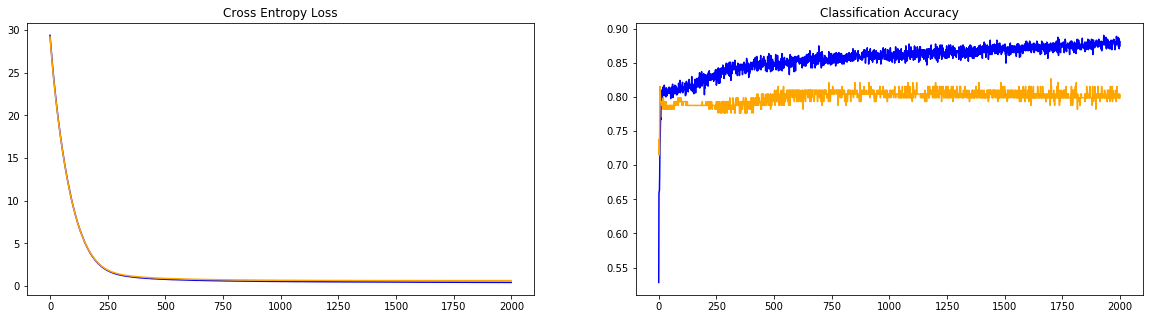

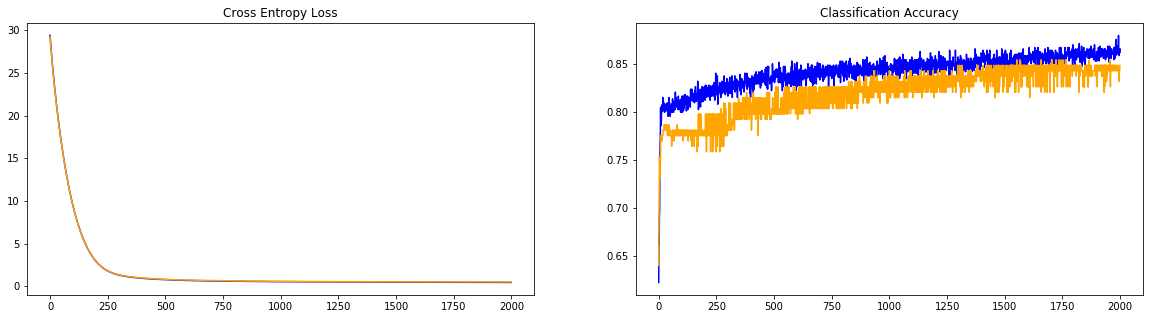

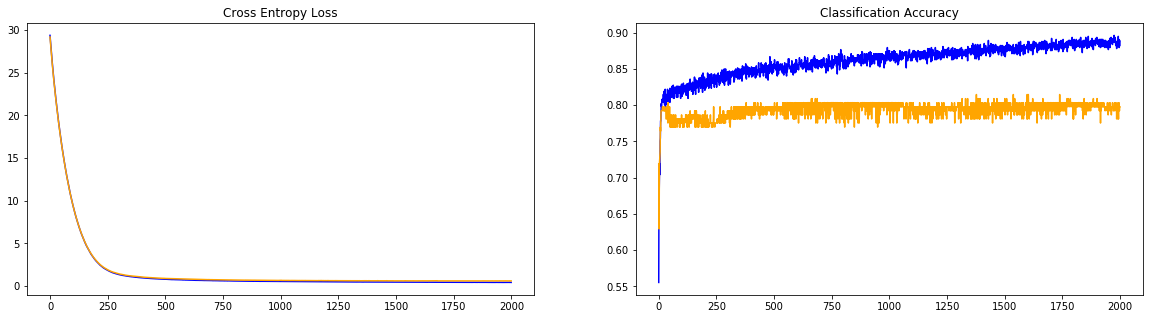

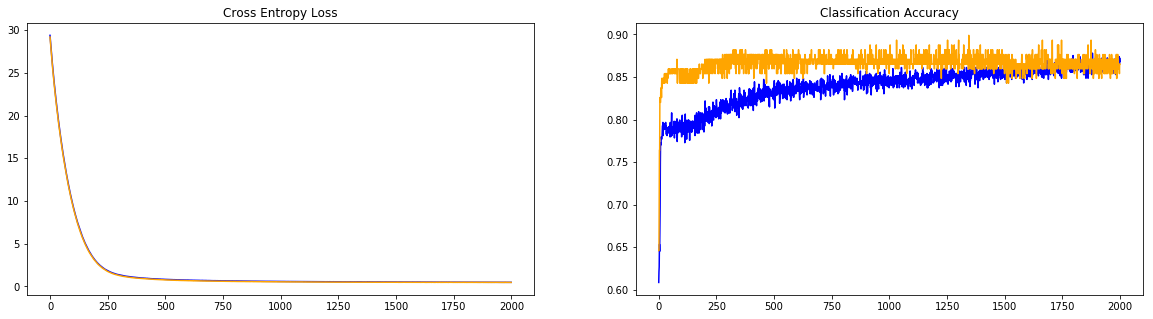

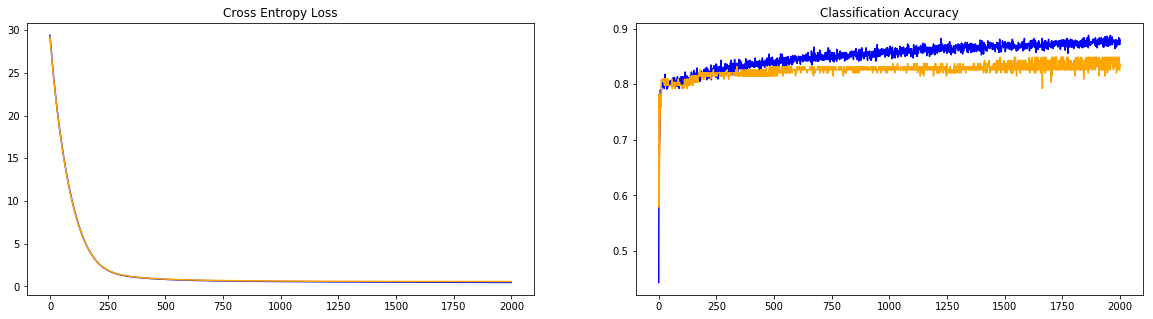

In [20]:
# evaluate
kf = KFold(n_splits=5, shuffle = True)
fold_accuracy = []
fold_loss = []
for train_index, test_index in kf.split(trainData):        
    model = CreateModel()
    model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.00001),
             metrics = ['accuracy'])
    history = model.fit(  x = trainX[train_index],
                          y = trainY[train_index],
                          epochs = 2000,
                          verbose = 2,
                          validation_data = (trainX[test_index],trainY[test_index]),
                          callbacks=[cp_callback],
                     )
    # evaluate
    test_loss, test_acc = model.evaluate(trainX[test_index],trainY[test_index],verbose = 0)    
    print('test accuracy: {}, test loss: {}'.format(test_acc,test_loss))
    fold_accuracy.append(test_acc)
    fold_loss.append(test_loss)
    # plot lose
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
#model.load_weights('./checkpoint.ckpt')          
avg_acc = sum(fold_accuracy)/len(fold_accuracy)
avg_loss = sum(fold_loss)/len(fold_less)
print('avg accuracy: {}, avg loss: {}'.format(avg_acc,avg_loss))

In [21]:
# Training
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.00001),
             metrics = ['accuracy'])
history = model.fit(  x = trainX,
                      y = trainY,
                      epochs = 2000,
                      verbose = 2,

)        

Train on 891 samples
Epoch 1/2000
891/891 - 1s - loss: 29.3578 - accuracy: 0.5354
Epoch 2/2000
891/891 - 0s - loss: 28.9463 - accuracy: 0.6330
Epoch 3/2000
891/891 - 0s - loss: 28.5420 - accuracy: 0.6476
Epoch 4/2000
891/891 - 0s - loss: 28.1423 - accuracy: 0.6633
Epoch 5/2000
891/891 - 0s - loss: 27.7415 - accuracy: 0.6925
Epoch 6/2000
891/891 - 0s - loss: 27.3499 - accuracy: 0.7071
Epoch 7/2000
891/891 - 0s - loss: 26.9575 - accuracy: 0.7576
Epoch 8/2000
891/891 - 0s - loss: 26.5693 - accuracy: 0.7542
Epoch 9/2000
891/891 - 0s - loss: 26.1907 - accuracy: 0.7755
Epoch 10/2000
891/891 - 0s - loss: 25.8096 - accuracy: 0.7856
Epoch 11/2000
891/891 - 0s - loss: 25.4467 - accuracy: 0.7969
Epoch 12/2000
891/891 - 0s - loss: 25.0860 - accuracy: 0.7969
Epoch 13/2000
891/891 - 0s - loss: 24.7415 - accuracy: 0.8047
Epoch 14/2000
891/891 - 0s - loss: 24.3949 - accuracy: 0.8047
Epoch 15/2000
891/891 - 0s - loss: 24.0588 - accuracy: 0.7980
Epoch 16/2000
891/891 - 0s - loss: 23.7293 - accuracy: 0.8

Epoch 134/2000
891/891 - 0s - loss: 4.3897 - accuracy: 0.8070
Epoch 135/2000
891/891 - 0s - loss: 4.3254 - accuracy: 0.8036
Epoch 136/2000
891/891 - 0s - loss: 4.2696 - accuracy: 0.7969
Epoch 137/2000
891/891 - 0s - loss: 4.2029 - accuracy: 0.8137
Epoch 138/2000
891/891 - 0s - loss: 4.1337 - accuracy: 0.8137
Epoch 139/2000
891/891 - 0s - loss: 4.0727 - accuracy: 0.8204
Epoch 140/2000
891/891 - 0s - loss: 4.0179 - accuracy: 0.8148
Epoch 141/2000
891/891 - 0s - loss: 3.9590 - accuracy: 0.8092
Epoch 142/2000
891/891 - 0s - loss: 3.9048 - accuracy: 0.8114
Epoch 143/2000
891/891 - 0s - loss: 3.8476 - accuracy: 0.8126
Epoch 144/2000
891/891 - 0s - loss: 3.7929 - accuracy: 0.8126
Epoch 145/2000
891/891 - 0s - loss: 3.7384 - accuracy: 0.8092
Epoch 146/2000
891/891 - 0s - loss: 3.6824 - accuracy: 0.8171
Epoch 147/2000
891/891 - 0s - loss: 3.6329 - accuracy: 0.8092
Epoch 148/2000
891/891 - 0s - loss: 3.5803 - accuracy: 0.8204
Epoch 149/2000
891/891 - 0s - loss: 3.5289 - accuracy: 0.8182
Epoch 15

891/891 - 0s - loss: 1.1547 - accuracy: 0.8272
Epoch 267/2000
891/891 - 0s - loss: 1.1501 - accuracy: 0.8260
Epoch 268/2000
891/891 - 0s - loss: 1.1397 - accuracy: 0.8283
Epoch 269/2000
891/891 - 0s - loss: 1.1406 - accuracy: 0.8305
Epoch 270/2000
891/891 - 0s - loss: 1.1421 - accuracy: 0.8215
Epoch 271/2000
891/891 - 0s - loss: 1.1351 - accuracy: 0.8238
Epoch 272/2000
891/891 - 0s - loss: 1.1260 - accuracy: 0.8316
Epoch 273/2000
891/891 - 0s - loss: 1.1153 - accuracy: 0.8395
Epoch 274/2000
891/891 - 0s - loss: 1.1146 - accuracy: 0.8316
Epoch 275/2000
891/891 - 0s - loss: 1.1095 - accuracy: 0.8294
Epoch 276/2000
891/891 - 0s - loss: 1.1032 - accuracy: 0.8272
Epoch 277/2000
891/891 - 0s - loss: 1.0931 - accuracy: 0.8328
Epoch 278/2000
891/891 - 0s - loss: 1.0980 - accuracy: 0.8171
Epoch 279/2000
891/891 - 0s - loss: 1.0878 - accuracy: 0.8249
Epoch 280/2000
891/891 - 0s - loss: 1.0883 - accuracy: 0.8316
Epoch 281/2000
891/891 - 0s - loss: 1.0799 - accuracy: 0.8249
Epoch 282/2000
891/891 

Epoch 399/2000
891/891 - 0s - loss: 0.7855 - accuracy: 0.8361
Epoch 400/2000
891/891 - 0s - loss: 0.7837 - accuracy: 0.8361
Epoch 401/2000
891/891 - 0s - loss: 0.7863 - accuracy: 0.8328
Epoch 402/2000
891/891 - 0s - loss: 0.7808 - accuracy: 0.8373
Epoch 403/2000
891/891 - 0s - loss: 0.7802 - accuracy: 0.8361
Epoch 404/2000
891/891 - 0s - loss: 0.7797 - accuracy: 0.8395
Epoch 405/2000
891/891 - 0s - loss: 0.7793 - accuracy: 0.8474
Epoch 406/2000
891/891 - 0s - loss: 0.7725 - accuracy: 0.8474
Epoch 407/2000
891/891 - 0s - loss: 0.7768 - accuracy: 0.8305
Epoch 408/2000
891/891 - 0s - loss: 0.7786 - accuracy: 0.8418
Epoch 409/2000
891/891 - 0s - loss: 0.7765 - accuracy: 0.8316
Epoch 410/2000
891/891 - 0s - loss: 0.7703 - accuracy: 0.8350
Epoch 411/2000
891/891 - 0s - loss: 0.7694 - accuracy: 0.8395
Epoch 412/2000
891/891 - 0s - loss: 0.7660 - accuracy: 0.8418
Epoch 413/2000
891/891 - 0s - loss: 0.7642 - accuracy: 0.8350
Epoch 414/2000
891/891 - 0s - loss: 0.7660 - accuracy: 0.8373
Epoch 41

891/891 - 0s - loss: 0.6529 - accuracy: 0.8429
Epoch 532/2000
891/891 - 0s - loss: 0.6582 - accuracy: 0.8395
Epoch 533/2000
891/891 - 0s - loss: 0.6523 - accuracy: 0.8429
Epoch 534/2000
891/891 - 0s - loss: 0.6565 - accuracy: 0.8406
Epoch 535/2000
891/891 - 0s - loss: 0.6539 - accuracy: 0.8429
Epoch 536/2000
891/891 - 0s - loss: 0.6507 - accuracy: 0.8451
Epoch 537/2000
891/891 - 0s - loss: 0.6542 - accuracy: 0.8440
Epoch 538/2000
891/891 - 0s - loss: 0.6485 - accuracy: 0.8429
Epoch 539/2000
891/891 - 0s - loss: 0.6512 - accuracy: 0.8451
Epoch 540/2000
891/891 - 0s - loss: 0.6523 - accuracy: 0.8384
Epoch 541/2000
891/891 - 0s - loss: 0.6517 - accuracy: 0.8418
Epoch 542/2000
891/891 - 0s - loss: 0.6496 - accuracy: 0.8485
Epoch 543/2000
891/891 - 0s - loss: 0.6504 - accuracy: 0.8406
Epoch 544/2000
891/891 - 0s - loss: 0.6481 - accuracy: 0.8361
Epoch 545/2000
891/891 - 0s - loss: 0.6497 - accuracy: 0.8316
Epoch 546/2000
891/891 - 0s - loss: 0.6437 - accuracy: 0.8485
Epoch 547/2000
891/891 

Epoch 664/2000
891/891 - 0s - loss: 0.5862 - accuracy: 0.8496
Epoch 665/2000
891/891 - 0s - loss: 0.5883 - accuracy: 0.8373
Epoch 666/2000
891/891 - 0s - loss: 0.5880 - accuracy: 0.8462
Epoch 667/2000
891/891 - 0s - loss: 0.5895 - accuracy: 0.8541
Epoch 668/2000
891/891 - 0s - loss: 0.5866 - accuracy: 0.8462
Epoch 669/2000
891/891 - 0s - loss: 0.5861 - accuracy: 0.8485
Epoch 670/2000
891/891 - 0s - loss: 0.5822 - accuracy: 0.8519
Epoch 671/2000
891/891 - 0s - loss: 0.5871 - accuracy: 0.8451
Epoch 672/2000
891/891 - 0s - loss: 0.5879 - accuracy: 0.8507
Epoch 673/2000
891/891 - 0s - loss: 0.5852 - accuracy: 0.8485
Epoch 674/2000
891/891 - 0s - loss: 0.5861 - accuracy: 0.8631
Epoch 675/2000
891/891 - 0s - loss: 0.5858 - accuracy: 0.8552
Epoch 676/2000
891/891 - 0s - loss: 0.5881 - accuracy: 0.8429
Epoch 677/2000
891/891 - 0s - loss: 0.5816 - accuracy: 0.8496
Epoch 678/2000
891/891 - 0s - loss: 0.5848 - accuracy: 0.8406
Epoch 679/2000
891/891 - 0s - loss: 0.5799 - accuracy: 0.8496
Epoch 68

891/891 - 0s - loss: 0.5442 - accuracy: 0.8485
Epoch 797/2000
891/891 - 0s - loss: 0.5439 - accuracy: 0.8586
Epoch 798/2000
891/891 - 0s - loss: 0.5480 - accuracy: 0.8541
Epoch 799/2000
891/891 - 0s - loss: 0.5453 - accuracy: 0.8485
Epoch 800/2000
891/891 - 0s - loss: 0.5456 - accuracy: 0.8530
Epoch 801/2000
891/891 - 0s - loss: 0.5488 - accuracy: 0.8541
Epoch 802/2000
891/891 - 0s - loss: 0.5455 - accuracy: 0.8485
Epoch 803/2000
891/891 - 0s - loss: 0.5451 - accuracy: 0.8552
Epoch 804/2000
891/891 - 0s - loss: 0.5466 - accuracy: 0.8485
Epoch 805/2000
891/891 - 0s - loss: 0.5432 - accuracy: 0.8496
Epoch 806/2000
891/891 - 0s - loss: 0.5444 - accuracy: 0.8541
Epoch 807/2000
891/891 - 0s - loss: 0.5442 - accuracy: 0.8496
Epoch 808/2000
891/891 - 0s - loss: 0.5412 - accuracy: 0.8496
Epoch 809/2000
891/891 - 0s - loss: 0.5392 - accuracy: 0.8485
Epoch 810/2000
891/891 - 0s - loss: 0.5434 - accuracy: 0.8530
Epoch 811/2000
891/891 - 0s - loss: 0.5431 - accuracy: 0.8507
Epoch 812/2000
891/891 

Epoch 929/2000
891/891 - 0s - loss: 0.5216 - accuracy: 0.8586
Epoch 930/2000
891/891 - 0s - loss: 0.5178 - accuracy: 0.8519
Epoch 931/2000
891/891 - 0s - loss: 0.5224 - accuracy: 0.8519
Epoch 932/2000
891/891 - 0s - loss: 0.5175 - accuracy: 0.8552
Epoch 933/2000
891/891 - 0s - loss: 0.5260 - accuracy: 0.8440
Epoch 934/2000
891/891 - 0s - loss: 0.5141 - accuracy: 0.8507
Epoch 935/2000
891/891 - 0s - loss: 0.5199 - accuracy: 0.8519
Epoch 936/2000
891/891 - 0s - loss: 0.5184 - accuracy: 0.8563
Epoch 937/2000
891/891 - 0s - loss: 0.5188 - accuracy: 0.8485
Epoch 938/2000
891/891 - 0s - loss: 0.5188 - accuracy: 0.8563
Epoch 939/2000
891/891 - 0s - loss: 0.5207 - accuracy: 0.8507
Epoch 940/2000
891/891 - 0s - loss: 0.5165 - accuracy: 0.8552
Epoch 941/2000
891/891 - 0s - loss: 0.5175 - accuracy: 0.8586
Epoch 942/2000
891/891 - 0s - loss: 0.5173 - accuracy: 0.8586
Epoch 943/2000
891/891 - 0s - loss: 0.5201 - accuracy: 0.8541
Epoch 944/2000
891/891 - 0s - loss: 0.5186 - accuracy: 0.8462
Epoch 94

Epoch 1061/2000
891/891 - 0s - loss: 0.4993 - accuracy: 0.8541
Epoch 1062/2000
891/891 - 0s - loss: 0.5025 - accuracy: 0.8530
Epoch 1063/2000
891/891 - 0s - loss: 0.5011 - accuracy: 0.8530
Epoch 1064/2000
891/891 - 0s - loss: 0.5007 - accuracy: 0.8541
Epoch 1065/2000
891/891 - 0s - loss: 0.5024 - accuracy: 0.8552
Epoch 1066/2000
891/891 - 0s - loss: 0.4980 - accuracy: 0.8507
Epoch 1067/2000
891/891 - 0s - loss: 0.4992 - accuracy: 0.8586
Epoch 1068/2000
891/891 - 0s - loss: 0.4969 - accuracy: 0.8575
Epoch 1069/2000
891/891 - 0s - loss: 0.4958 - accuracy: 0.8620
Epoch 1070/2000
891/891 - 0s - loss: 0.4963 - accuracy: 0.8597
Epoch 1071/2000
891/891 - 0s - loss: 0.4959 - accuracy: 0.8653
Epoch 1072/2000
891/891 - 0s - loss: 0.4965 - accuracy: 0.8575
Epoch 1073/2000
891/891 - 0s - loss: 0.4997 - accuracy: 0.8608
Epoch 1074/2000
891/891 - 0s - loss: 0.4952 - accuracy: 0.8586
Epoch 1075/2000
891/891 - 0s - loss: 0.4944 - accuracy: 0.8597
Epoch 1076/2000
891/891 - 0s - loss: 0.4990 - accuracy:

891/891 - 0s - loss: 0.4836 - accuracy: 0.8552
Epoch 1192/2000
891/891 - 0s - loss: 0.4854 - accuracy: 0.8541
Epoch 1193/2000
891/891 - 0s - loss: 0.4823 - accuracy: 0.8631
Epoch 1194/2000
891/891 - 0s - loss: 0.4853 - accuracy: 0.8653
Epoch 1195/2000
891/891 - 0s - loss: 0.4856 - accuracy: 0.8620
Epoch 1196/2000
891/891 - 0s - loss: 0.4811 - accuracy: 0.8575
Epoch 1197/2000
891/891 - 0s - loss: 0.4848 - accuracy: 0.8597
Epoch 1198/2000
891/891 - 0s - loss: 0.4825 - accuracy: 0.8575
Epoch 1199/2000
891/891 - 0s - loss: 0.4820 - accuracy: 0.8597
Epoch 1200/2000
891/891 - 0s - loss: 0.4867 - accuracy: 0.8519
Epoch 1201/2000
891/891 - 0s - loss: 0.4830 - accuracy: 0.8563
Epoch 1202/2000
891/891 - 0s - loss: 0.4844 - accuracy: 0.8597
Epoch 1203/2000
891/891 - 0s - loss: 0.4811 - accuracy: 0.8552
Epoch 1204/2000
891/891 - 0s - loss: 0.4857 - accuracy: 0.8597
Epoch 1205/2000
891/891 - 0s - loss: 0.4849 - accuracy: 0.8586
Epoch 1206/2000
891/891 - 0s - loss: 0.4843 - accuracy: 0.8597
Epoch 12

Epoch 1322/2000
891/891 - 0s - loss: 0.4731 - accuracy: 0.8608
Epoch 1323/2000
891/891 - 0s - loss: 0.4704 - accuracy: 0.8631
Epoch 1324/2000
891/891 - 0s - loss: 0.4757 - accuracy: 0.8631
Epoch 1325/2000
891/891 - 0s - loss: 0.4696 - accuracy: 0.8653
Epoch 1326/2000
891/891 - 0s - loss: 0.4720 - accuracy: 0.8586
Epoch 1327/2000
891/891 - 0s - loss: 0.4709 - accuracy: 0.8620
Epoch 1328/2000
891/891 - 0s - loss: 0.4716 - accuracy: 0.8631
Epoch 1329/2000
891/891 - 0s - loss: 0.4741 - accuracy: 0.8608
Epoch 1330/2000
891/891 - 0s - loss: 0.4745 - accuracy: 0.8631
Epoch 1331/2000
891/891 - 0s - loss: 0.4710 - accuracy: 0.8631
Epoch 1332/2000
891/891 - 0s - loss: 0.4723 - accuracy: 0.8664
Epoch 1333/2000
891/891 - 0s - loss: 0.4694 - accuracy: 0.8608
Epoch 1334/2000
891/891 - 0s - loss: 0.4741 - accuracy: 0.8575
Epoch 1335/2000
891/891 - 0s - loss: 0.4747 - accuracy: 0.8586
Epoch 1336/2000
891/891 - 0s - loss: 0.4678 - accuracy: 0.8653
Epoch 1337/2000
891/891 - 0s - loss: 0.4720 - accuracy:

891/891 - 0s - loss: 0.4624 - accuracy: 0.8541
Epoch 1453/2000
891/891 - 0s - loss: 0.4620 - accuracy: 0.8620
Epoch 1454/2000
891/891 - 0s - loss: 0.4636 - accuracy: 0.8575
Epoch 1455/2000
891/891 - 0s - loss: 0.4635 - accuracy: 0.8631
Epoch 1456/2000
891/891 - 0s - loss: 0.4621 - accuracy: 0.8597
Epoch 1457/2000
891/891 - 0s - loss: 0.4587 - accuracy: 0.8698
Epoch 1458/2000
891/891 - 0s - loss: 0.4632 - accuracy: 0.8563
Epoch 1459/2000
891/891 - 0s - loss: 0.4623 - accuracy: 0.8620
Epoch 1460/2000
891/891 - 0s - loss: 0.4661 - accuracy: 0.8563
Epoch 1461/2000
891/891 - 0s - loss: 0.4630 - accuracy: 0.8653
Epoch 1462/2000
891/891 - 0s - loss: 0.4637 - accuracy: 0.8642
Epoch 1463/2000
891/891 - 0s - loss: 0.4660 - accuracy: 0.8586
Epoch 1464/2000
891/891 - 0s - loss: 0.4598 - accuracy: 0.8586
Epoch 1465/2000
891/891 - 0s - loss: 0.4632 - accuracy: 0.8676
Epoch 1466/2000
891/891 - 0s - loss: 0.4638 - accuracy: 0.8519
Epoch 1467/2000
891/891 - 0s - loss: 0.4599 - accuracy: 0.8631
Epoch 14

Epoch 1583/2000
891/891 - 0s - loss: 0.4568 - accuracy: 0.8620
Epoch 1584/2000
891/891 - 0s - loss: 0.4565 - accuracy: 0.8597
Epoch 1585/2000
891/891 - 0s - loss: 0.4536 - accuracy: 0.8664
Epoch 1586/2000
891/891 - 0s - loss: 0.4567 - accuracy: 0.8676
Epoch 1587/2000
891/891 - 0s - loss: 0.4570 - accuracy: 0.8620
Epoch 1588/2000
891/891 - 0s - loss: 0.4553 - accuracy: 0.8687
Epoch 1589/2000
891/891 - 0s - loss: 0.4492 - accuracy: 0.8732
Epoch 1590/2000
891/891 - 0s - loss: 0.4580 - accuracy: 0.8709
Epoch 1591/2000
891/891 - 0s - loss: 0.4523 - accuracy: 0.8664
Epoch 1592/2000
891/891 - 0s - loss: 0.4533 - accuracy: 0.8608
Epoch 1593/2000
891/891 - 0s - loss: 0.4534 - accuracy: 0.8541
Epoch 1594/2000
891/891 - 0s - loss: 0.4567 - accuracy: 0.8642
Epoch 1595/2000
891/891 - 0s - loss: 0.4525 - accuracy: 0.8687
Epoch 1596/2000
891/891 - 0s - loss: 0.4521 - accuracy: 0.8676
Epoch 1597/2000
891/891 - 0s - loss: 0.4523 - accuracy: 0.8709
Epoch 1598/2000
891/891 - 0s - loss: 0.4544 - accuracy:

891/891 - 0s - loss: 0.4468 - accuracy: 0.8687
Epoch 1714/2000
891/891 - 0s - loss: 0.4458 - accuracy: 0.8698
Epoch 1715/2000
891/891 - 0s - loss: 0.4482 - accuracy: 0.8676
Epoch 1716/2000
891/891 - 0s - loss: 0.4498 - accuracy: 0.8608
Epoch 1717/2000
891/891 - 0s - loss: 0.4486 - accuracy: 0.8709
Epoch 1718/2000
891/891 - 0s - loss: 0.4438 - accuracy: 0.8687
Epoch 1719/2000
891/891 - 0s - loss: 0.4514 - accuracy: 0.8642
Epoch 1720/2000
891/891 - 0s - loss: 0.4486 - accuracy: 0.8653
Epoch 1721/2000
891/891 - 0s - loss: 0.4456 - accuracy: 0.8642
Epoch 1722/2000
891/891 - 0s - loss: 0.4499 - accuracy: 0.8642
Epoch 1723/2000
891/891 - 0s - loss: 0.4497 - accuracy: 0.8664
Epoch 1724/2000
891/891 - 0s - loss: 0.4490 - accuracy: 0.8709
Epoch 1725/2000
891/891 - 0s - loss: 0.4443 - accuracy: 0.8698
Epoch 1726/2000
891/891 - 0s - loss: 0.4464 - accuracy: 0.8608
Epoch 1727/2000
891/891 - 0s - loss: 0.4486 - accuracy: 0.8698
Epoch 1728/2000
891/891 - 0s - loss: 0.4509 - accuracy: 0.8620
Epoch 17

Epoch 1844/2000
891/891 - 0s - loss: 0.4382 - accuracy: 0.8687
Epoch 1845/2000
891/891 - 0s - loss: 0.4422 - accuracy: 0.8664
Epoch 1846/2000
891/891 - 0s - loss: 0.4424 - accuracy: 0.8687
Epoch 1847/2000
891/891 - 0s - loss: 0.4416 - accuracy: 0.8653
Epoch 1848/2000
891/891 - 0s - loss: 0.4439 - accuracy: 0.8676
Epoch 1849/2000
891/891 - 0s - loss: 0.4408 - accuracy: 0.8620
Epoch 1850/2000
891/891 - 0s - loss: 0.4439 - accuracy: 0.8653
Epoch 1851/2000
891/891 - 0s - loss: 0.4438 - accuracy: 0.8653
Epoch 1852/2000
891/891 - 0s - loss: 0.4390 - accuracy: 0.8676
Epoch 1853/2000
891/891 - 0s - loss: 0.4395 - accuracy: 0.8664
Epoch 1854/2000
891/891 - 0s - loss: 0.4375 - accuracy: 0.8754
Epoch 1855/2000
891/891 - 0s - loss: 0.4426 - accuracy: 0.8687
Epoch 1856/2000
891/891 - 0s - loss: 0.4418 - accuracy: 0.8676
Epoch 1857/2000
891/891 - 0s - loss: 0.4406 - accuracy: 0.8709
Epoch 1858/2000
891/891 - 0s - loss: 0.4405 - accuracy: 0.8664
Epoch 1859/2000
891/891 - 0s - loss: 0.4401 - accuracy:

891/891 - 0s - loss: 0.4398 - accuracy: 0.8642
Epoch 1975/2000
891/891 - 0s - loss: 0.4344 - accuracy: 0.8676
Epoch 1976/2000
891/891 - 0s - loss: 0.4396 - accuracy: 0.8698
Epoch 1977/2000
891/891 - 0s - loss: 0.4365 - accuracy: 0.8698
Epoch 1978/2000
891/891 - 0s - loss: 0.4355 - accuracy: 0.8664
Epoch 1979/2000
891/891 - 0s - loss: 0.4354 - accuracy: 0.8698
Epoch 1980/2000
891/891 - 0s - loss: 0.4371 - accuracy: 0.8664
Epoch 1981/2000
891/891 - 0s - loss: 0.4350 - accuracy: 0.8709
Epoch 1982/2000
891/891 - 0s - loss: 0.4398 - accuracy: 0.8698
Epoch 1983/2000
891/891 - 0s - loss: 0.4360 - accuracy: 0.8642
Epoch 1984/2000
891/891 - 0s - loss: 0.4352 - accuracy: 0.8709
Epoch 1985/2000
891/891 - 0s - loss: 0.4371 - accuracy: 0.8653
Epoch 1986/2000
891/891 - 0s - loss: 0.4377 - accuracy: 0.8709
Epoch 1987/2000
891/891 - 0s - loss: 0.4351 - accuracy: 0.8754
Epoch 1988/2000
891/891 - 0s - loss: 0.4363 - accuracy: 0.8676
Epoch 1989/2000
891/891 - 0s - loss: 0.4371 - accuracy: 0.8664
Epoch 19

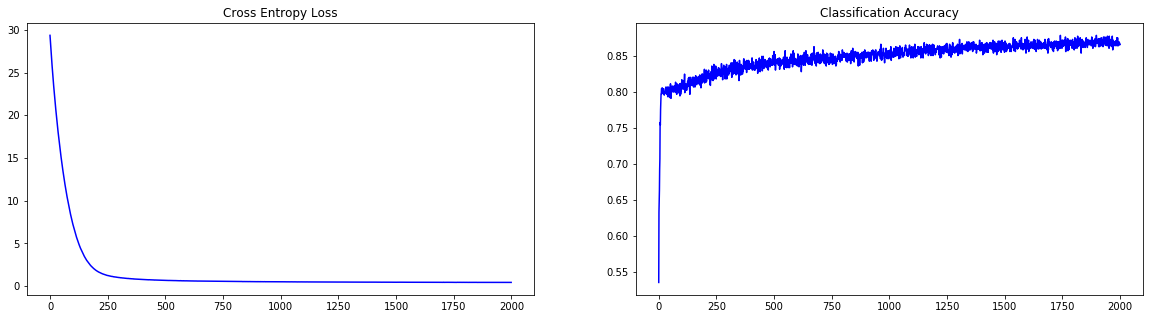

In [22]:

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')


In [23]:
# predictions
predictions = model.predict_classes(testX).reshape(len(testX))
# write csv file
submission =pd.DataFrame({'PassengerId':pId,'Survived':predictions})
submission.to_csv('Titanic Predictions.csv',index = False)

0.8271922469139099
